# Assignment 1

# Density estimation using Real NVP

Normalizing flows is the class of probabilistic models that provides flexible parametrical probabilistic models, where the probability density function can be computed exactly. In the assignment, we will consider a real-valued non-volume preserving normalizing flows (Real NVP) -- a special case of normalizing flow.

#### Problem setting

Our goal is to train a generative network $g_\theta:  Z \rightarrow X, g = f^{-1}$ that maps latent variable $z \sim p(z)$ to a sample $x \sim p(x)$. Where $p(z)$ is a prior distibiution and $p(x)$ is a data distibution. An illustrative example is provided below.

![alt text](https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/f4ed2d6ac83954b1358168dc98be3f17b6f2abbb/assignments/normalizing-flows/2d-example.png)

#### Change of variable formula

Given an observed data variable $x \in X$,
a simple prior probability distribution $p_{Z}$ on a latent variable $z \in Z$,
and a bijection $f: X \rightarrow Z$ (with $g = f^{-1}$),
the change of variable formula defines a model distribution of $X$ by
$$
\begin{align}
p_{X}(x) &= p_{Z}\big(f(x)\big) \left|\det\left(\cfrac{\partial f(x)}{\partial x^T} \right)\right|
\label{eq:change-variables}\\
\log\left(p_{X}(x)\right) &= \log\Big(p_{Z}\big(f(x)\big)\Big) + \log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)
,
\end{align}$$

![alt text](https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/f4ed2d6ac83954b1358168dc98be3f17b6f2abbb/assignments/normalizing-flows/f.png)
where $\frac{\partial f(x)}{\partial x^T}$ is the Jacobian of $f$ at $x$.

Exact samples from the resulting distribution can be generated by using the inverse transform sampling rule. A sample $z \sim p_{Z}$ is drawn in the latent space, and its inverse image $x = f^{-1}(z) = g(z)$ generates a sample in the original space. Computing the density at a point $x$ is accomplished by computing the density of its image $f(x)$ and multiplying by the associated Jacobian determinant $\det\left(\frac{\partial f(x)}{\partial x^T}\right)$.

#### Real NVP

Real NVP presents a class of functions where $\log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)$ can be computed efficiently (see, 3.3 Properties, https://arxiv.org/abs/1605.08803). Every layer of Real NVP is a coupling layer followed by permutation layer. Combination of coupling and permutation layers can be implemented as a masked version of the coupling layer:
#### $$y = b \odot x + (1 - b) \odot \Big(x \odot \exp\big(s(b \odot x)\big) + t(b \odot x)\Big)$$

where $s$ and $t$ stand for scale and translation, and are functions from $R^{D} \mapsto R^{D}$, and $\odot$ is the Hadamard product or element-wise product, $b$ is a binary mask. For more details on the model see the paper Density estimation using Real NVP https://arxiv.org/abs/1605.08803.

# In this assignment:
1. Implementation of Real NVP
2. Training Real NVP on 2d circles or moons dataset
3. Visualization of the generative model
4. Optional Research Assignment

Additional information:
- You will need the following python packages: PyTorch, Numpy, sklearn, matplotlib.
- If you have an urgent question or find a typo or a mistake, send it to ars.ashuha@gmail.com. The title should include "BDL Assignment 2 2018".
- A submission policy will be released later.

# Implementation of Real NVP

In [1]:

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import numpy as np

In [2]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, masks, prior):
        super(RealNVP, self).__init__()
        
        # Create a flow
        # nets:  a function that returns a PyTorch neural network, e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that returns a PyTorch neural network, e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # masks:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal
        
        self.prior = prior
        self.masks = nn.Parameter(masks, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def g(self, z):
        # Compute and return g(z) = x, 
        #    where self.masks[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # z: a torch.Tensor of shape batchSize x 1 x dim(X)
        # return x: a torch.Tensor of shape batchSize x 1 x dim(X)
        
        # Maps from auxillary space to original data space (forward)
        # Implements equation 7 from paper
        
        num_layers = len(self.t)
        z_in = z
        for i in range(num_layers):
            b = self.masks[i]
            t = self.t[i]
            s = self.s[i]
            z_out = (b*z_in) + (1-b)*(z_in*torch.exp(s(b*z_in)*(1-b)) + t(b*z_in)*(1-b))
            z_in = z_out
        x = z_out    
        return x

    def f(self, x):
        # Compute f(x) = z and log_det_Jakobian of f, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        
        # Maps from original data space to auxillary space (inverse)
        # Implements equation 8 from paper
        
        num_layers = len(self.t)
        x_in = x
        log_det_J = torch.zeros(x_in.shape[0])
        for i in reversed(range(num_layers)):
            b = self.masks[i]
            t = self.t[i]
            s = self.s[i]
            x_out = b*x_in + (1-b)*(x_in - t(b*x_in)*(1-b)) * torch.exp(-s(b*x_in)*(1-b)) 
            log_det_J -= (s(b*x_in)*(1-b)).sum(dim=1)
            x_in = x_out
        z = x_out          

        return z, log_det_J
        
    def log_prob(self, x):
        # Compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        z, log_det_J = self.f(x)
        logp = self.prior.log_prob(z) + log_det_J
        return logp
        
    def sample(self, batchSize): 
        # Draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x 1 x dim(X)
        z = self.prior.sample((batchSize, 1))
        logp = self.prior.log_prob(z)
        x = self.g(z)
        return x

In [3]:
#nets = # a function that take no arguments and return a pytorch model, dim(X) -> dim(X)
#nett = # a function that take no arguments and return a pytorch model, dim(X) -> dim(X)

# Check nets and nett are working i.e., computing without errors
# Check that resulting dimensions s and t are the same and equal dim(X)

nets = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32))
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow = RealNVP(nets, nett, masks, prior)

In [4]:
from sklearn import datasets

#trainable_parametrs = # list of all trainable parameters in a flow
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)

for t in range(5001):    
    noisy_moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
    loss = -flow.log_prob(torch.from_numpy(noisy_moons)).mean()# compute the maximum-likelihood loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
# Check that the loss decreases
# Is the visualization below good?

iter 0: loss = 2.211
iter 500: loss = 0.667
iter 1000: loss = 0.423
iter 1500: loss = 0.443
iter 2000: loss = 0.452
iter 2500: loss = 0.415
iter 3000: loss = 0.430
iter 3500: loss = 0.394
iter 4000: loss = 0.484
iter 4500: loss = 0.217
iter 5000: loss = 0.282


# Visualization

In [5]:
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

Draw several plots: 
- samples from flow
- samples from prior
- data samples
- mapping form data to prior

The goal is to obtain figure similar to https://arxiv.org/abs/1605.08803

Text(0.5, 1.0, '$X = g(z)$')

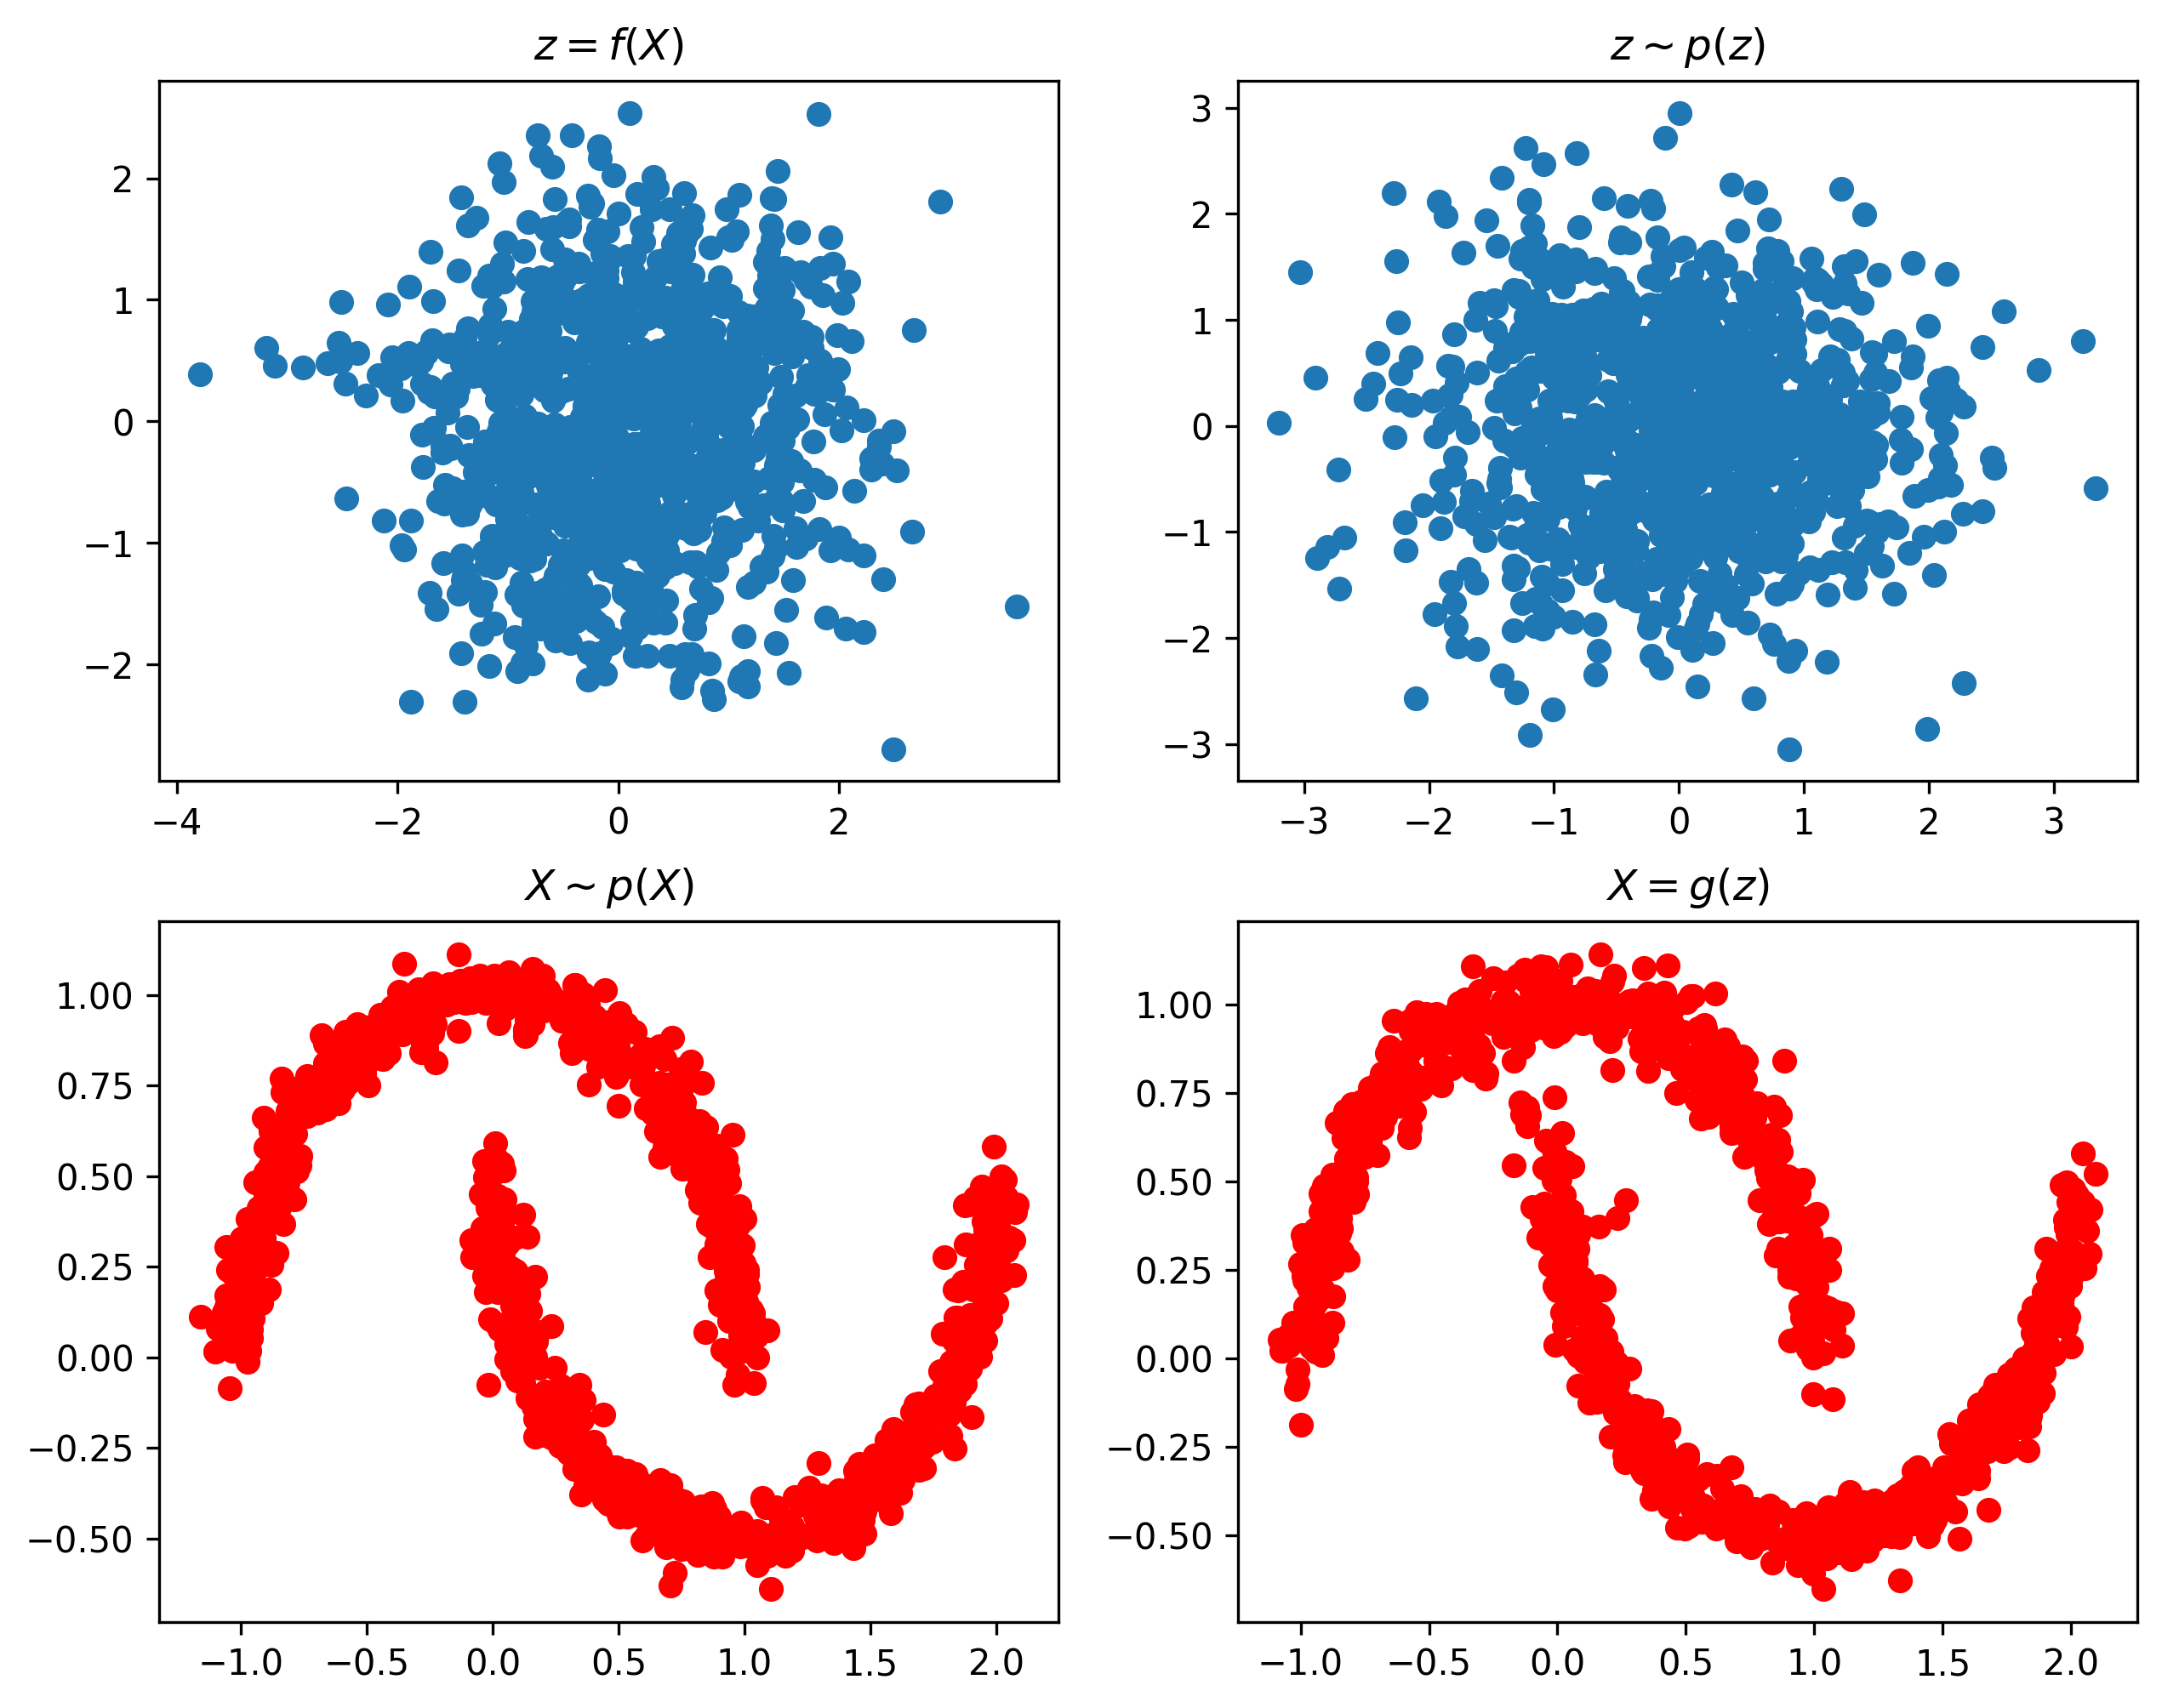

In [6]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')

## Provide answers for the folowing questions:

1. What architecture worked better in your experiments?


**Your answer with justification**


2. Did you find what is important for stable training (initializations, nonlinearities, ...)?


**Your answer with justification**


3. How convergence speed (in iterations) depends on the complexity of architecture?


**Your answer with justification**


# Optional Research Assignments:

This assignment is optional. It will give you up to 2 additional points for one of the assignments.   
#### 1. VAE: 
Use normalizing flow to get more expressive $q(z\,|\,x)$,  https://arxiv.org/abs/1505.05770. TL;dr; use decoder to predict $z_0 \sim q_0(z_0|x)$, then use NF to obtain $z_k = f_k \circ \dots \circ f_1(z)$ sample from a more flexible distribution. Compare it with a conventional normal distribution, what is working better? Compare it with conventional VAE  that uses the same number of parameters as VAE with NF.

#### 2. Expressiveness: 
- Train the flow on an another 2d-dataset e.g., a mixture of 6 Gaussians (see figure 10, https://openreview.net/pdf?id=Hkg313AcFX). Is it possible to fit it with a normalizing flow? What is more beneficial increase size of s and t or increase the depth? Provide a justification for the answer e.g. plots.
- Use the flow to sample images from a more complex dataset, e.g. downsampled MNIST (8x8 should be fine). Do your findings remains the same? Also, provide plots.


https://github.com/ANLGBOY/RealNVP-with-PyTorch/blob/master/main.py

In [7]:
import torch
from torch import nn, optim, distributions
from torch.nn import functional as F
#from torchvision import transforms
#from torchvision.utils import save_image

from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import os

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.024234
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.035486
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.048199
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.052727
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.055079
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.056670
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.057491
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.056765
====> Epoch: 1 Average loss: -0.0481


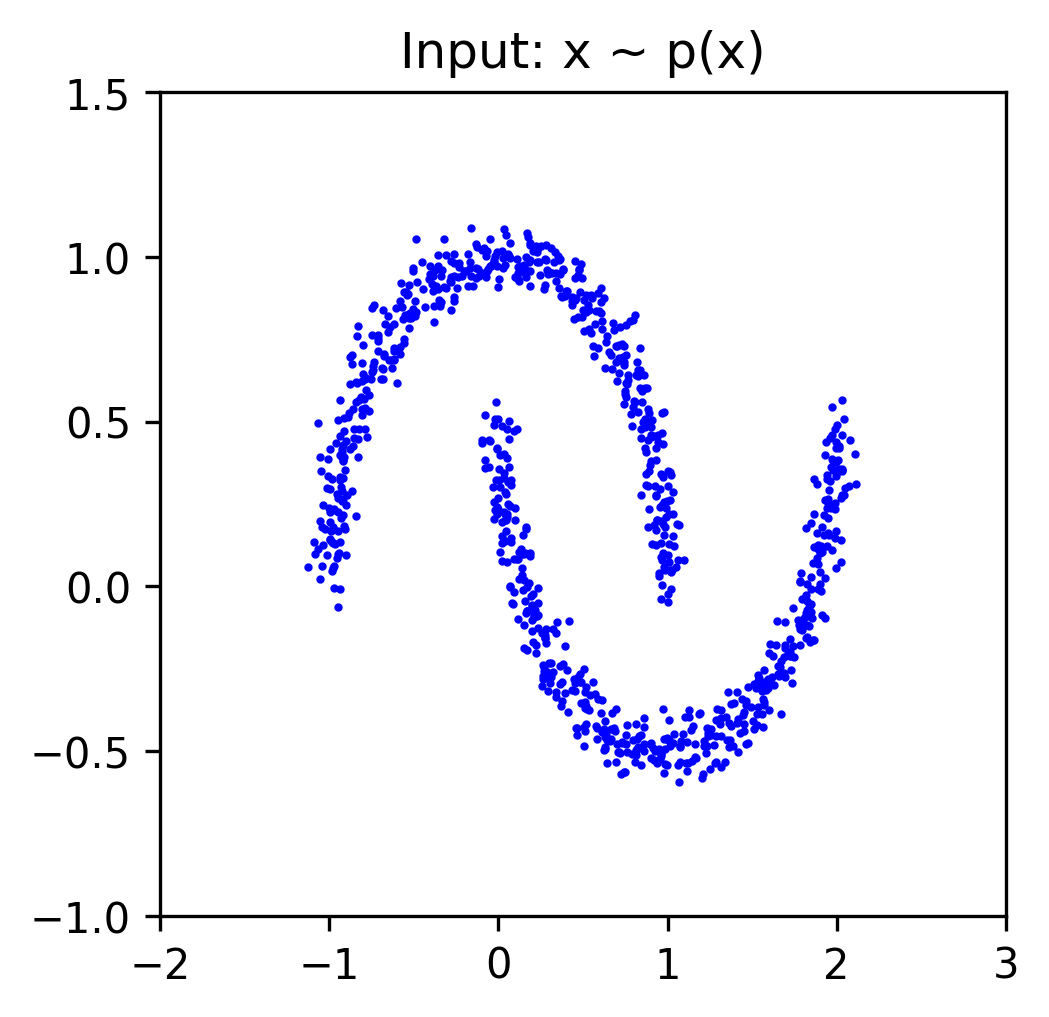

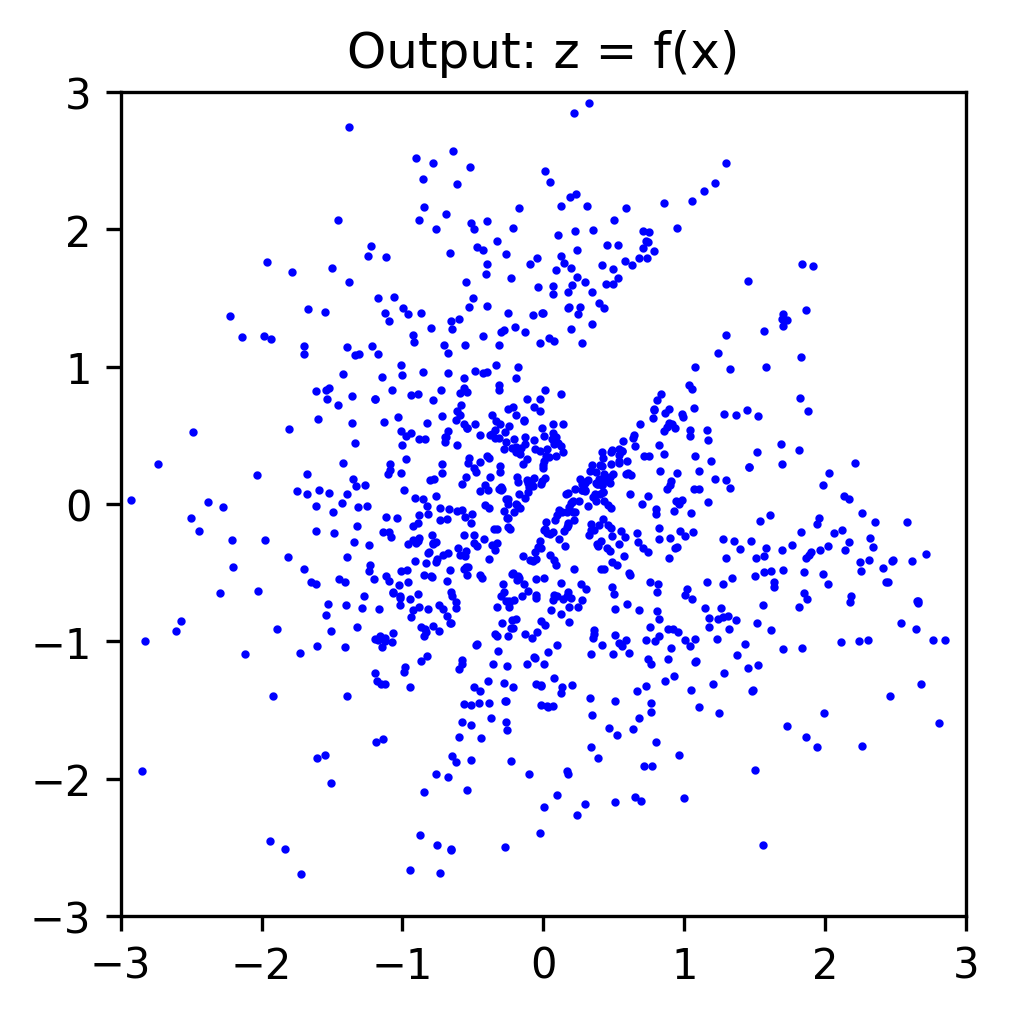

====> Test set loss: -0.0590


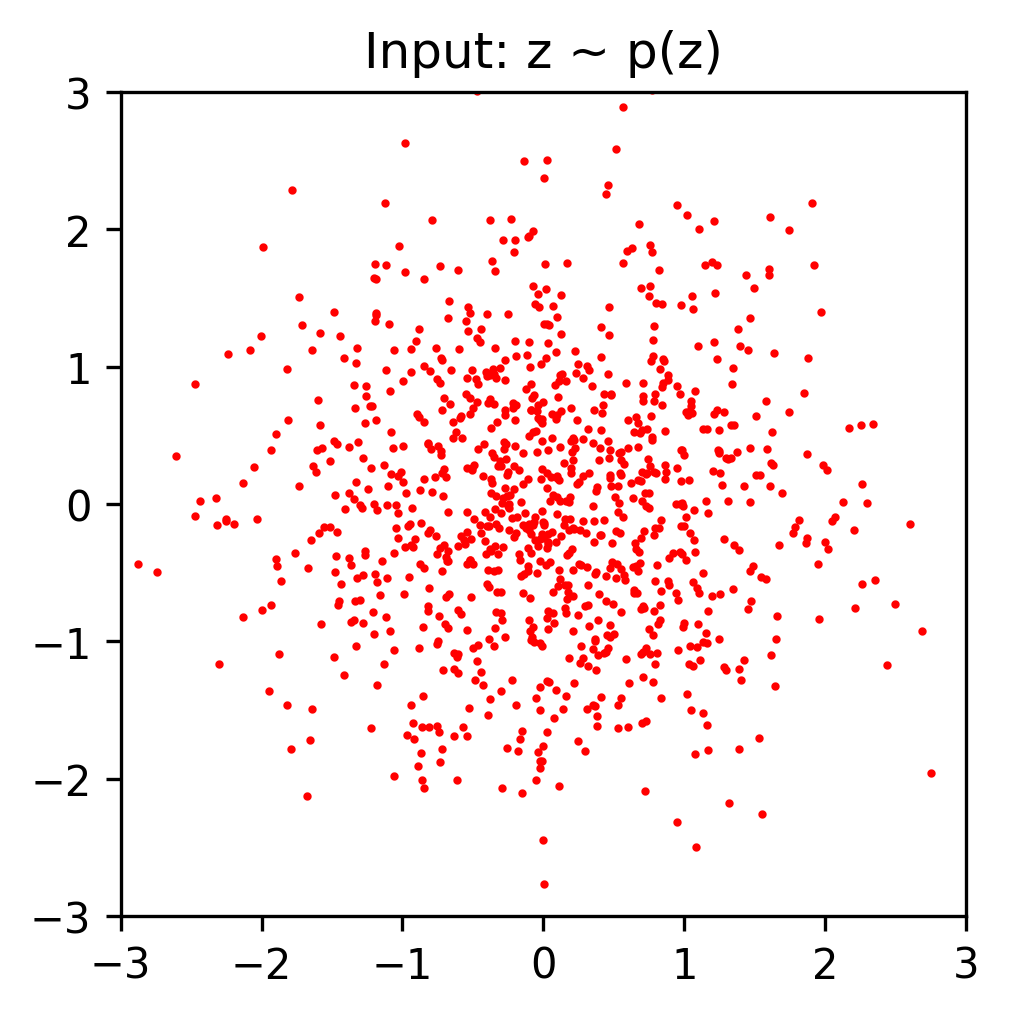

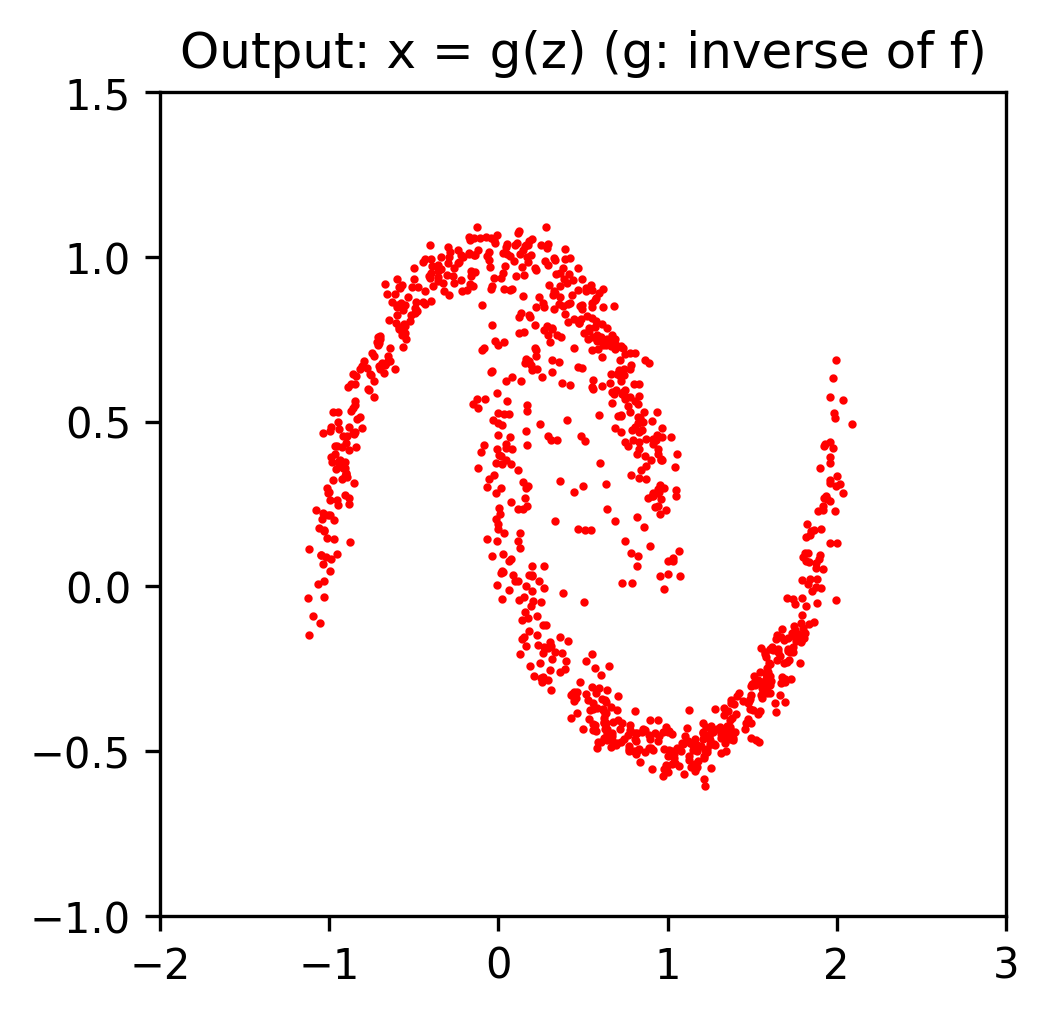

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.058398
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.057430
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.058290
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.058471
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.057951
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.058852
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.058974
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.058719
====> Epoch: 2 Average loss: -0.0585


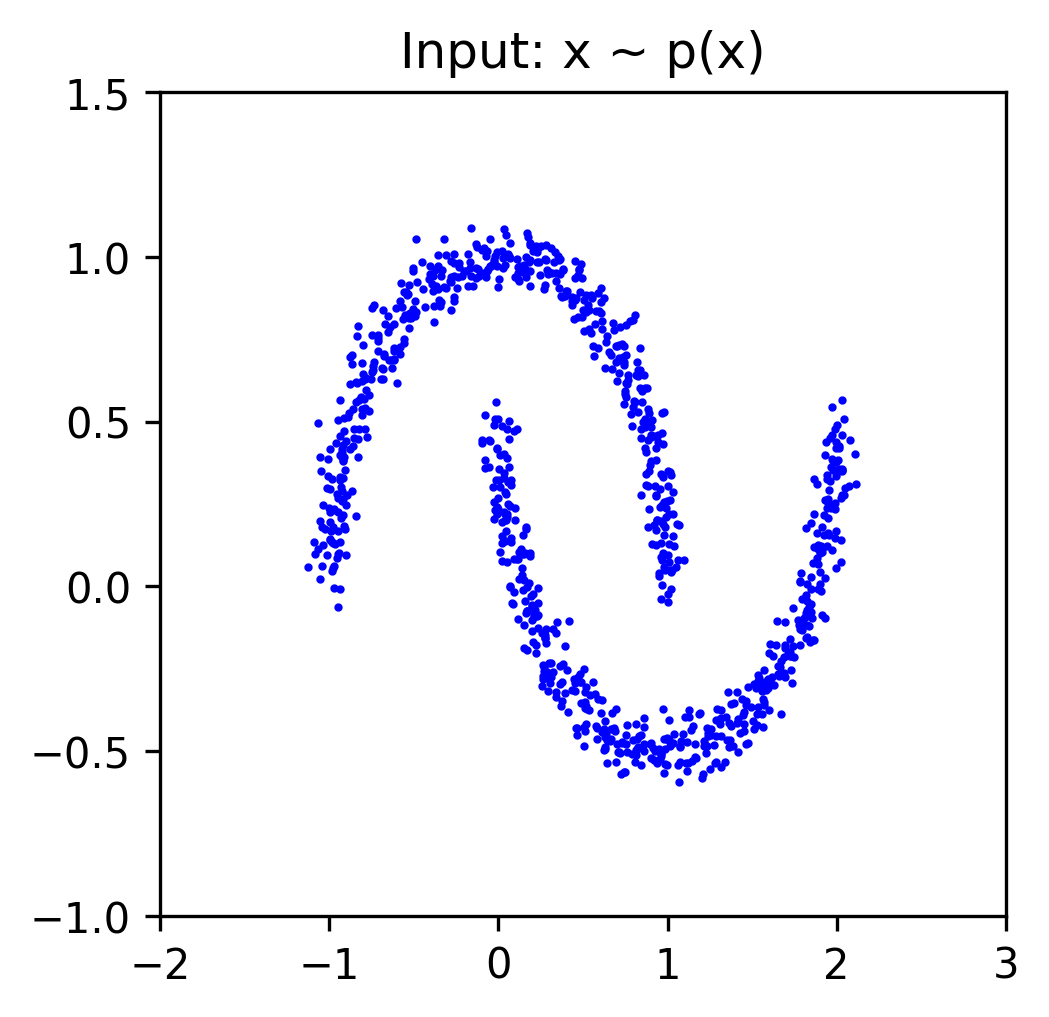

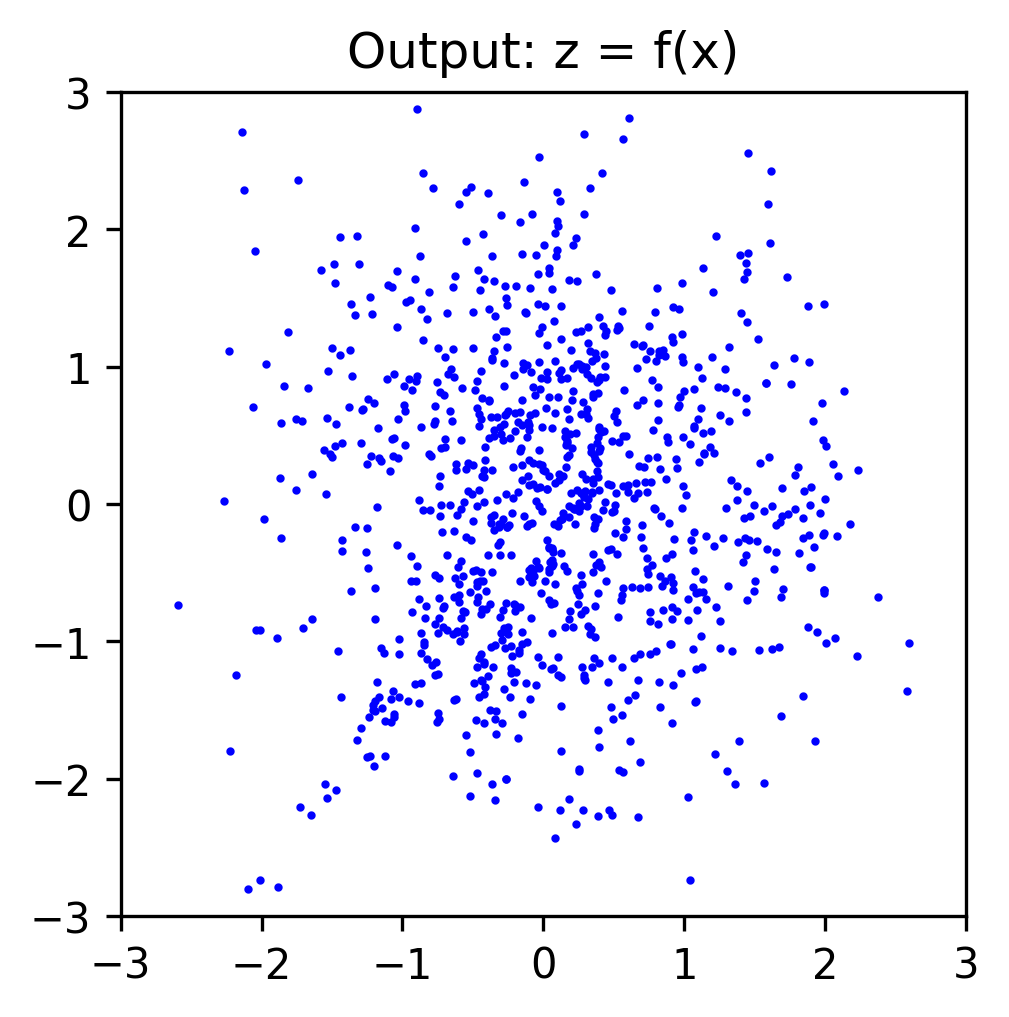

====> Test set loss: -0.0599


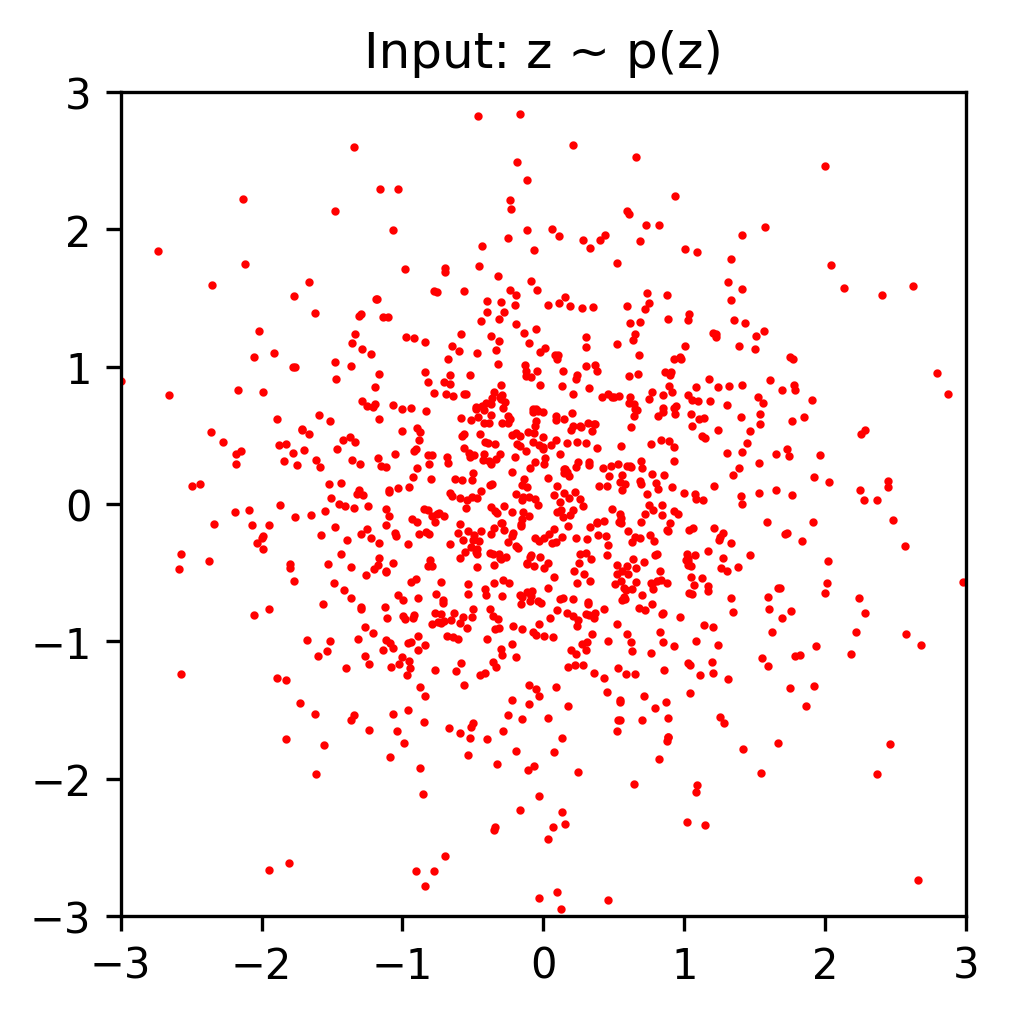

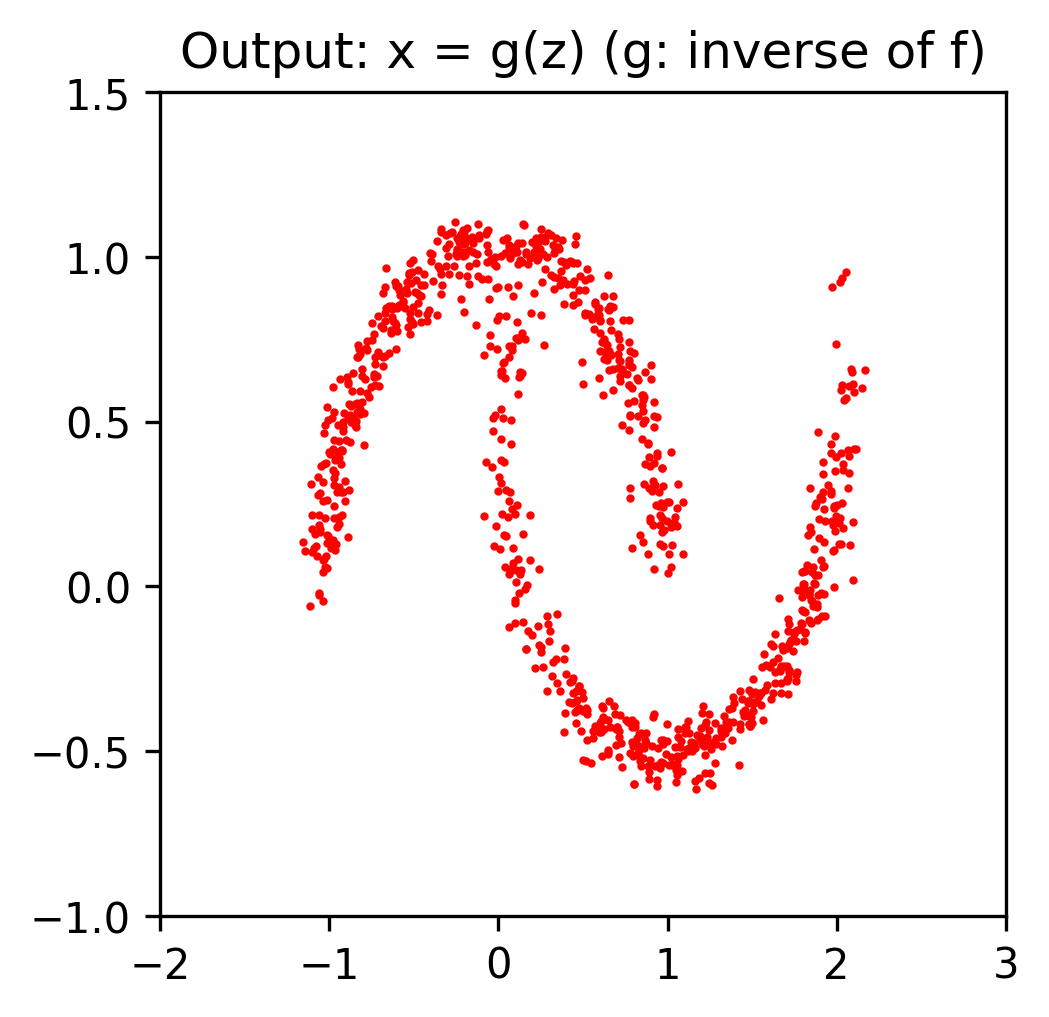

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.059749
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.058888
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.060238
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.060139
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.059112
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.059246
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.057305
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.059196
====> Epoch: 3 Average loss: -0.0591


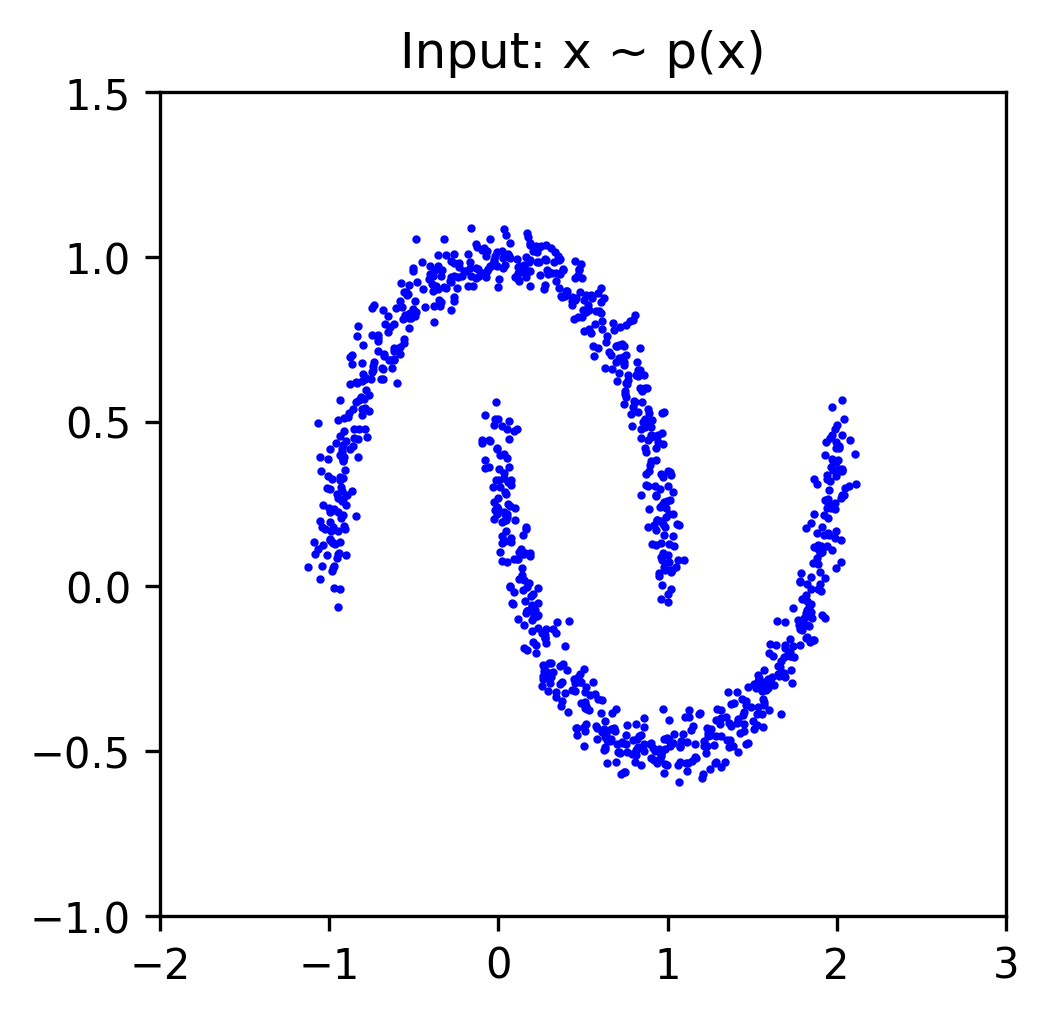

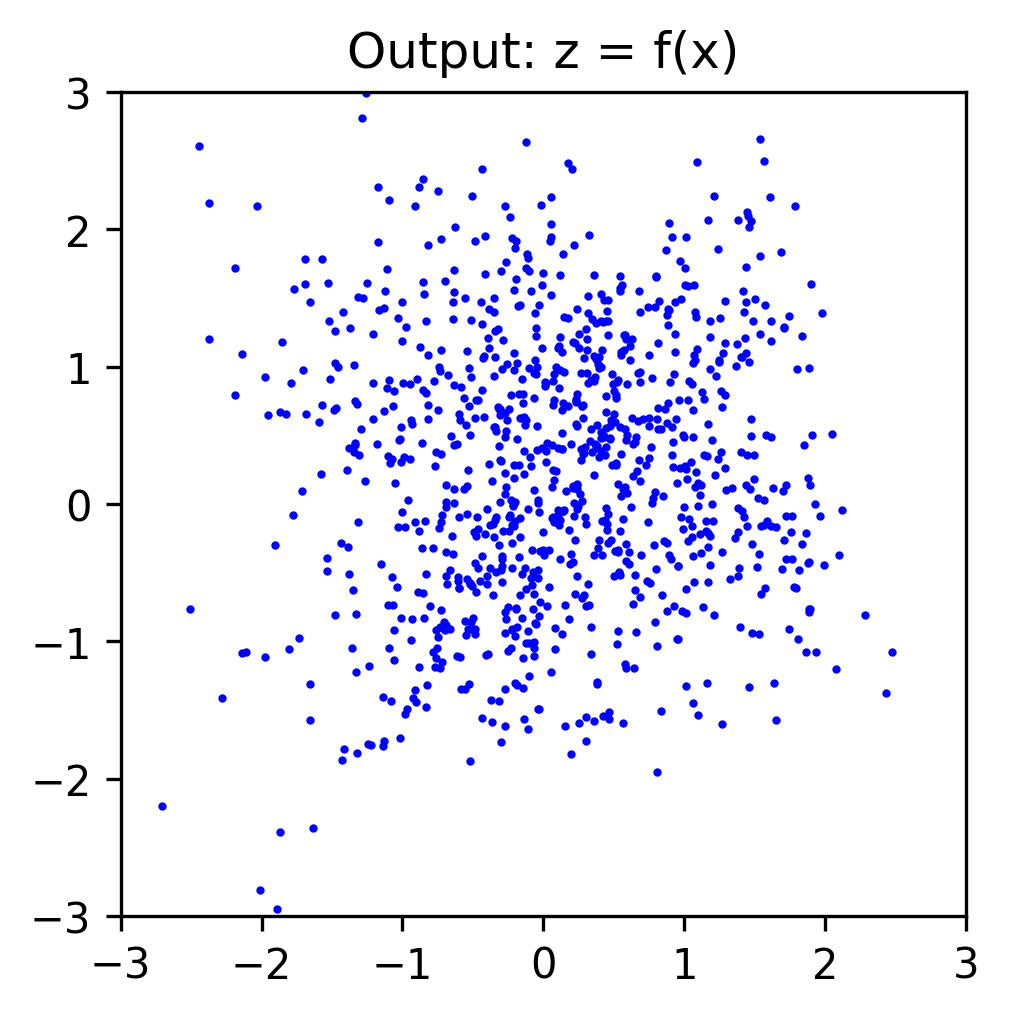

====> Test set loss: -0.0599


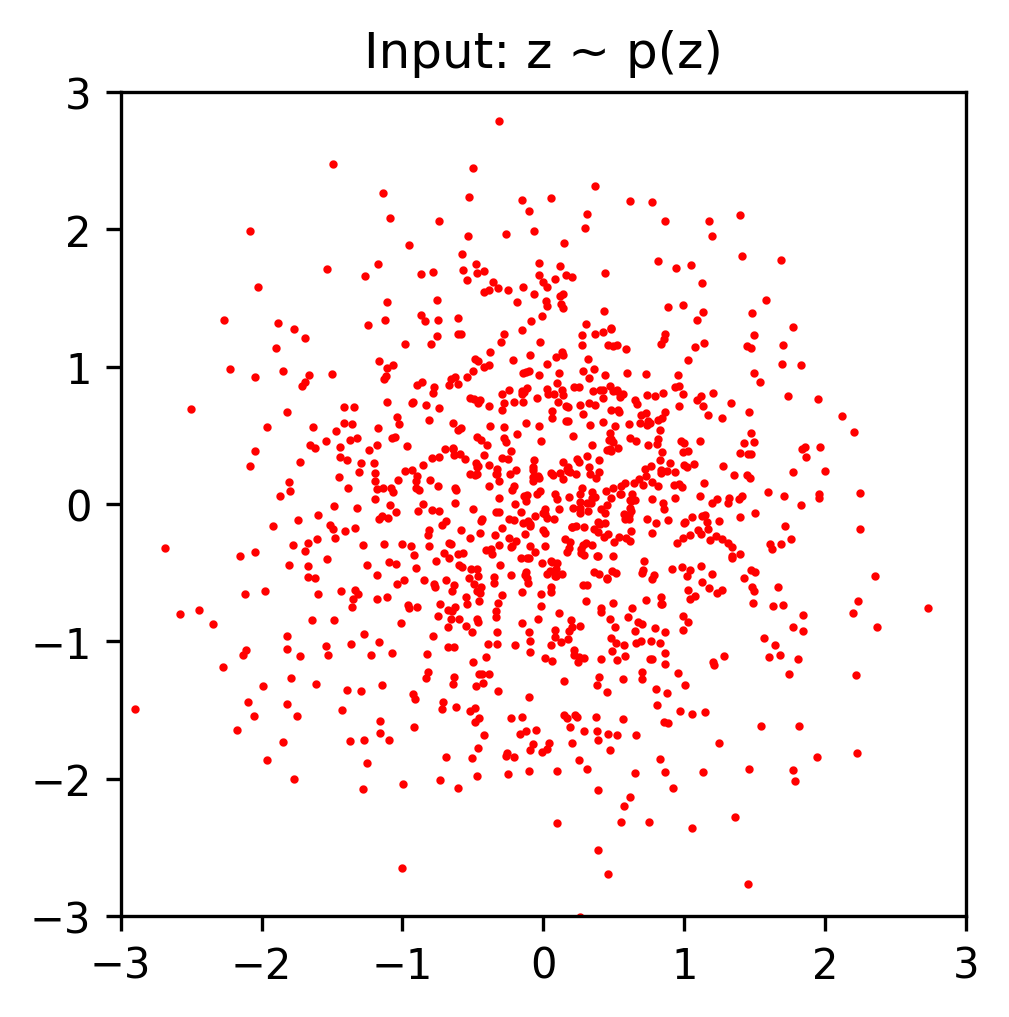

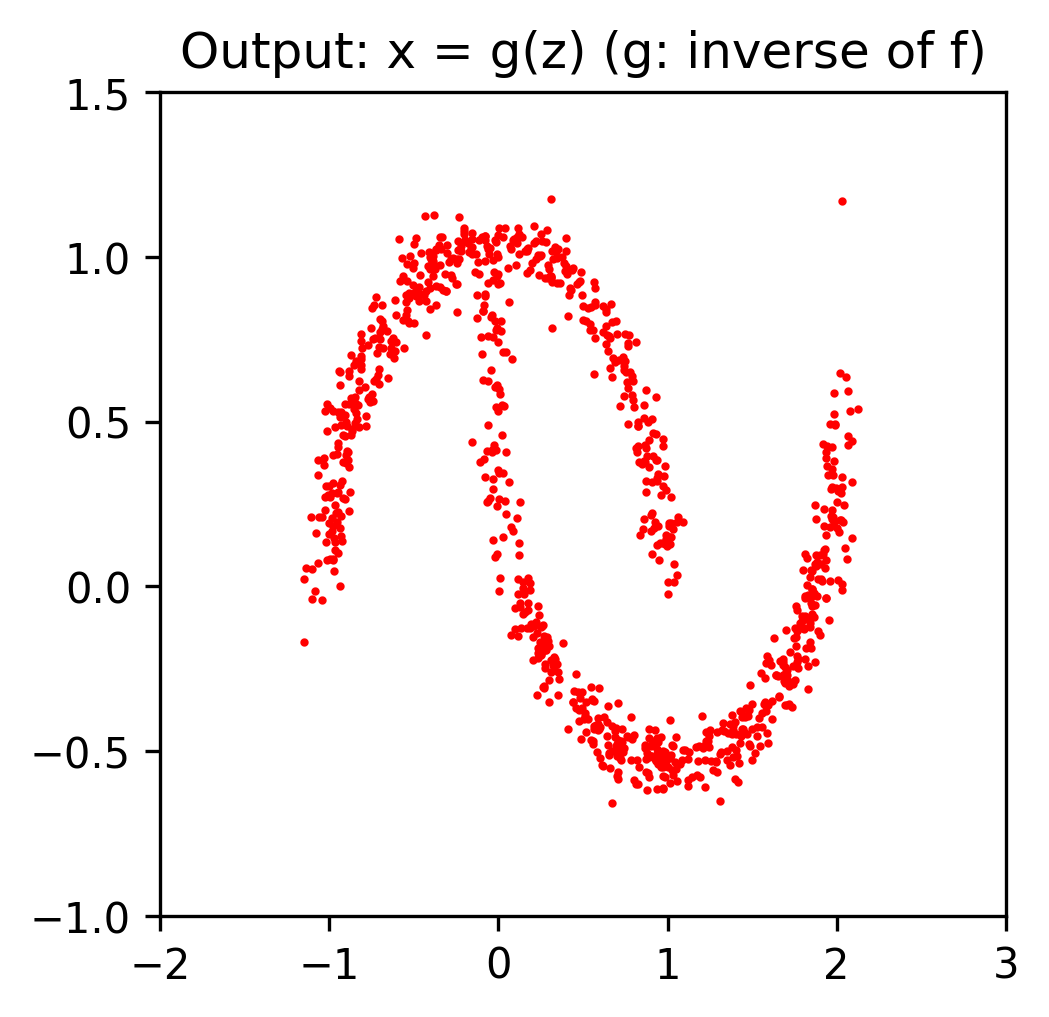

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.059345
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.059666
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.059924
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.059898
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.059998
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.058465
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.059387
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.058263
====> Epoch: 4 Average loss: -0.0593


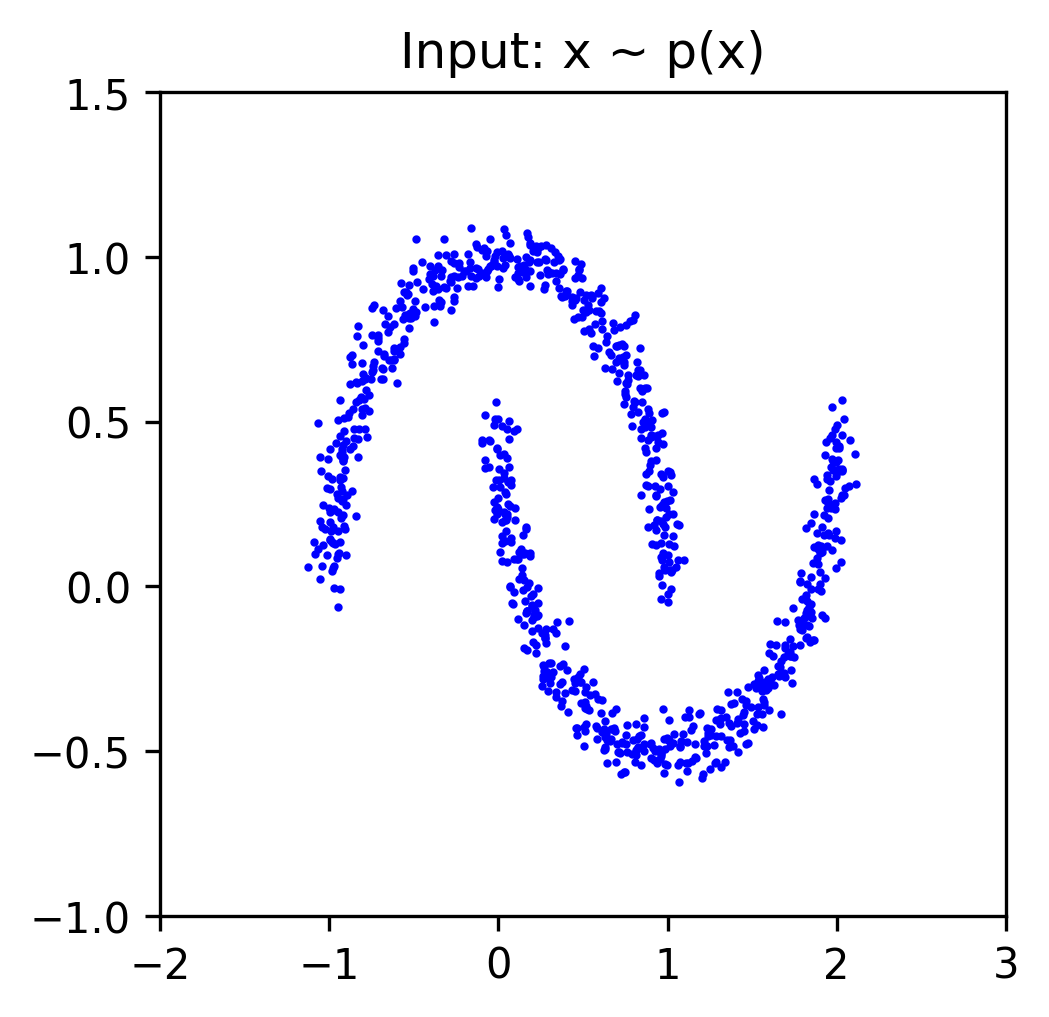

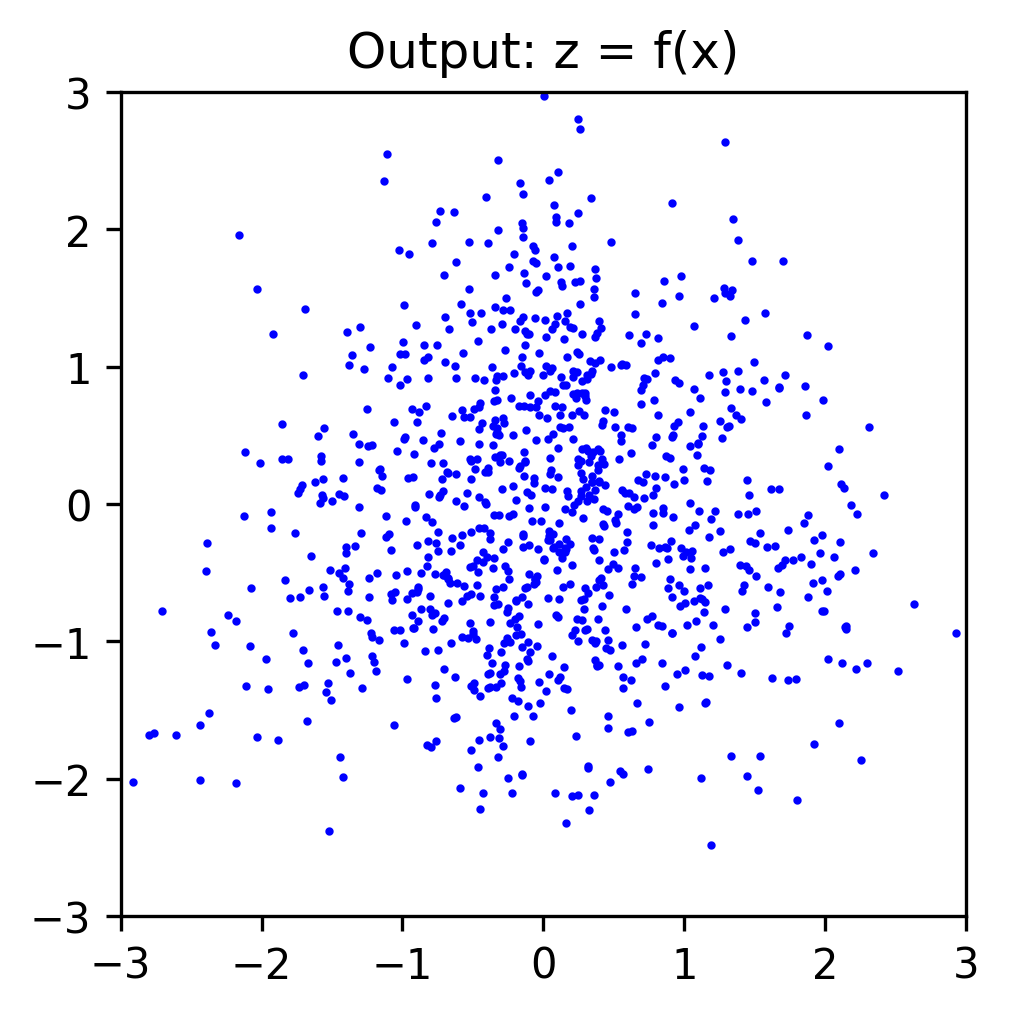

====> Test set loss: -0.0605


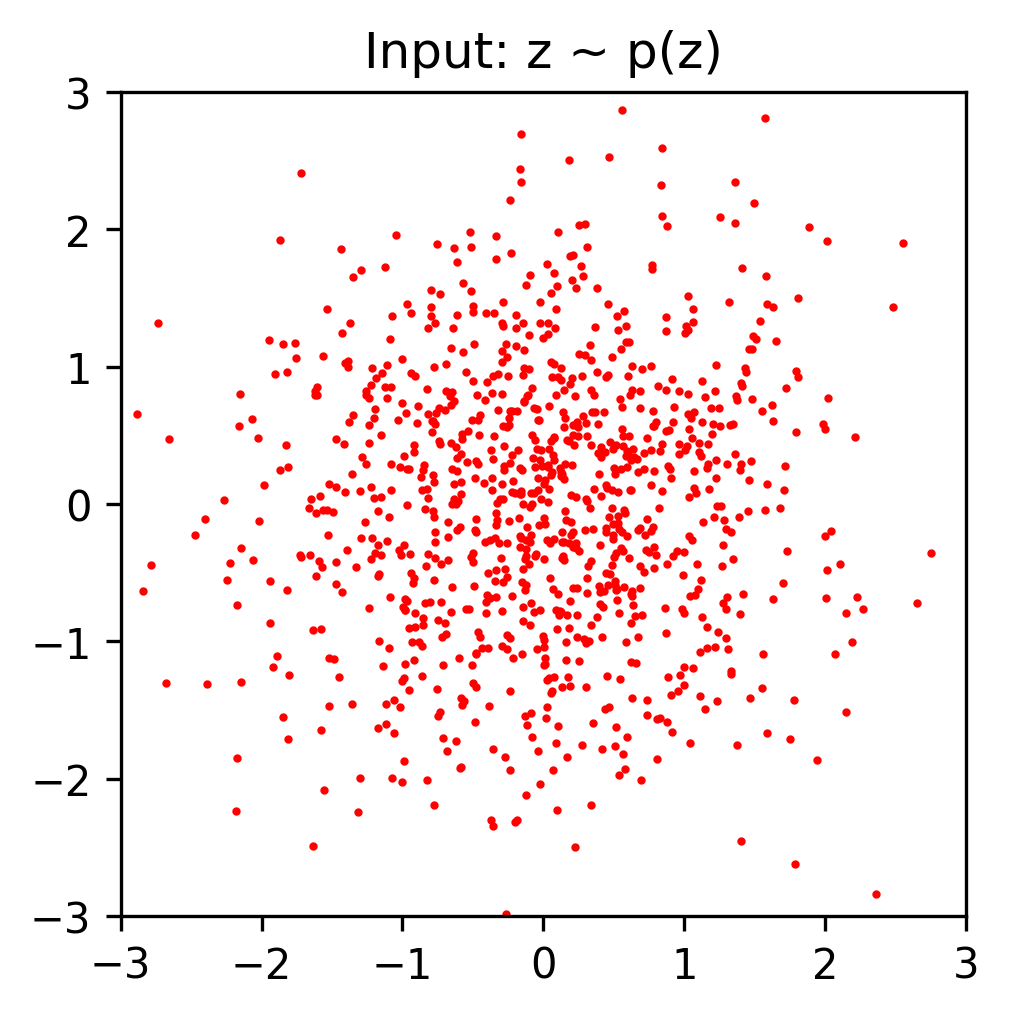

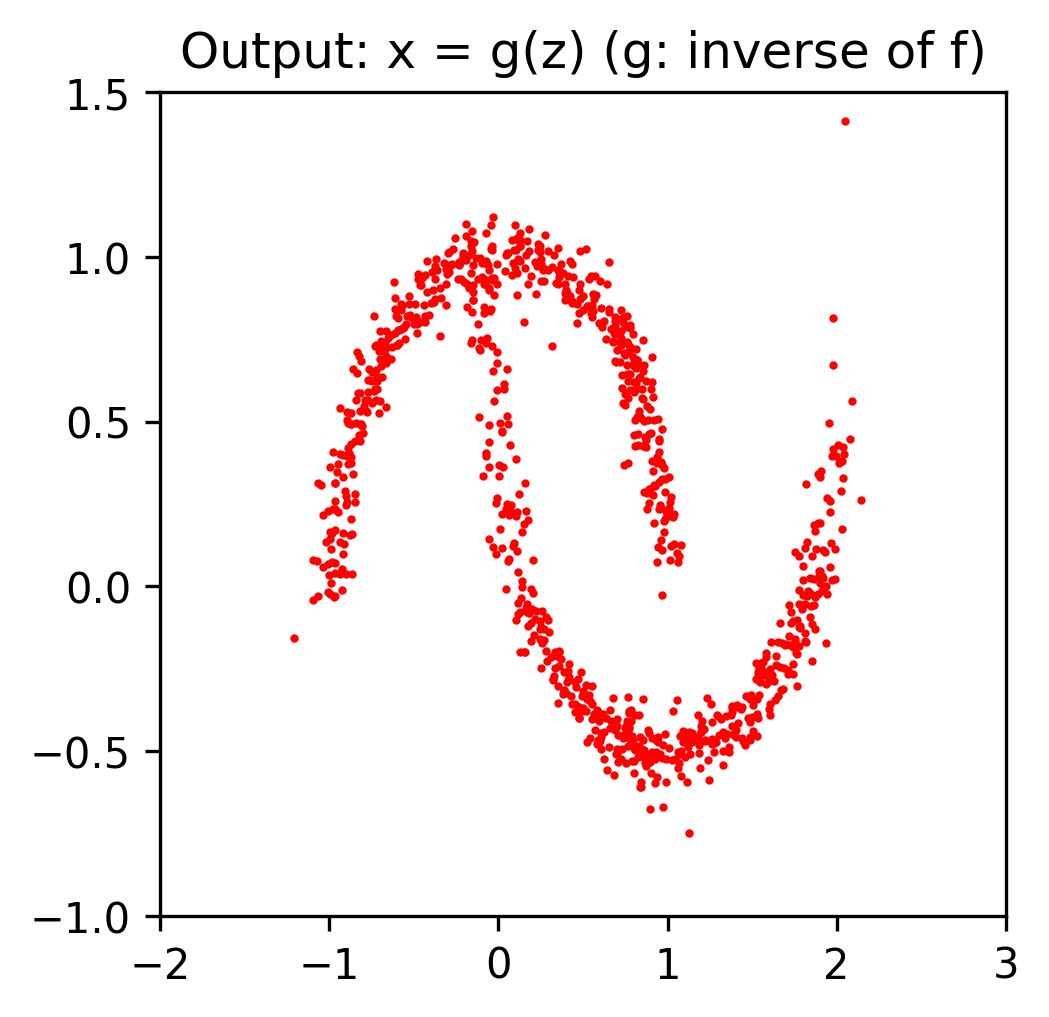

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.059010
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.059563
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.060553
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.059854
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.059135
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.059754
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.059603
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.059879
====> Epoch: 5 Average loss: -0.0595


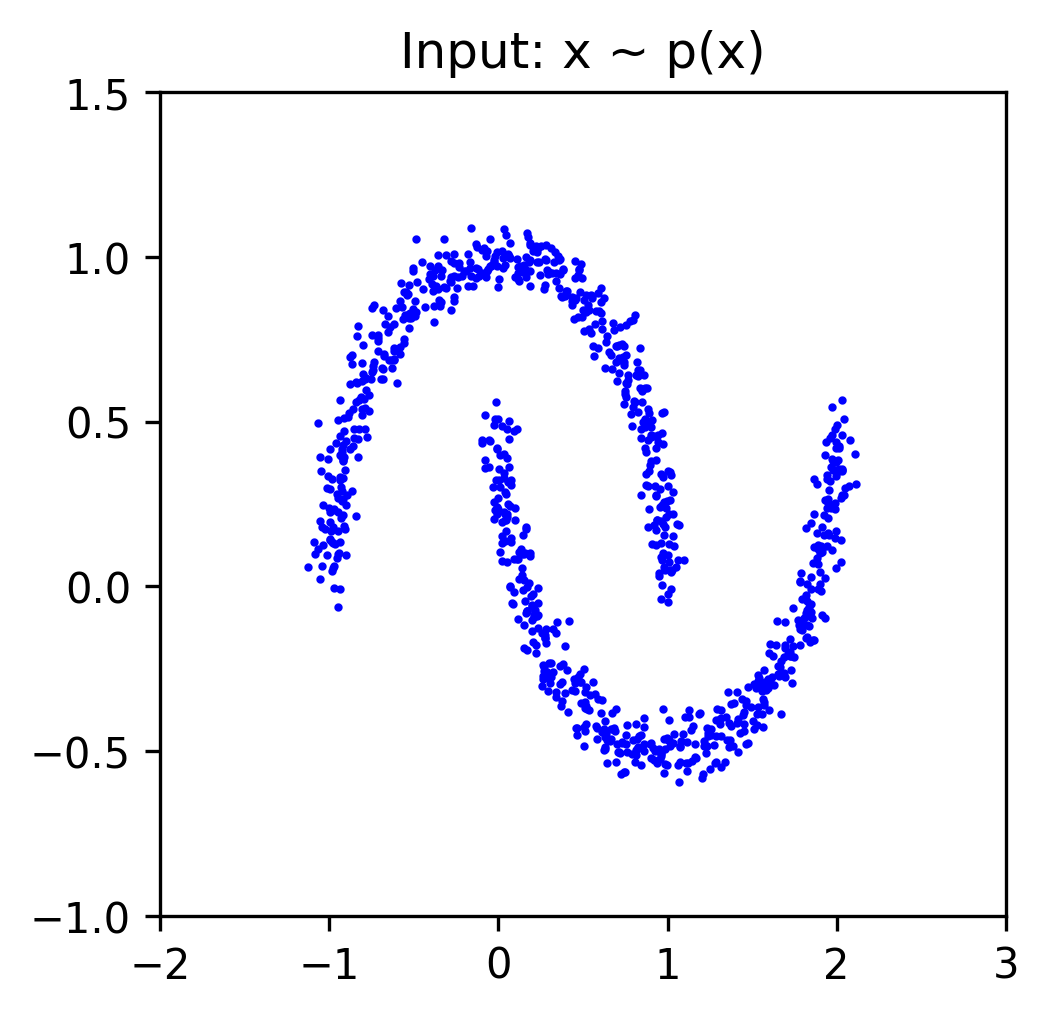

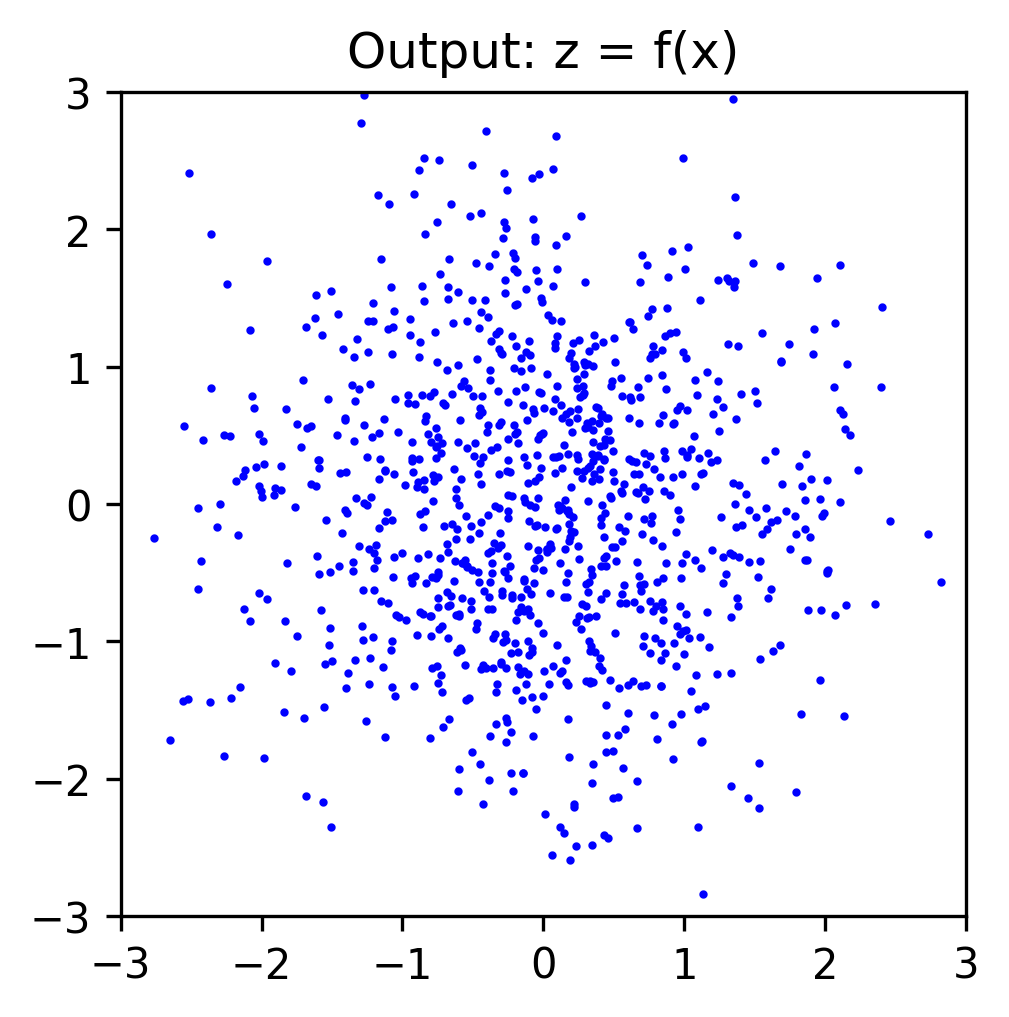

====> Test set loss: -0.0608


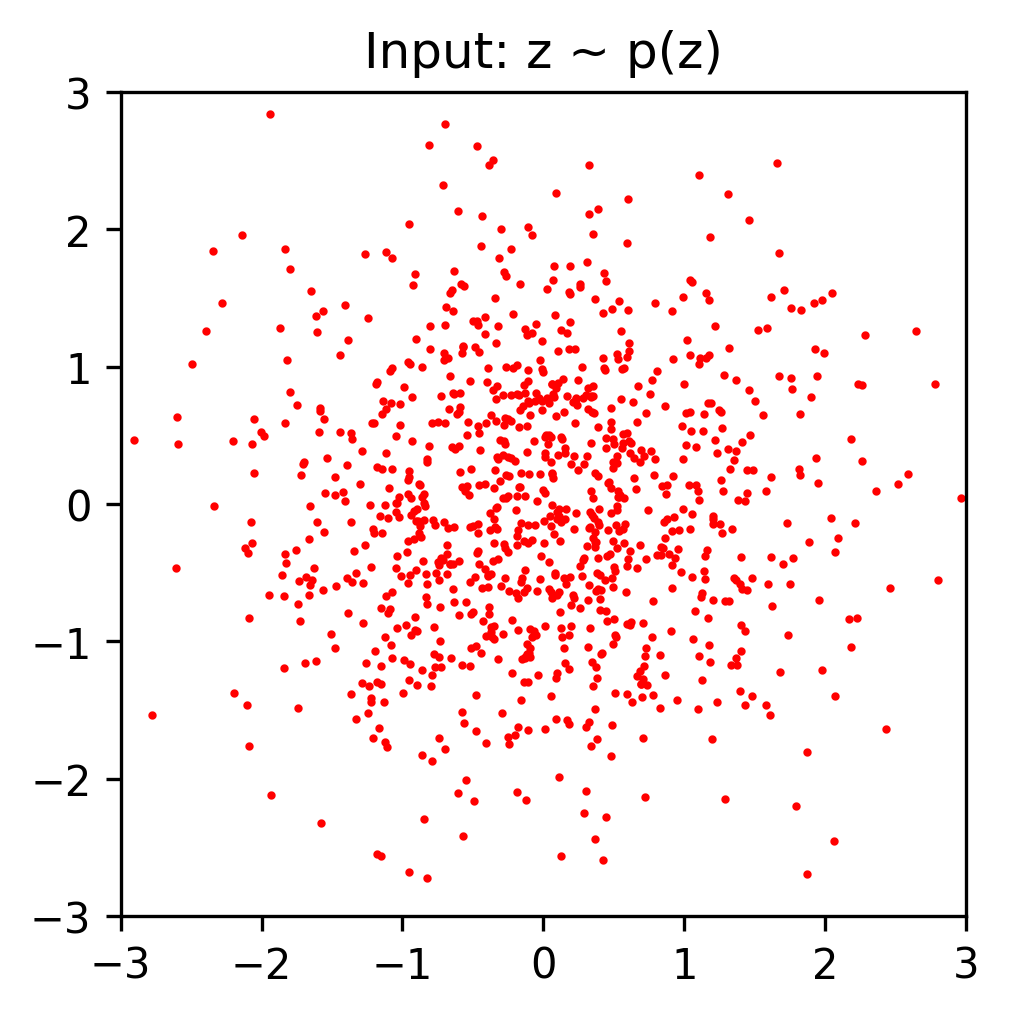

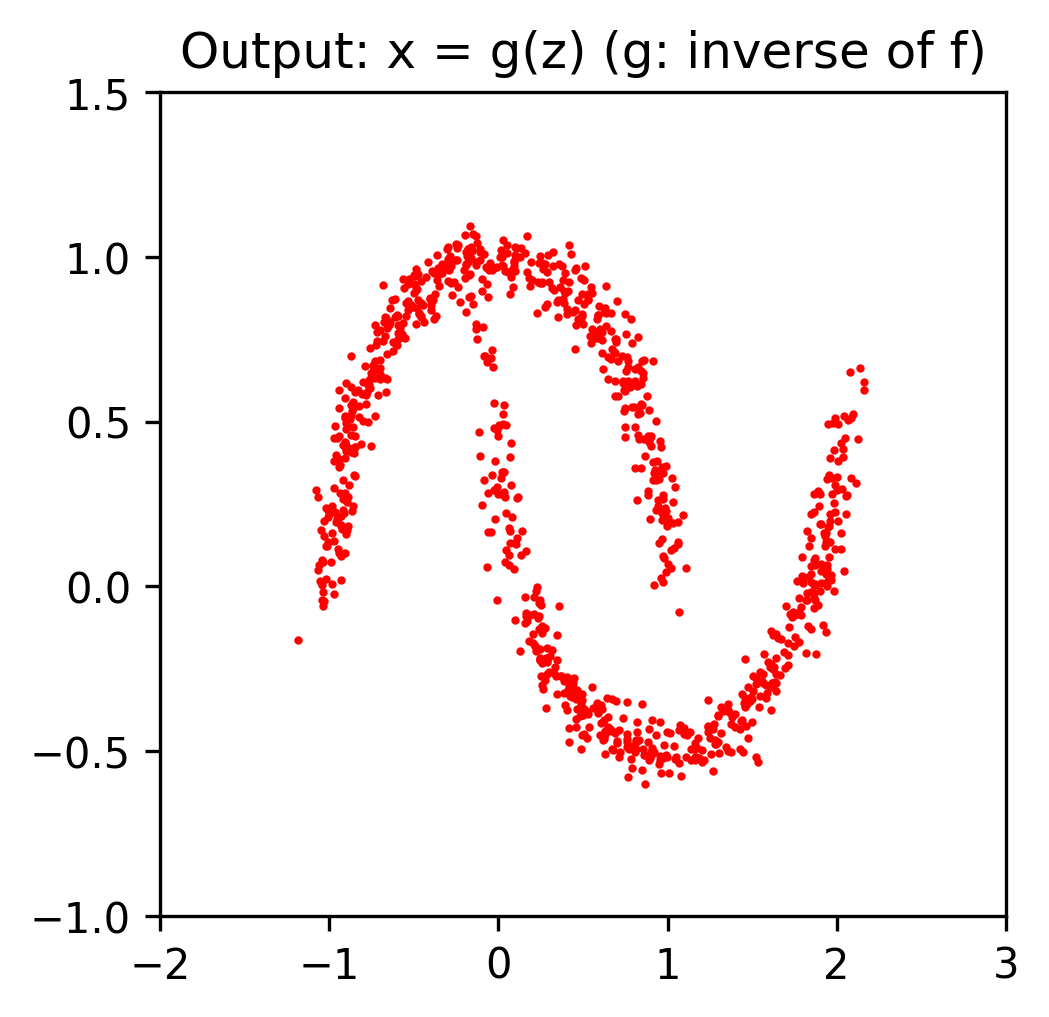

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.059927
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.059121
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.059018
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.059775
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.060281
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.059967
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.059609
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.059835
====> Epoch: 6 Average loss: -0.0596


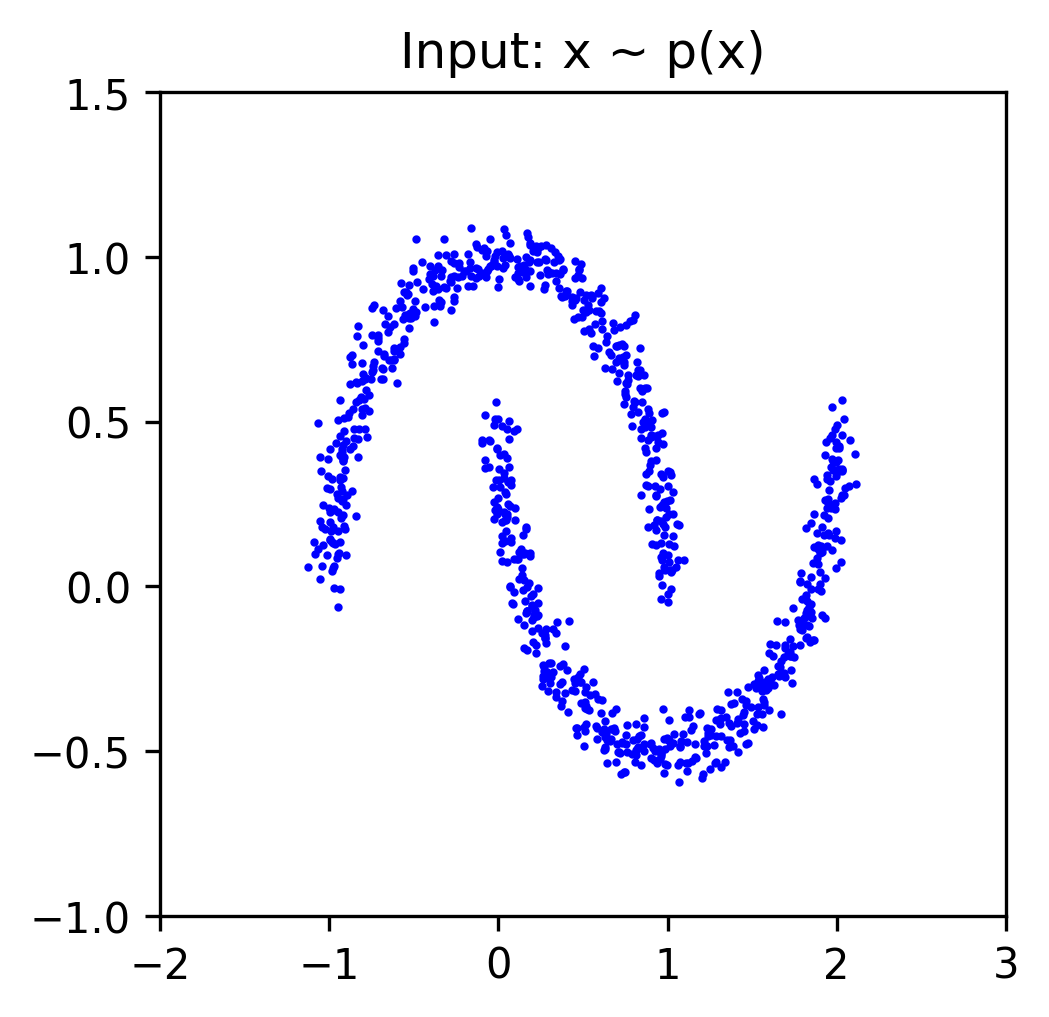

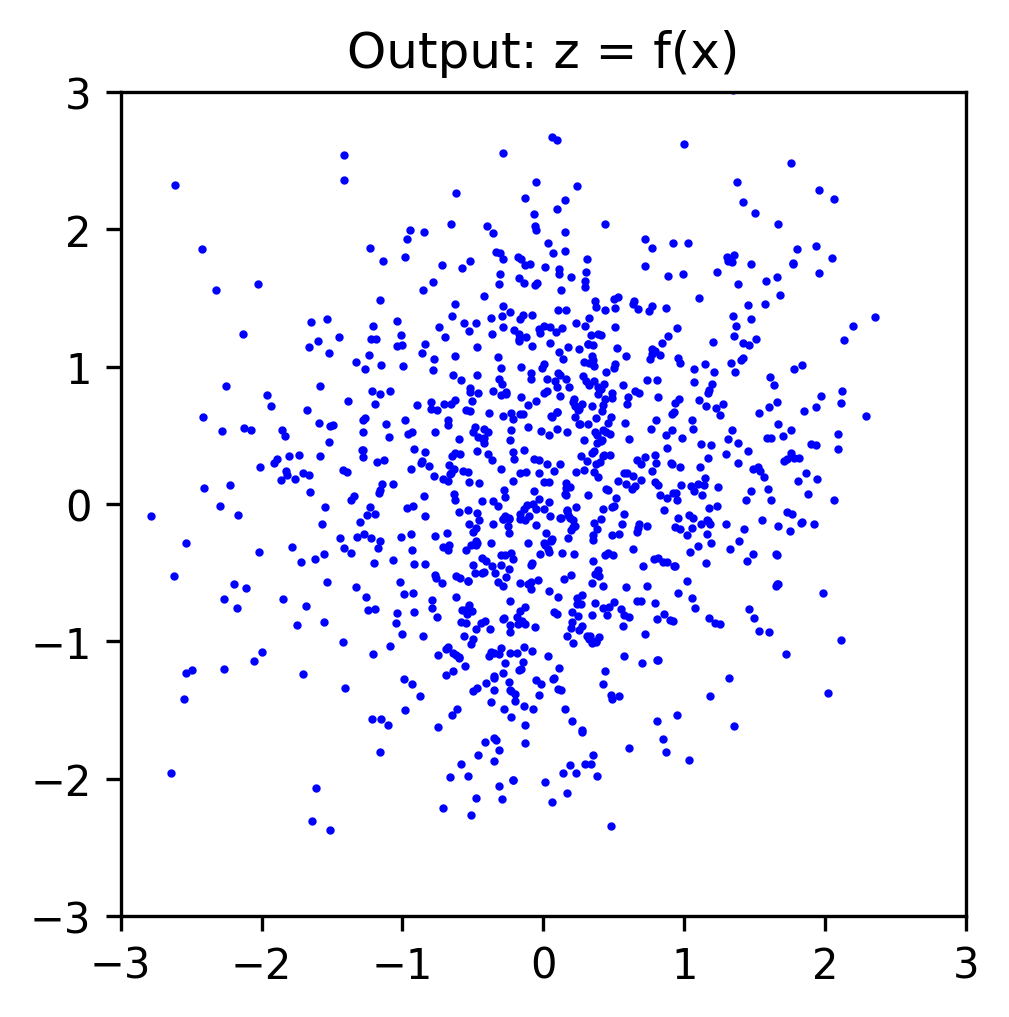

====> Test set loss: -0.0607


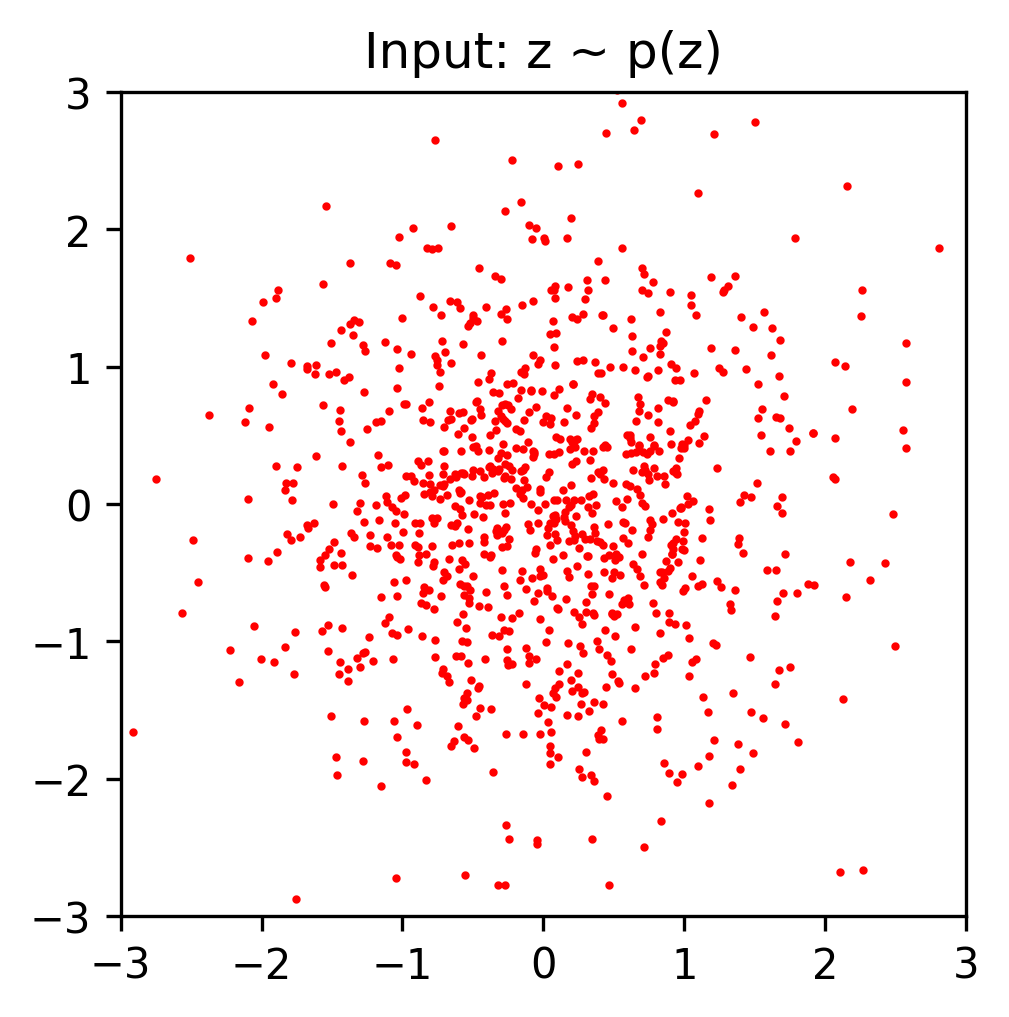

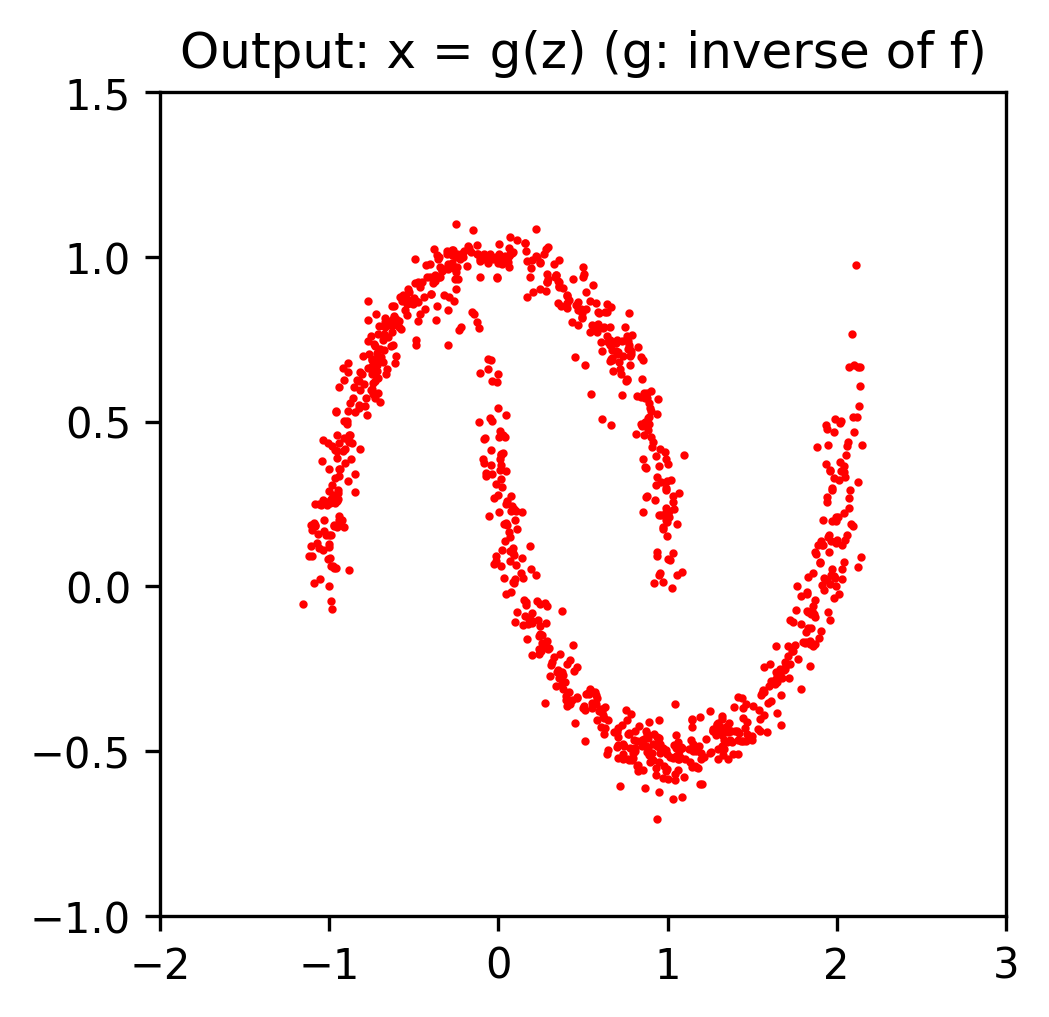

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.058891
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.059603
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.058408
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.060665
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.060053
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.059580
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.059910
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.060458
====> Epoch: 7 Average loss: -0.0596


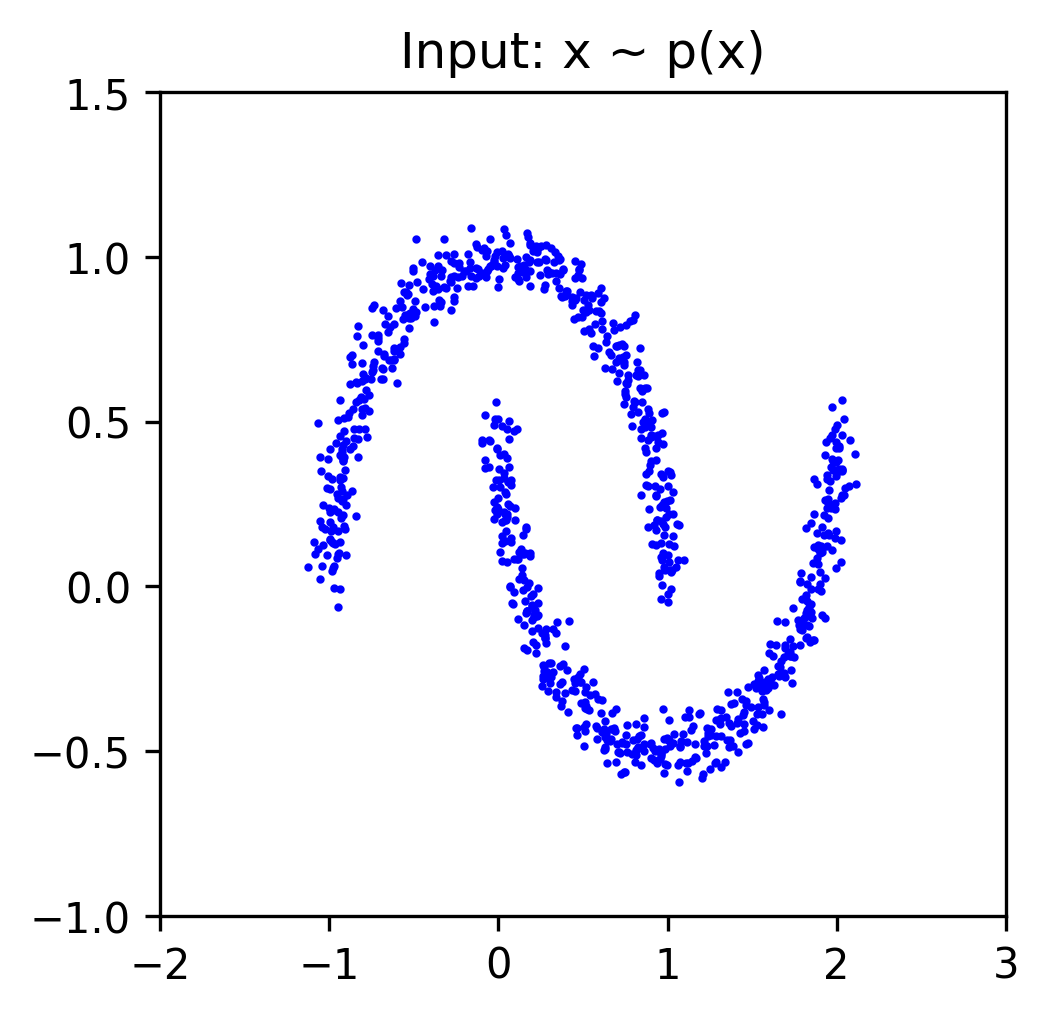

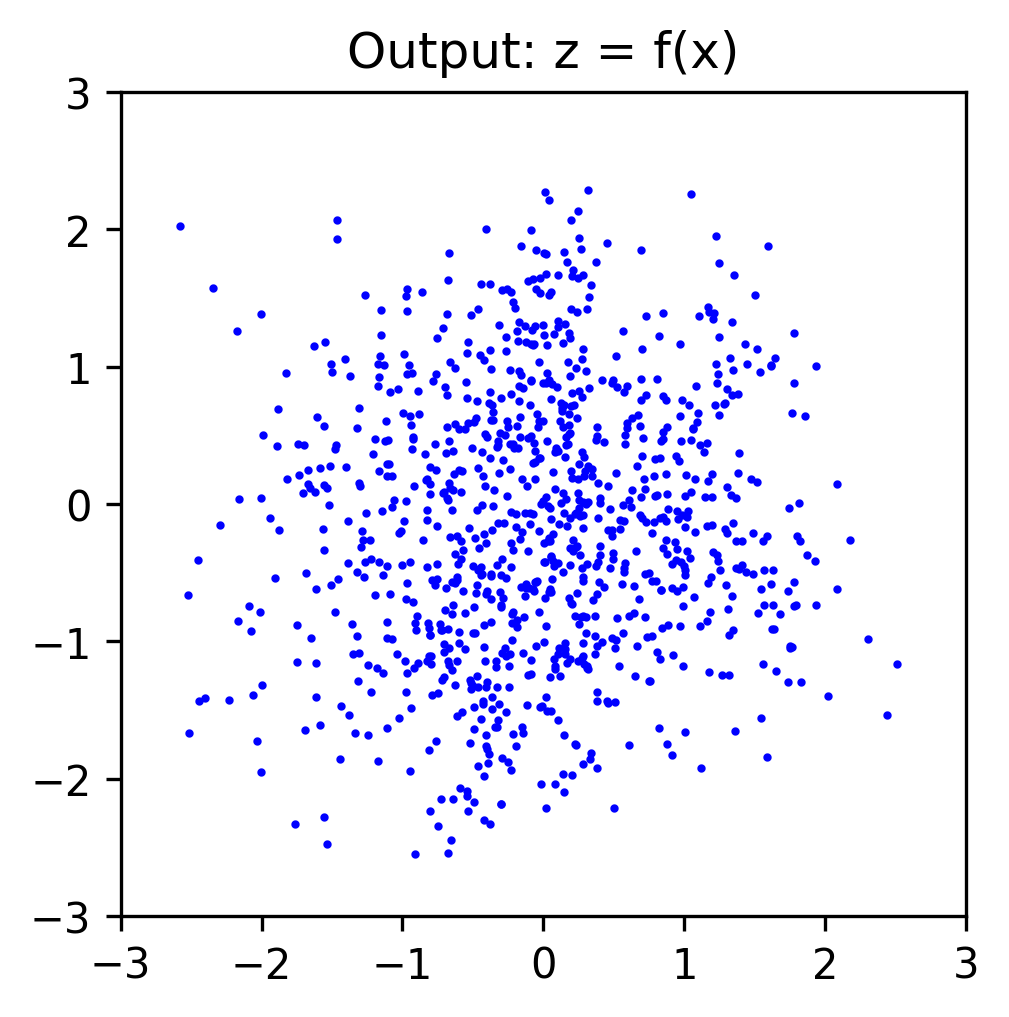

====> Test set loss: -0.0606


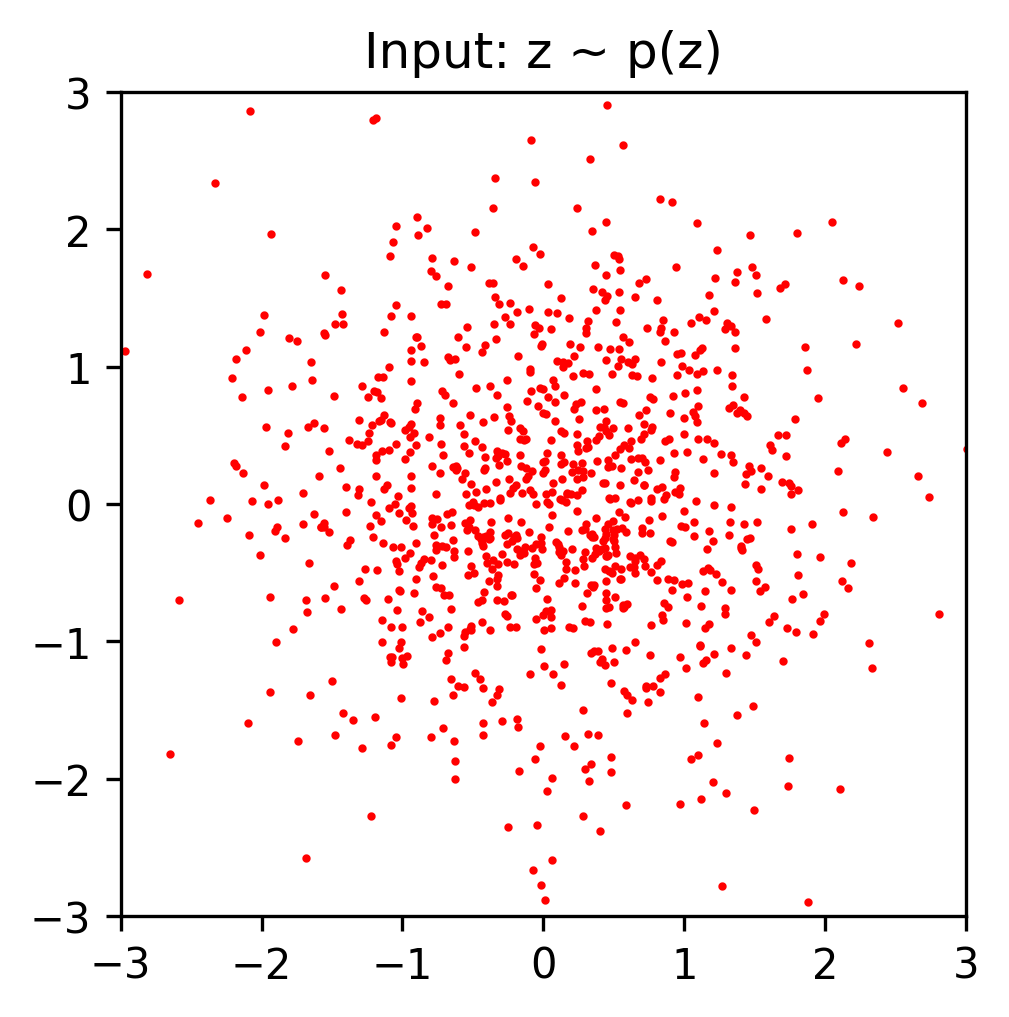

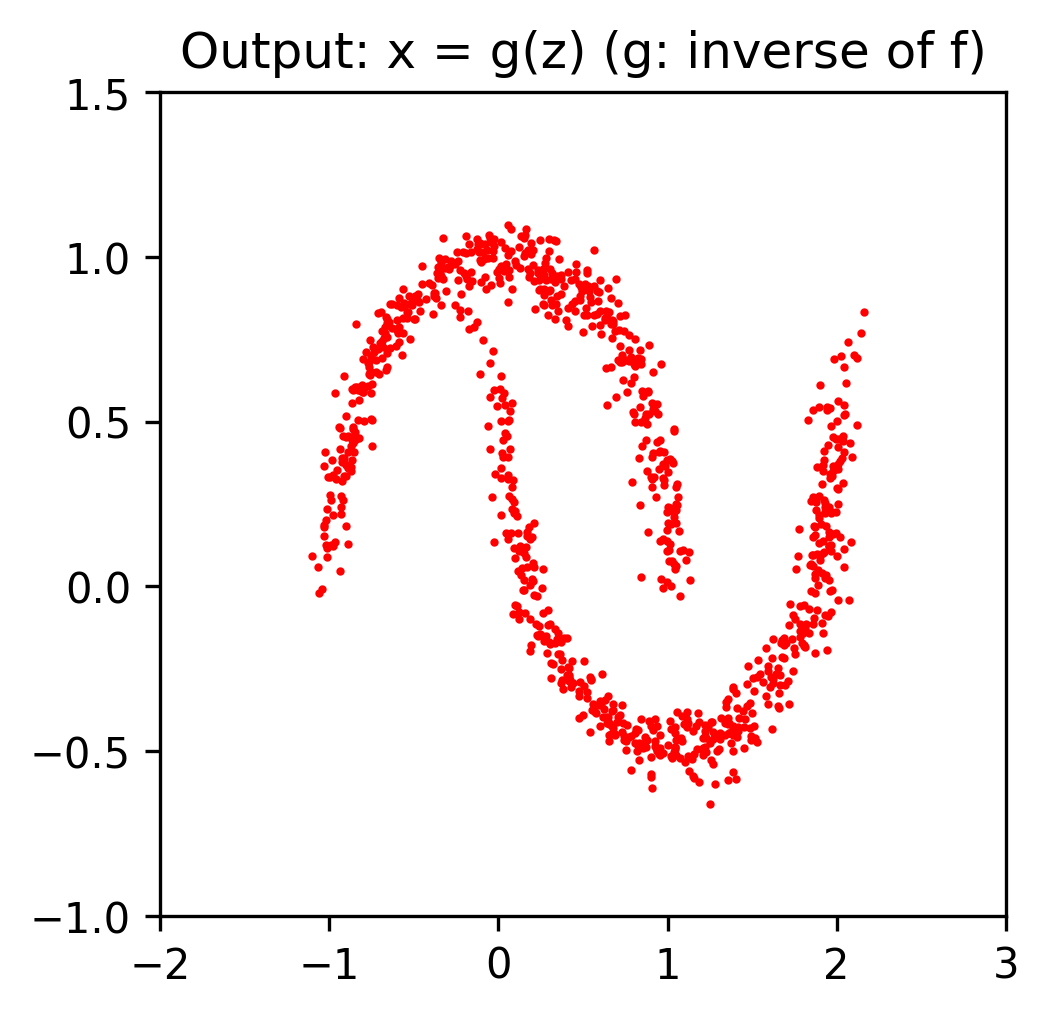

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.059546
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.059789
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.059684
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.060119
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.059381
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.060048
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.059914
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.059714
====> Epoch: 8 Average loss: -0.0596


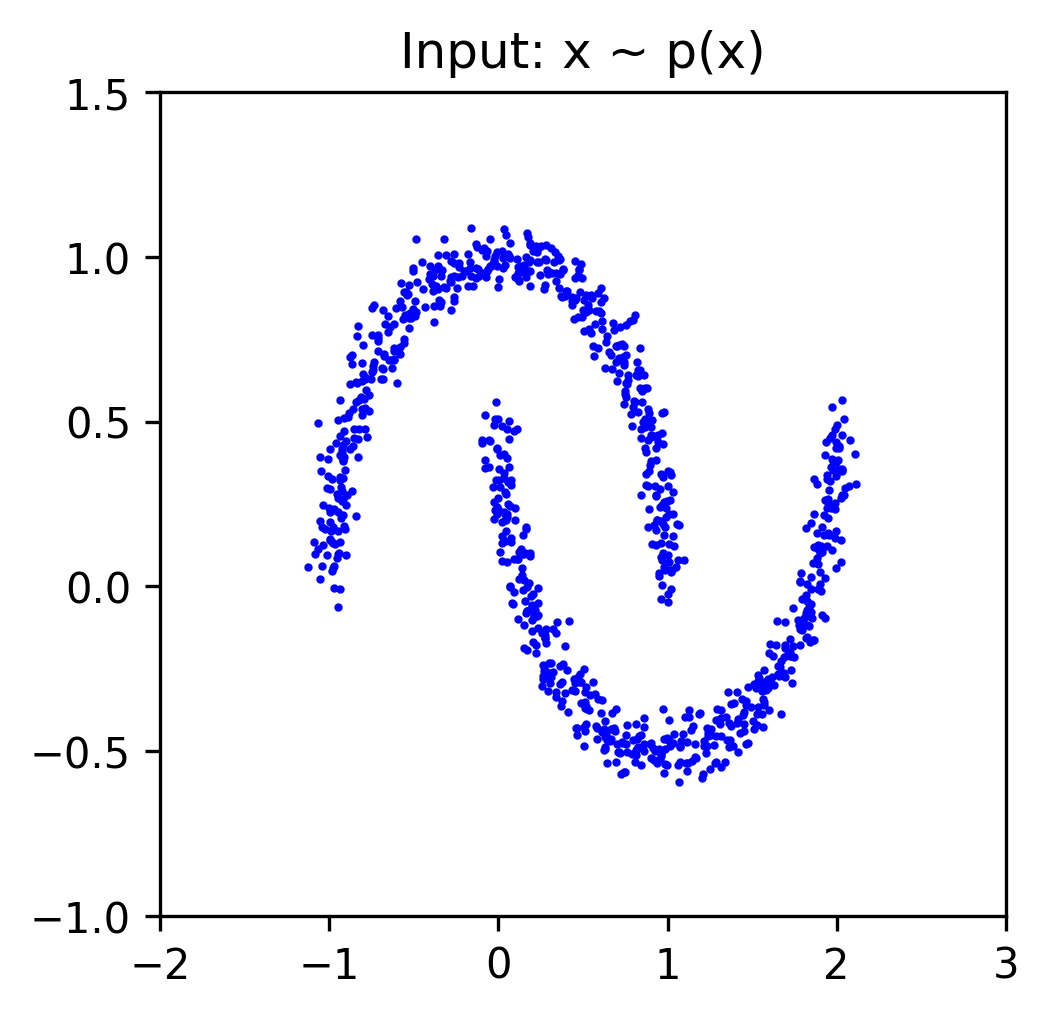

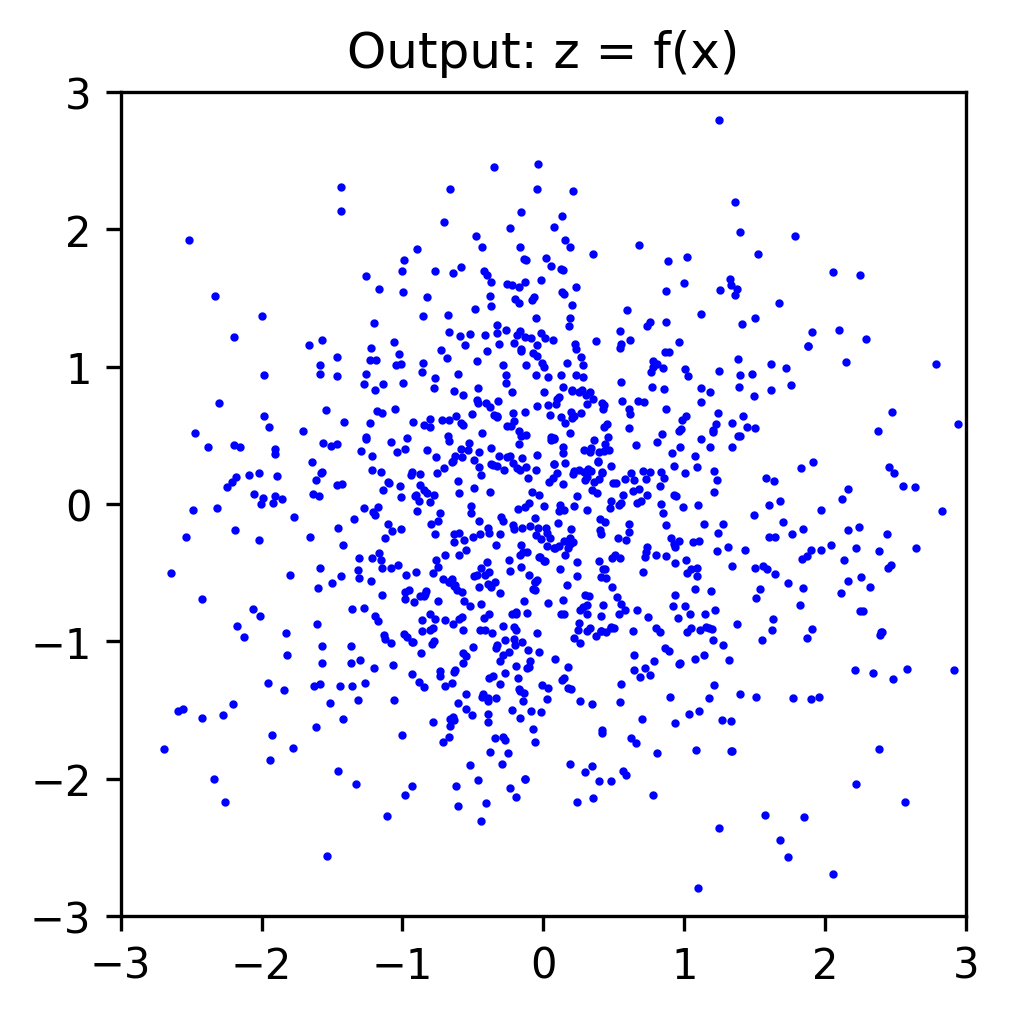

====> Test set loss: -0.0608


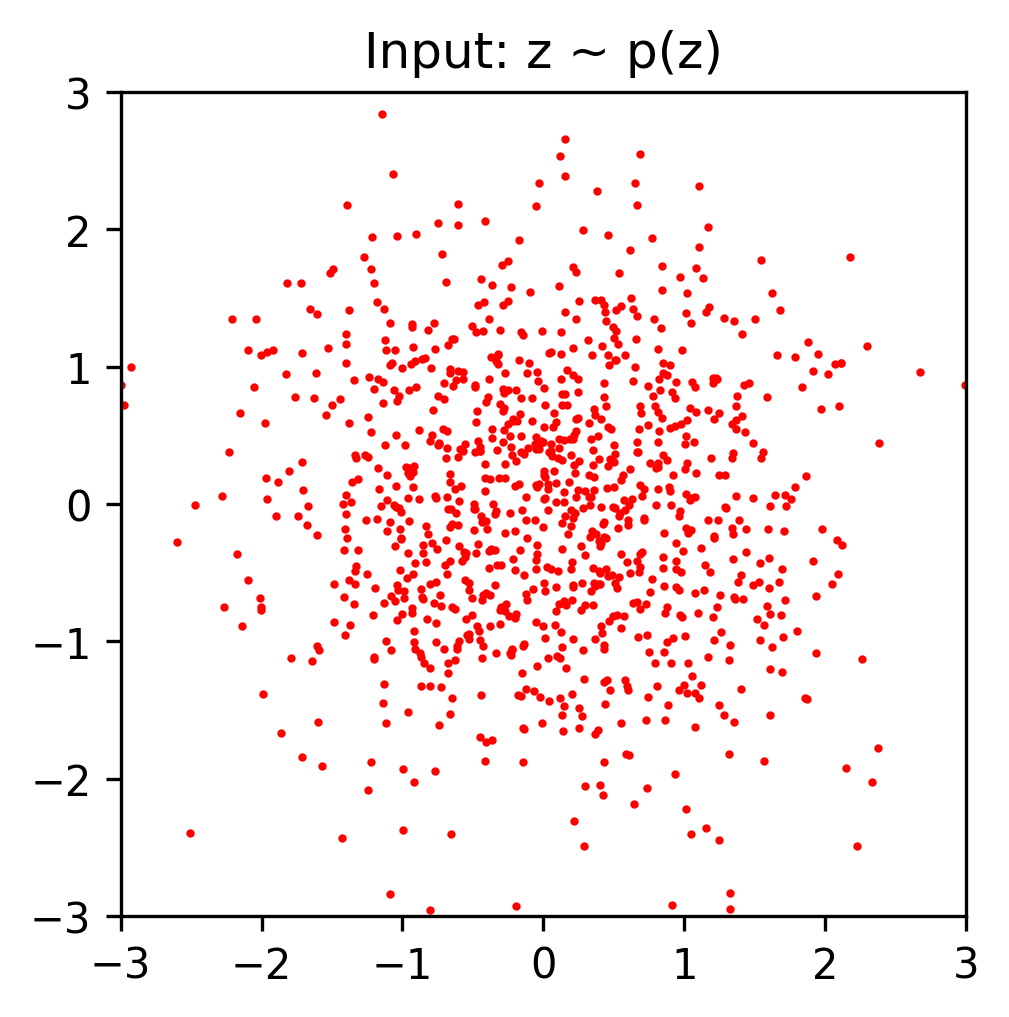

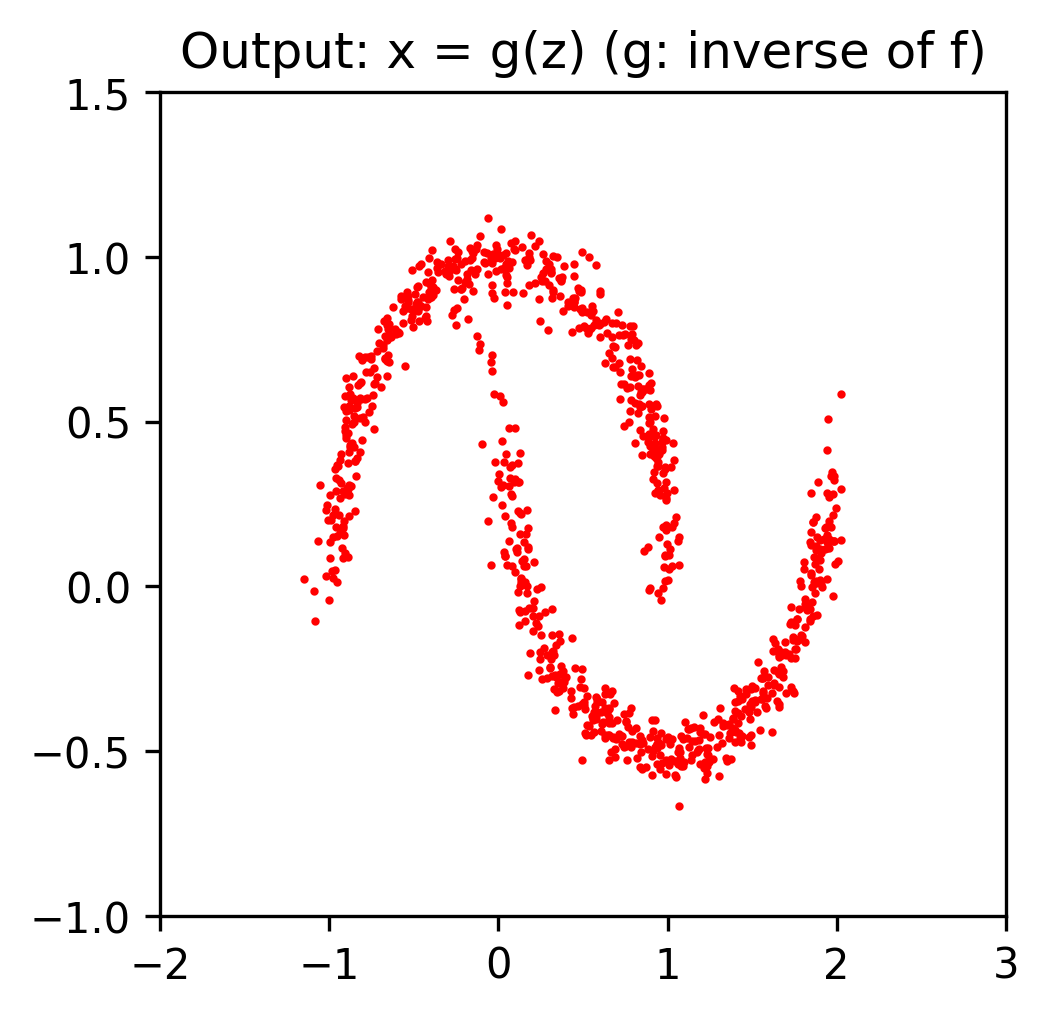

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.059450
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.060146
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.058931
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.059653
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.059675
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.059094
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.059578
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.059910
====> Epoch: 9 Average loss: -0.0596


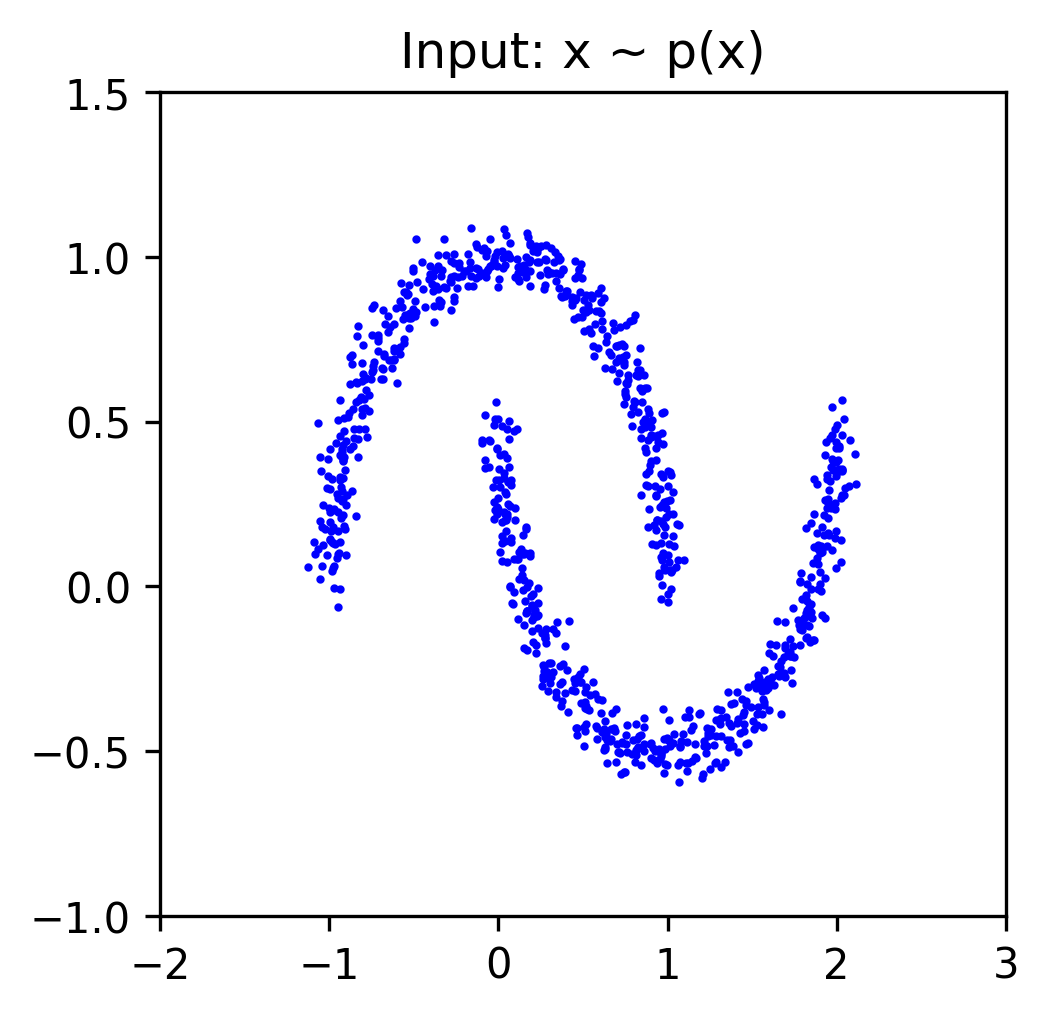

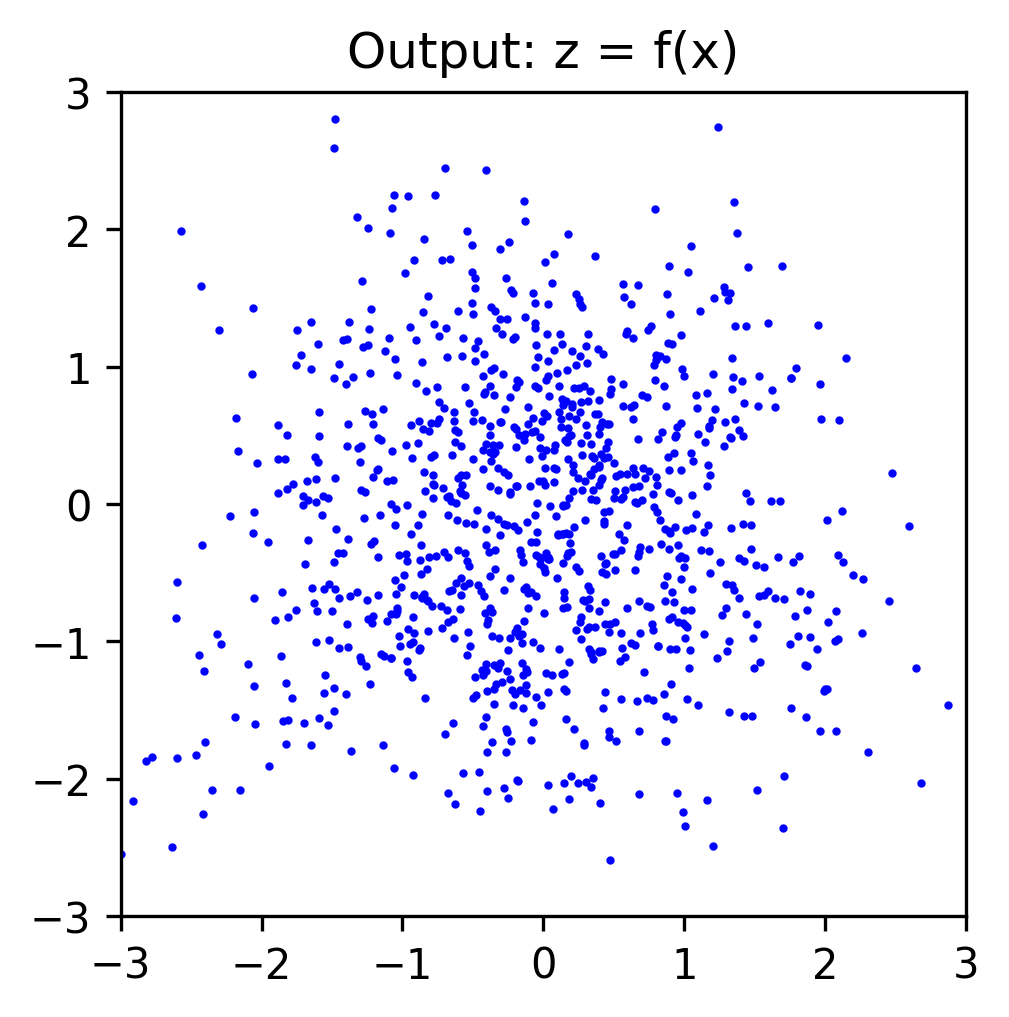

====> Test set loss: -0.0607


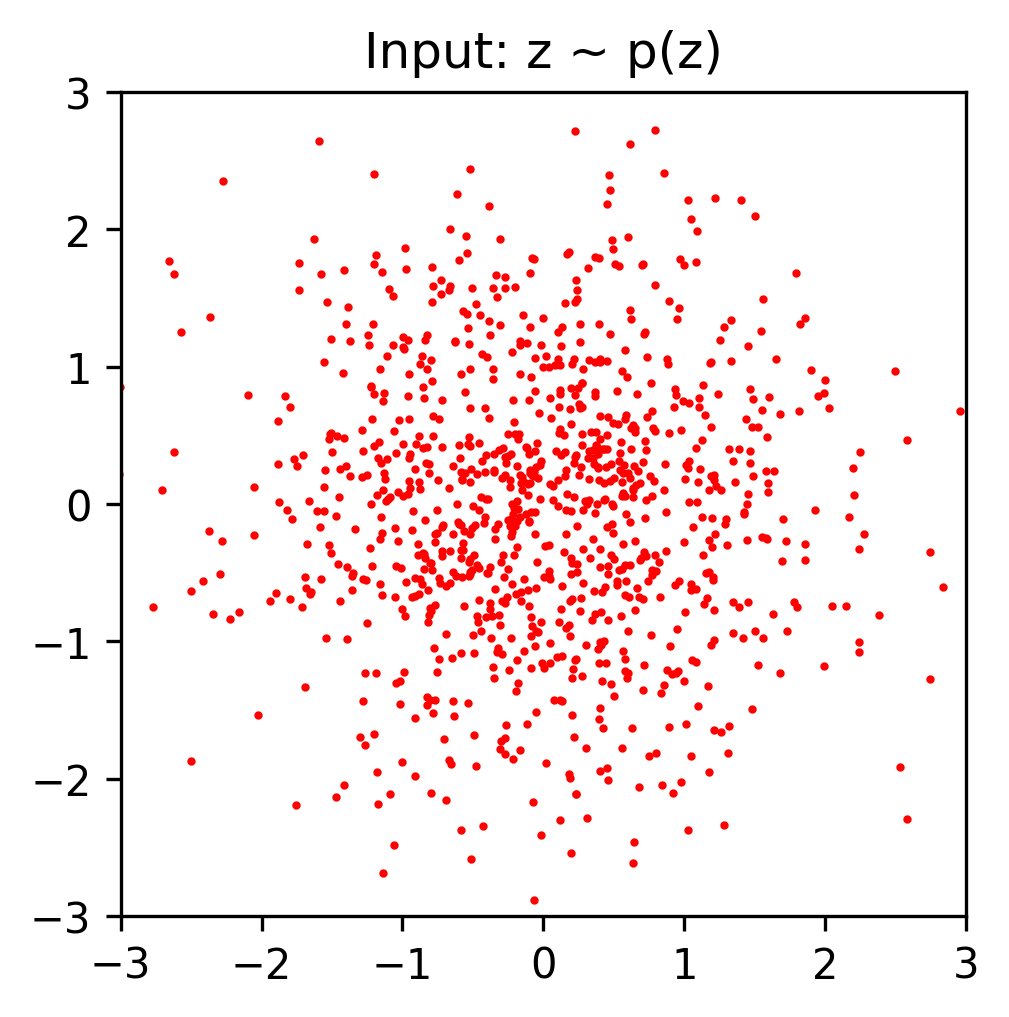

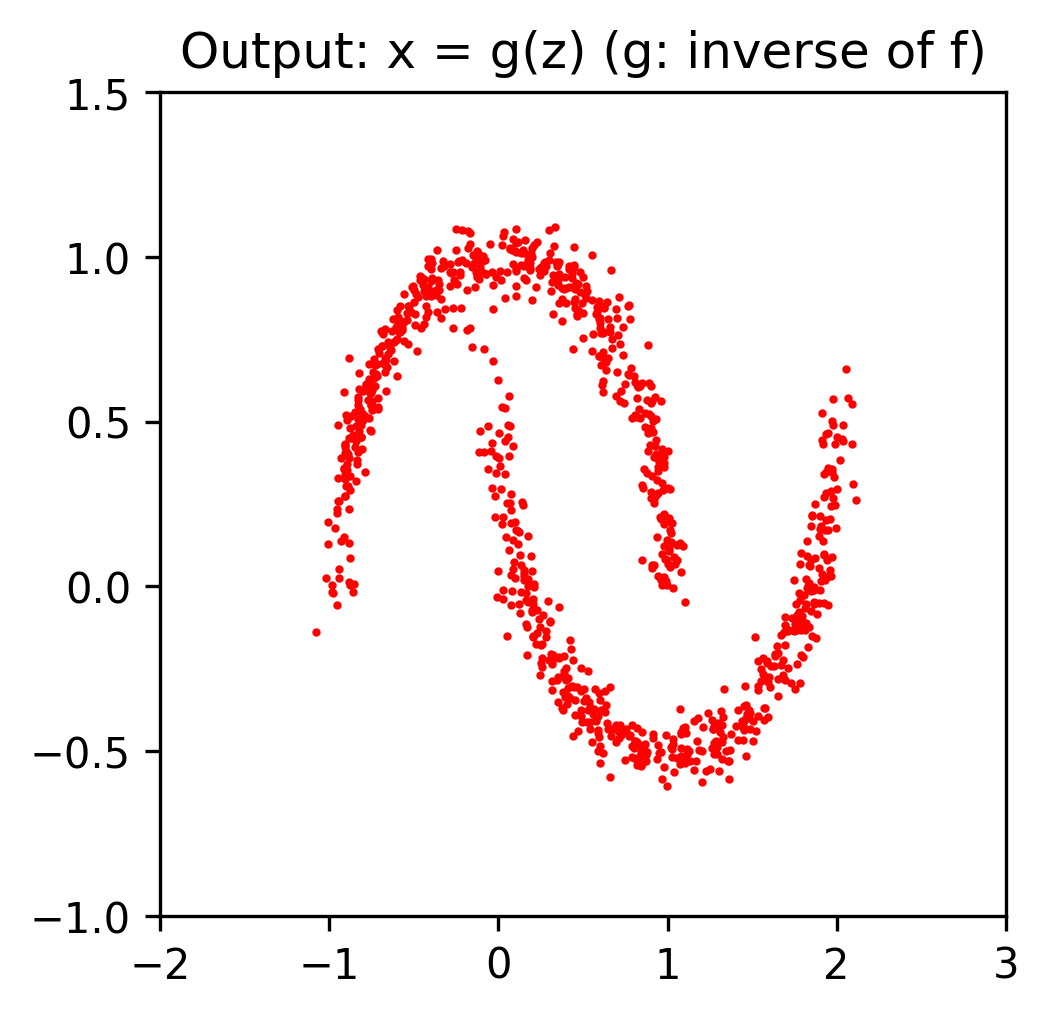

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.059109
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.059035
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.059696
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.060040
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.060173
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.059753
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.060531
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.060354
====> Epoch: 10 Average loss: -0.0597


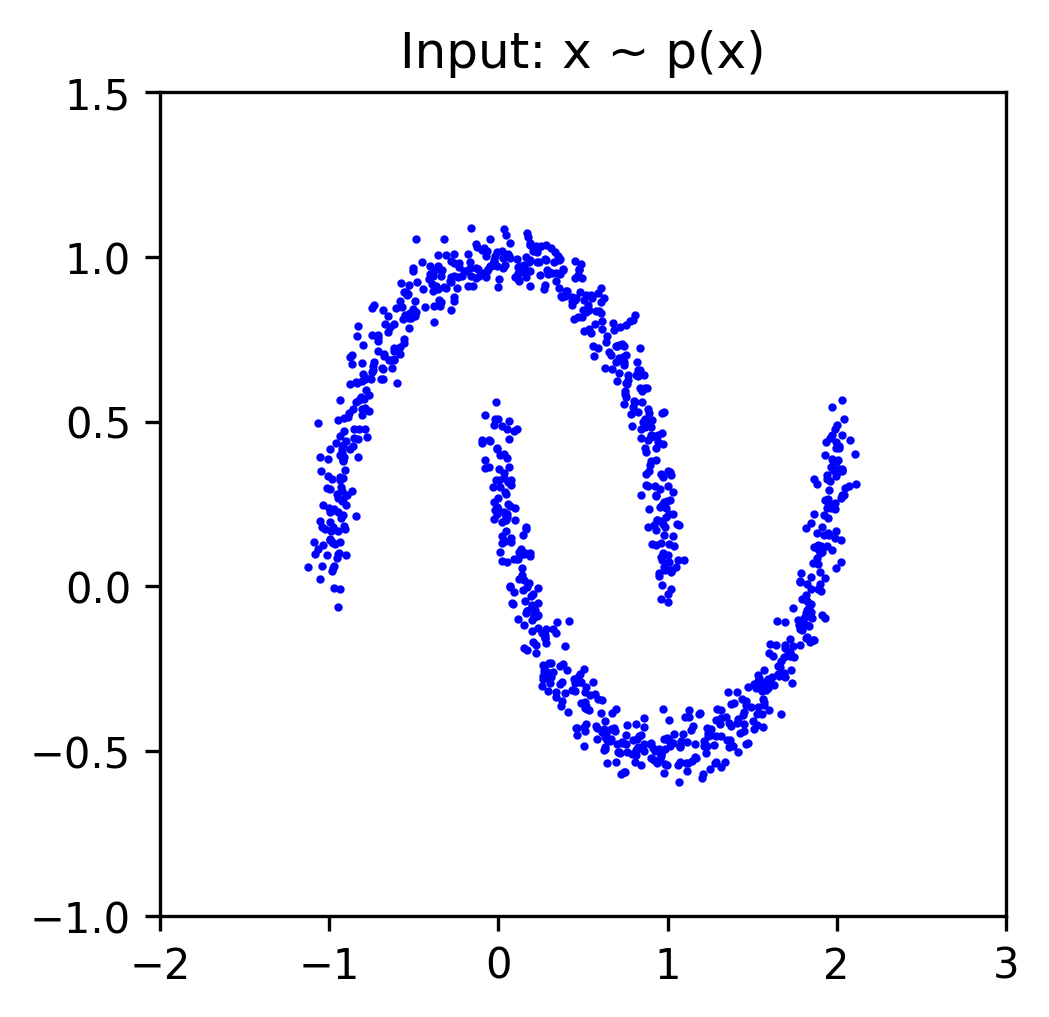

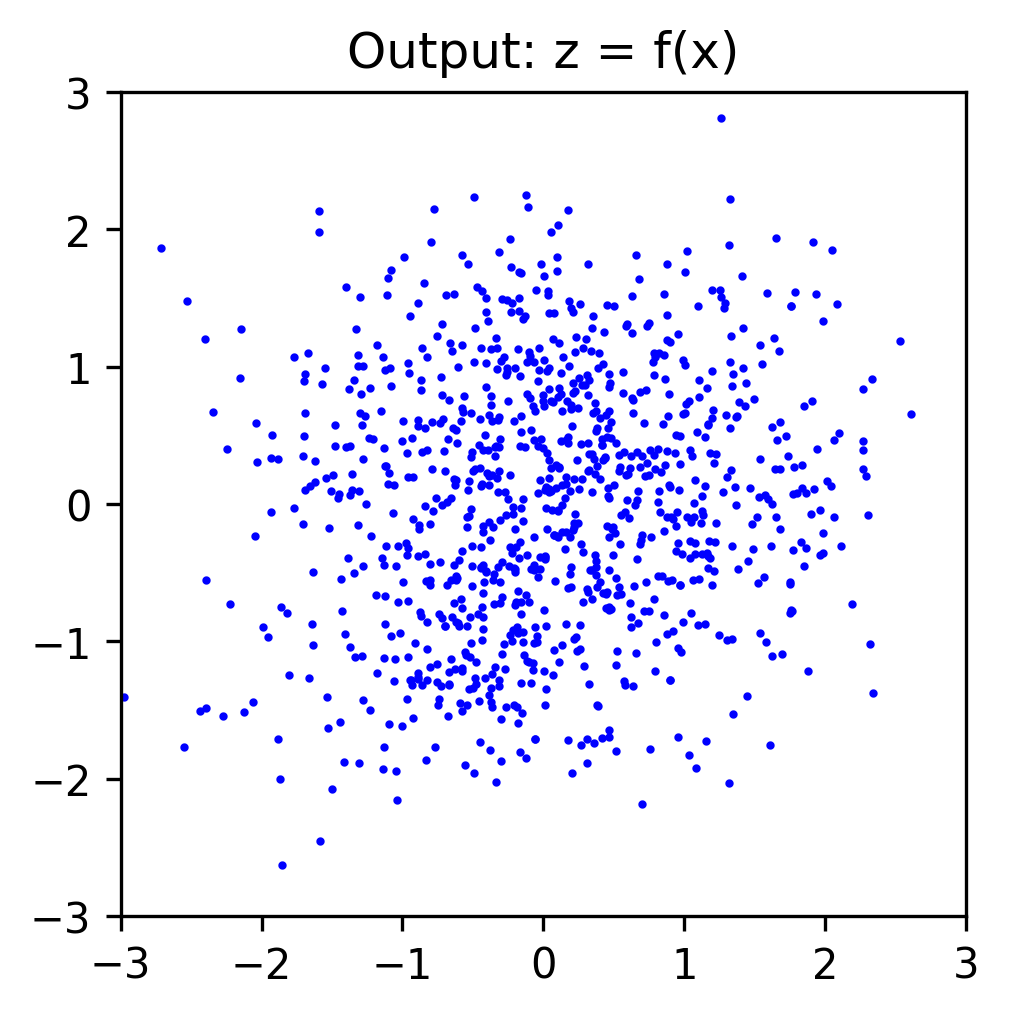

====> Test set loss: -0.0609


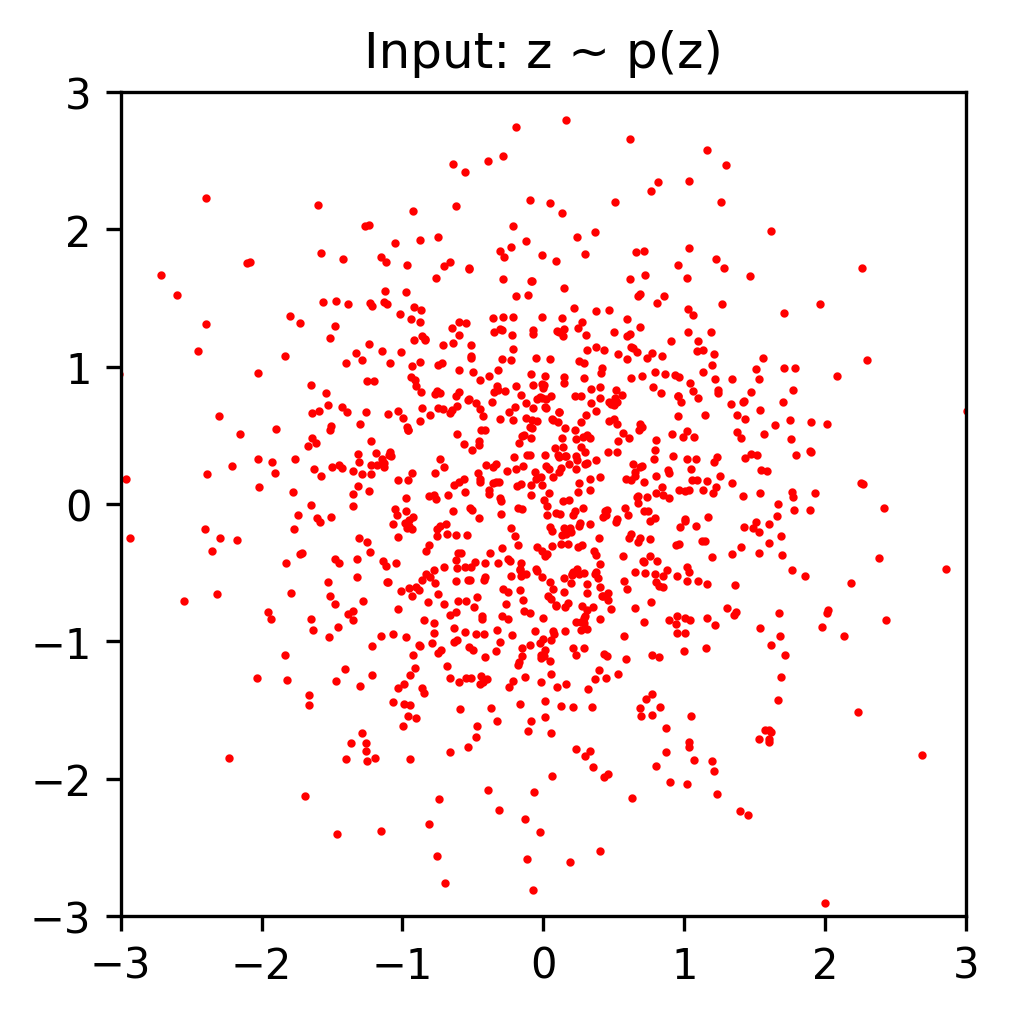

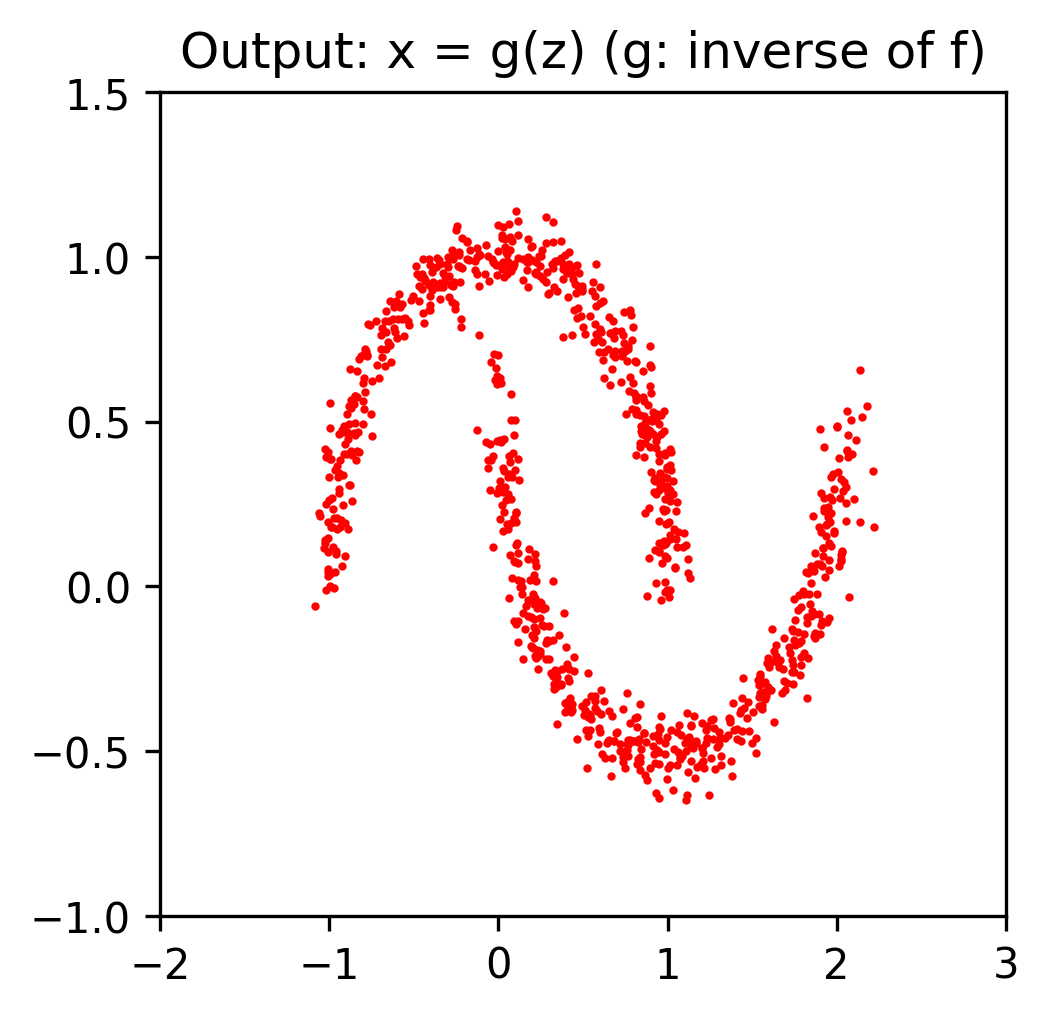

Train Epoch: 11 [0/50000 (0%)]	Loss: -0.060331
Train Epoch: 11 [6400/50000 (13%)]	Loss: -0.058592
Train Epoch: 11 [12800/50000 (26%)]	Loss: -0.059728
Train Epoch: 11 [19200/50000 (38%)]	Loss: -0.059388
Train Epoch: 11 [25600/50000 (51%)]	Loss: -0.059564
Train Epoch: 11 [32000/50000 (64%)]	Loss: -0.059742
Train Epoch: 11 [38400/50000 (77%)]	Loss: -0.060721
Train Epoch: 11 [44800/50000 (90%)]	Loss: -0.060163
====> Epoch: 11 Average loss: -0.0597


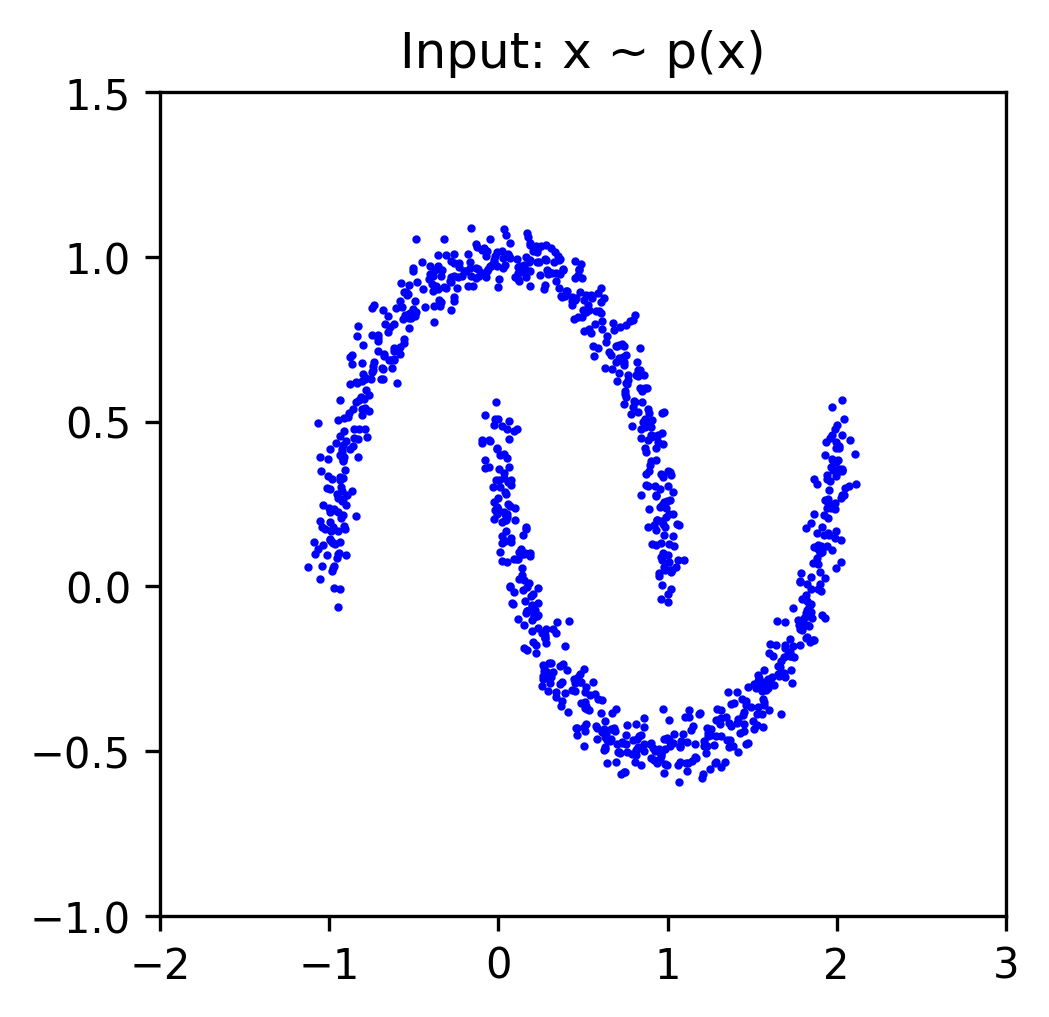

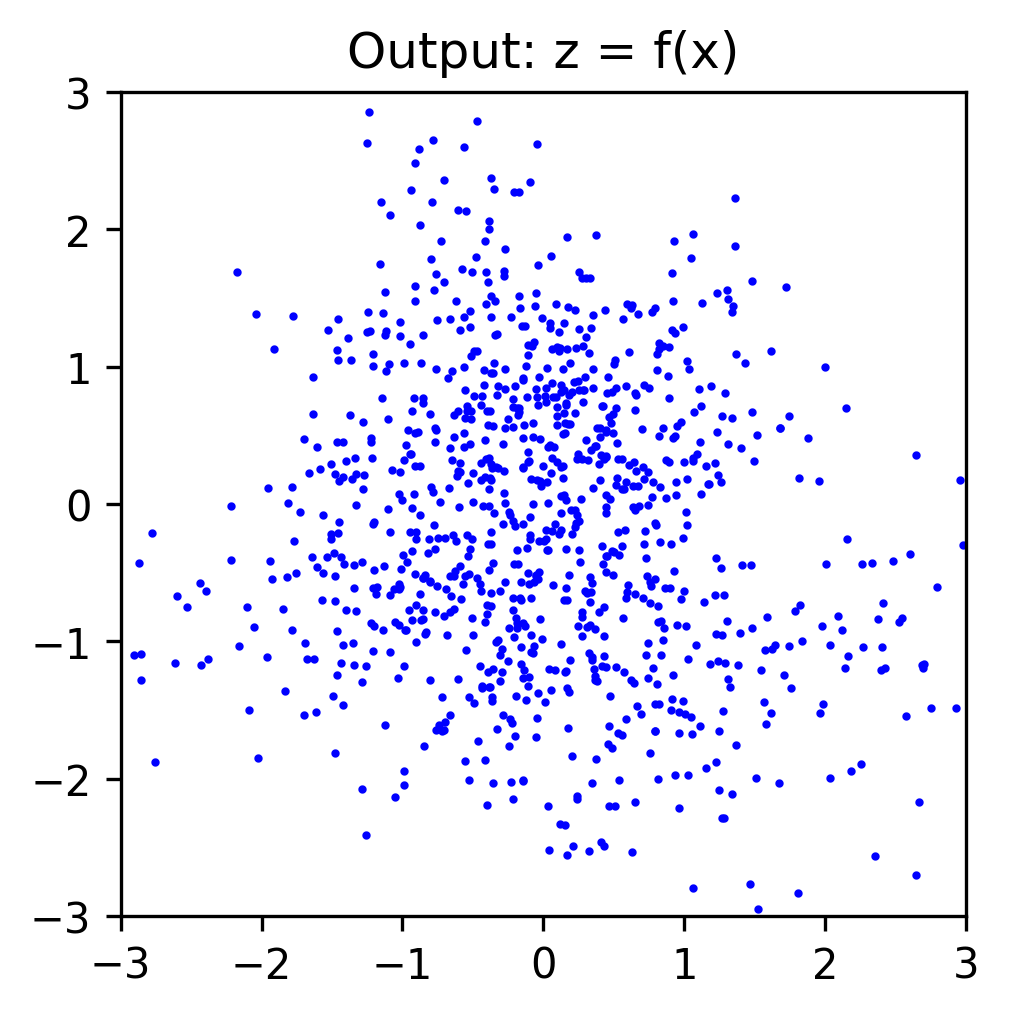

====> Test set loss: -0.0604


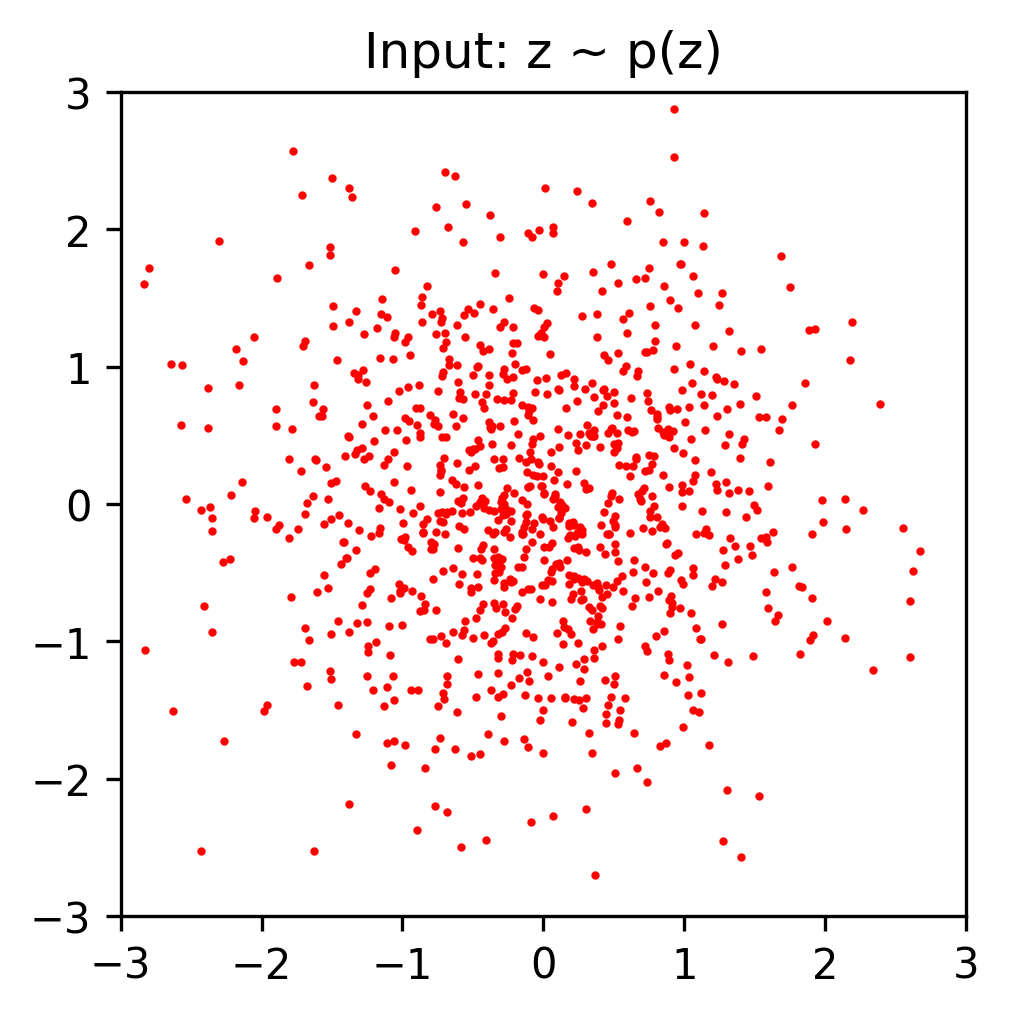

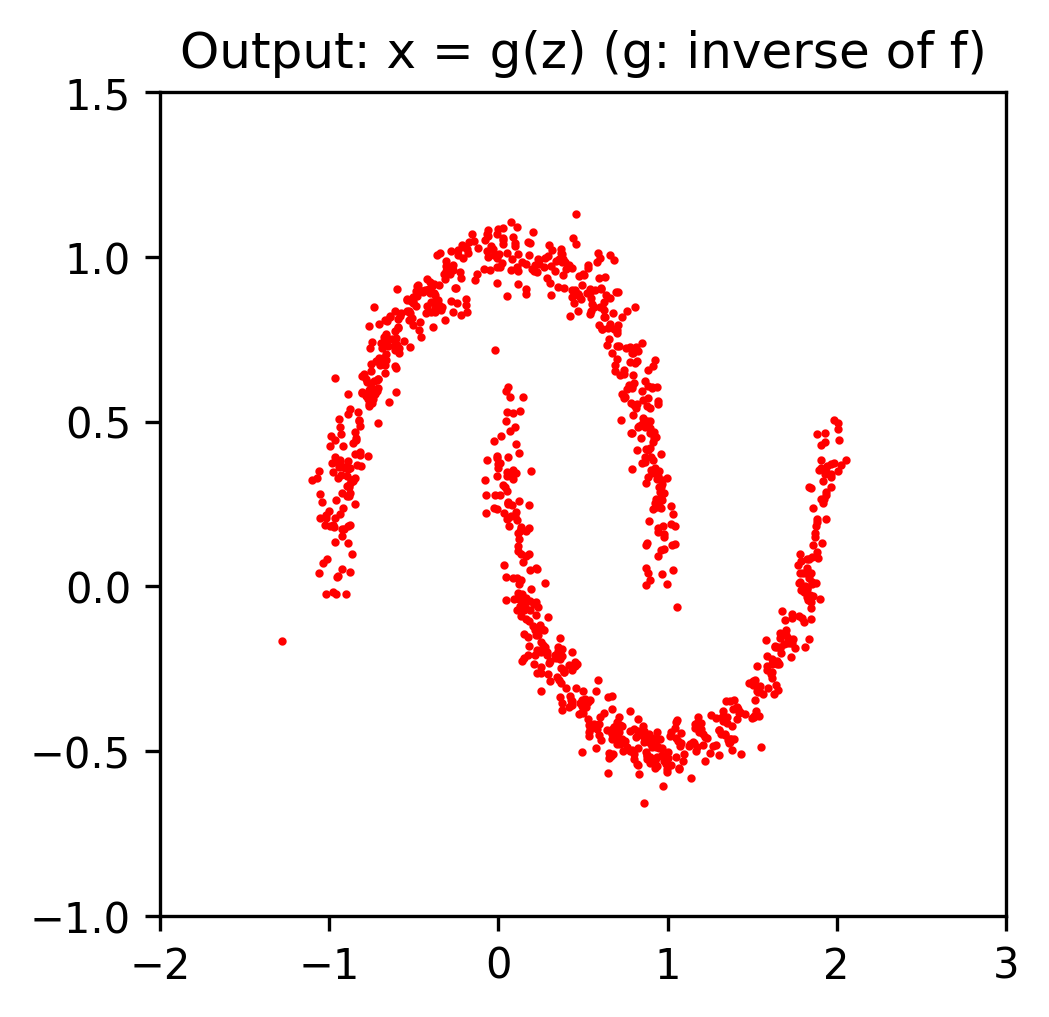

Train Epoch: 12 [0/50000 (0%)]	Loss: -0.058766
Train Epoch: 12 [6400/50000 (13%)]	Loss: -0.058834
Train Epoch: 12 [12800/50000 (26%)]	Loss: -0.059626
Train Epoch: 12 [19200/50000 (38%)]	Loss: -0.059803
Train Epoch: 12 [25600/50000 (51%)]	Loss: -0.059847
Train Epoch: 12 [32000/50000 (64%)]	Loss: -0.059709
Train Epoch: 12 [38400/50000 (77%)]	Loss: -0.058159
Train Epoch: 12 [44800/50000 (90%)]	Loss: -0.059198
====> Epoch: 12 Average loss: -0.0597


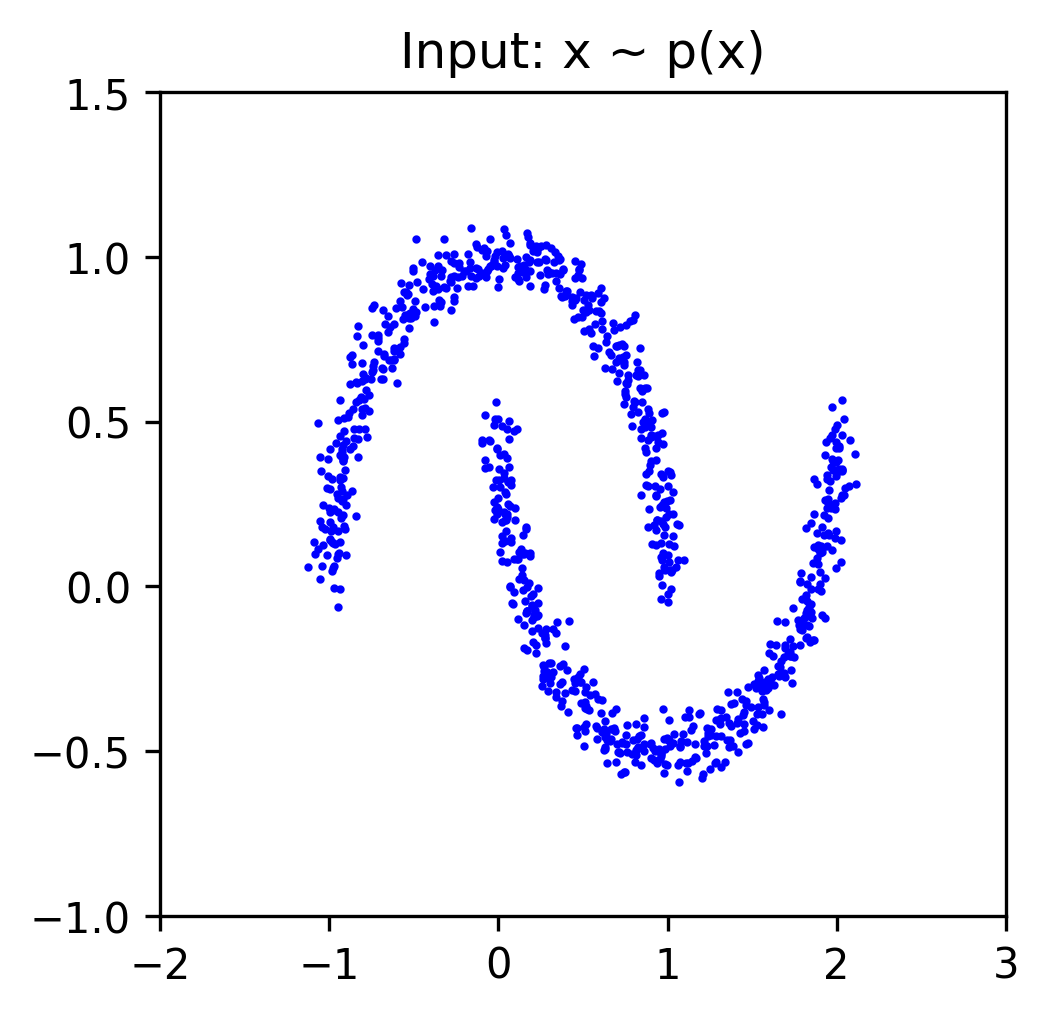

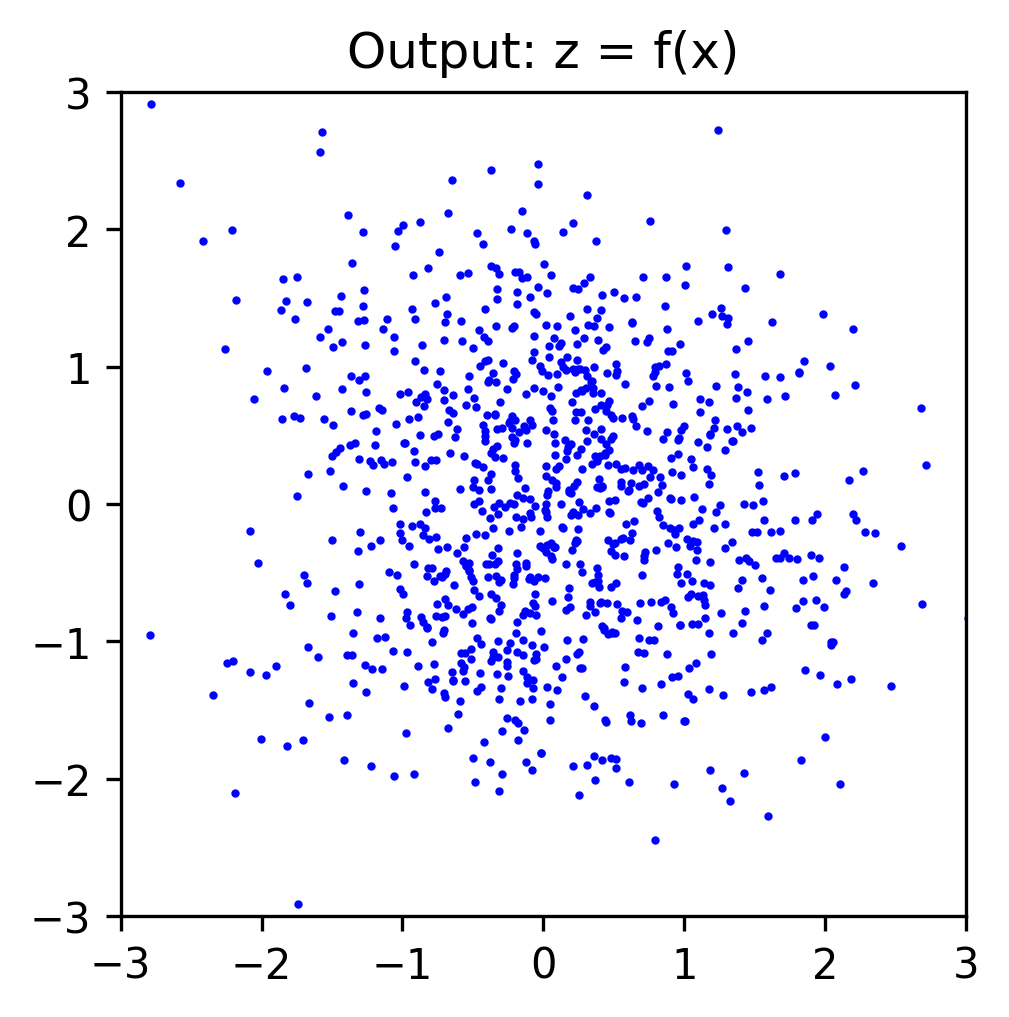

====> Test set loss: -0.0609


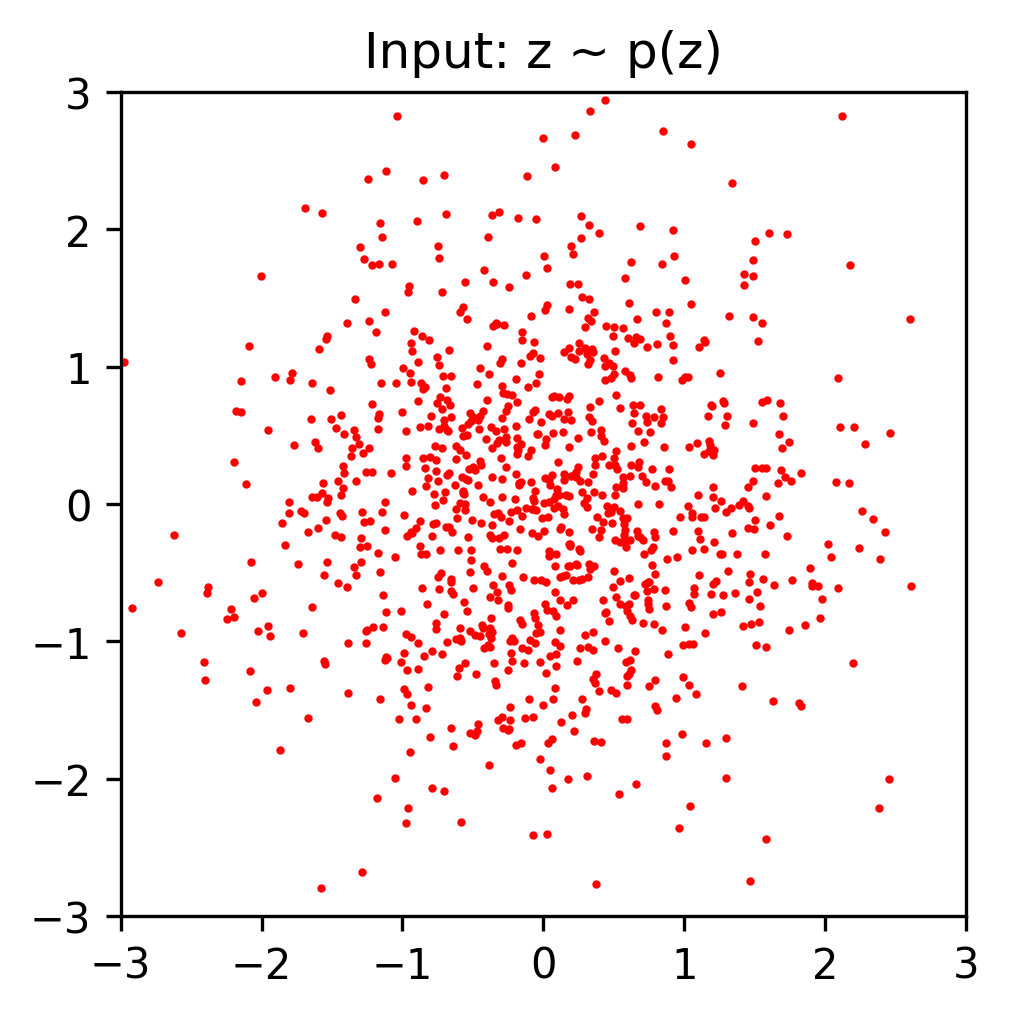

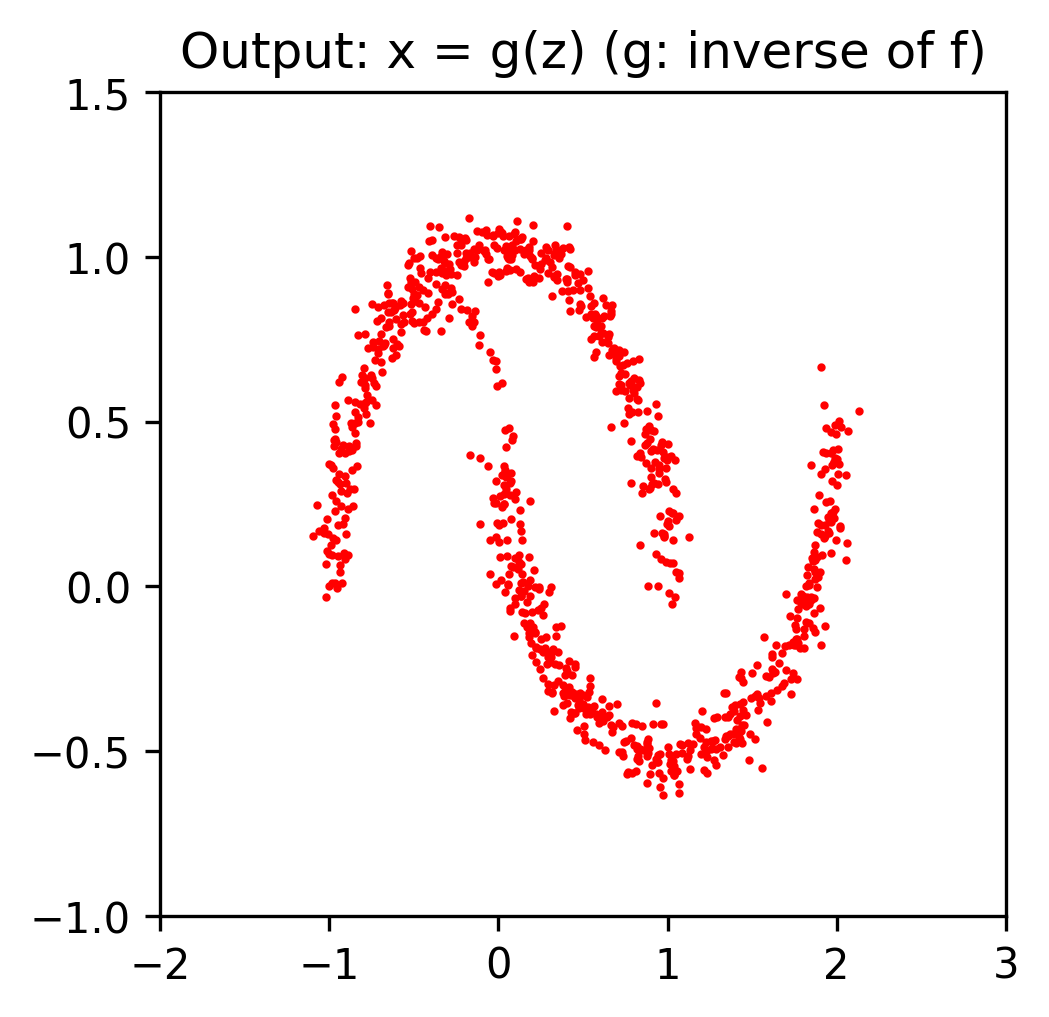

Train Epoch: 13 [0/50000 (0%)]	Loss: -0.058069
Train Epoch: 13 [6400/50000 (13%)]	Loss: -0.059348
Train Epoch: 13 [12800/50000 (26%)]	Loss: -0.059661
Train Epoch: 13 [19200/50000 (38%)]	Loss: -0.059764
Train Epoch: 13 [25600/50000 (51%)]	Loss: -0.059231
Train Epoch: 13 [32000/50000 (64%)]	Loss: -0.060445
Train Epoch: 13 [38400/50000 (77%)]	Loss: -0.059007
Train Epoch: 13 [44800/50000 (90%)]	Loss: -0.060243
====> Epoch: 13 Average loss: -0.0598


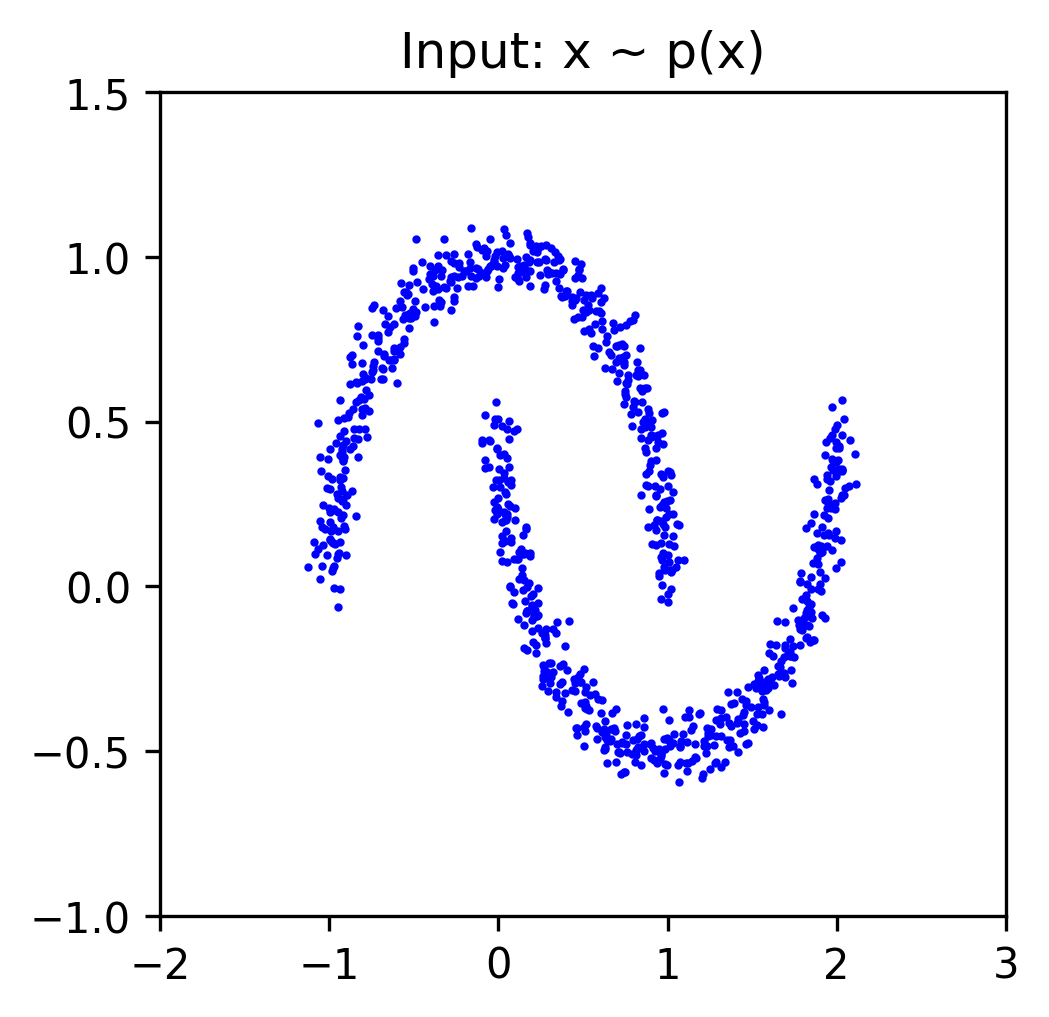

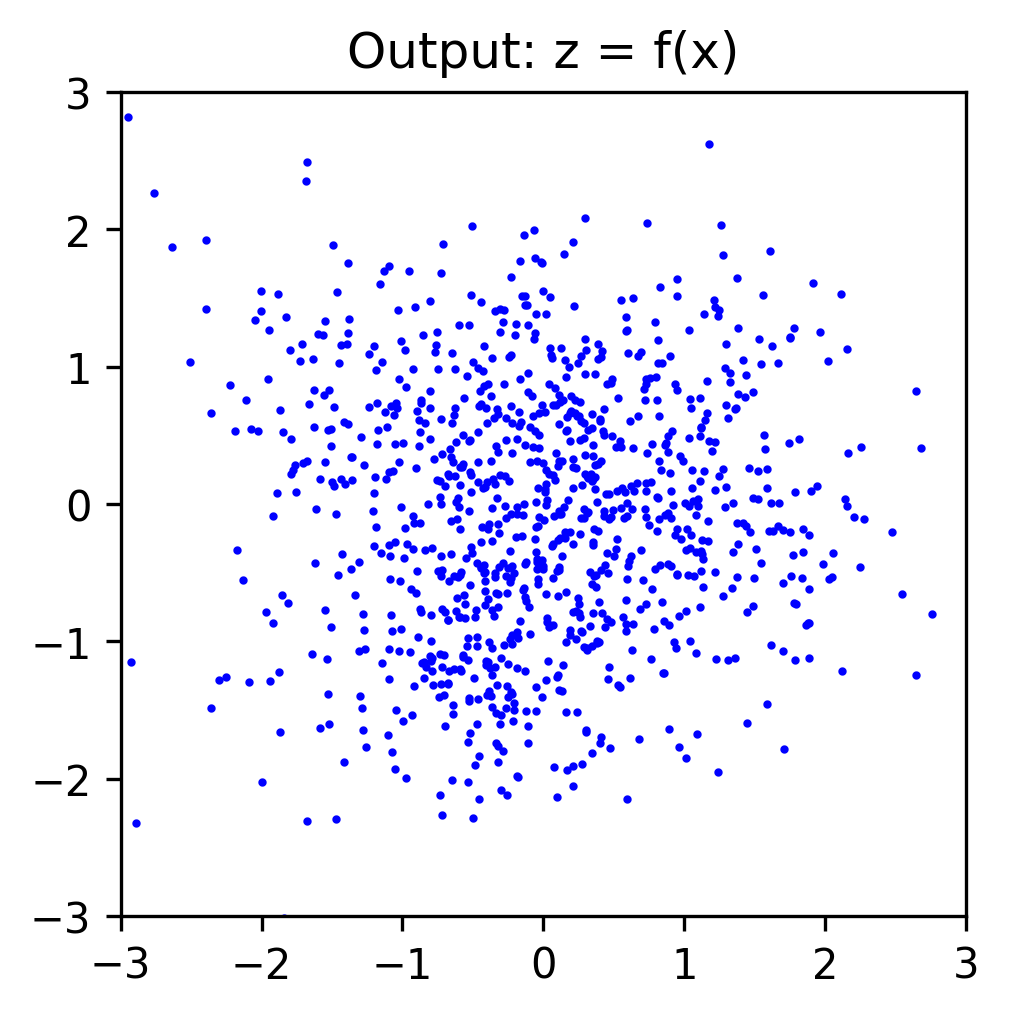

====> Test set loss: -0.0608


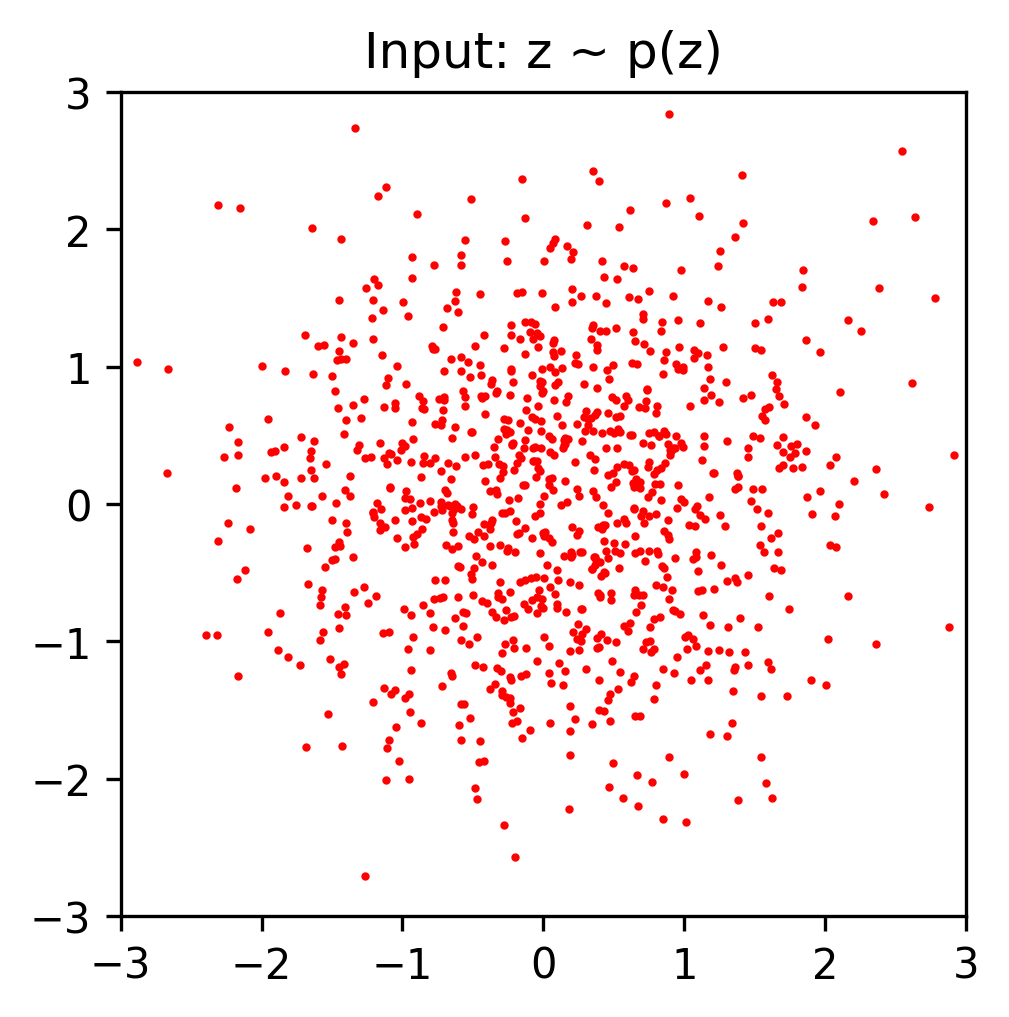

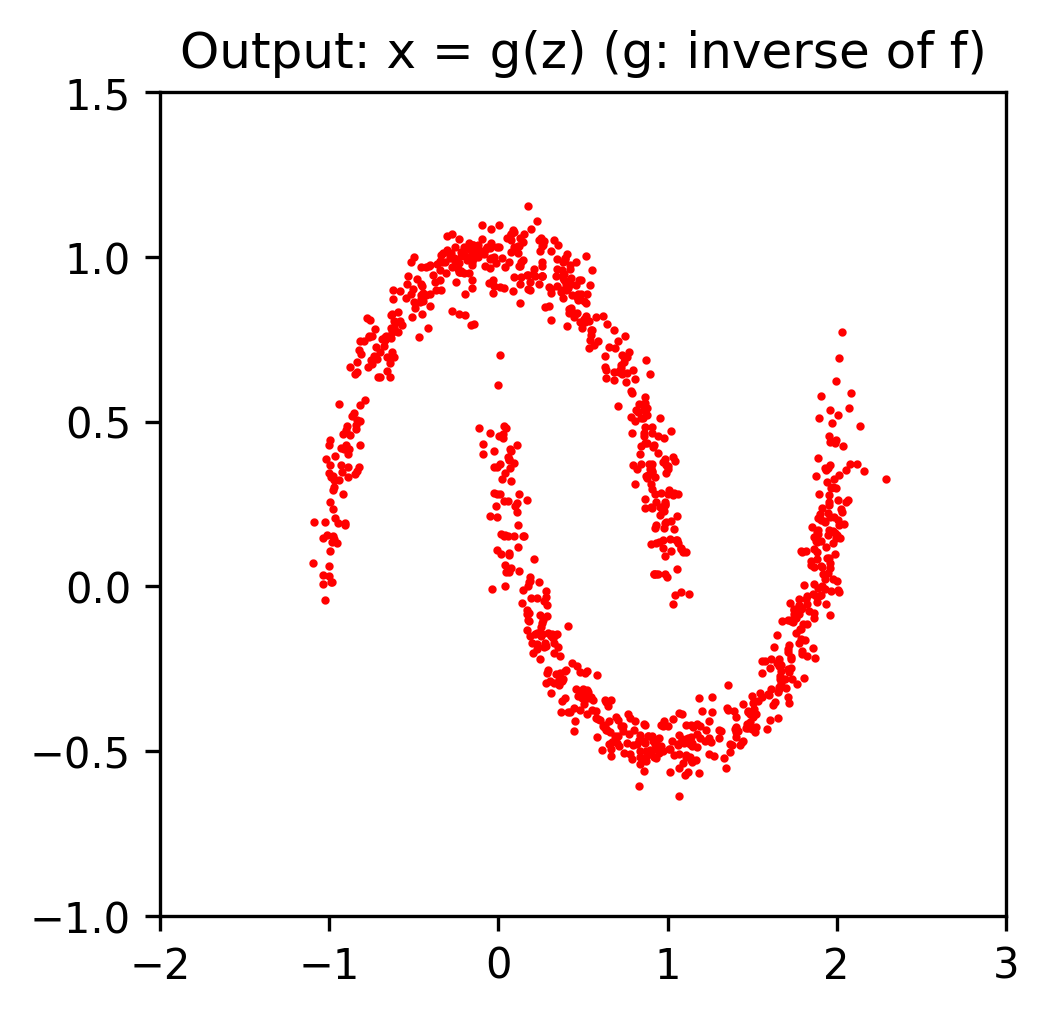

Train Epoch: 14 [0/50000 (0%)]	Loss: -0.060107
Train Epoch: 14 [6400/50000 (13%)]	Loss: -0.059753
Train Epoch: 14 [12800/50000 (26%)]	Loss: -0.059764
Train Epoch: 14 [19200/50000 (38%)]	Loss: -0.058711
Train Epoch: 14 [25600/50000 (51%)]	Loss: -0.059515
Train Epoch: 14 [32000/50000 (64%)]	Loss: -0.059936
Train Epoch: 14 [38400/50000 (77%)]	Loss: -0.058774
Train Epoch: 14 [44800/50000 (90%)]	Loss: -0.058944
====> Epoch: 14 Average loss: -0.0597


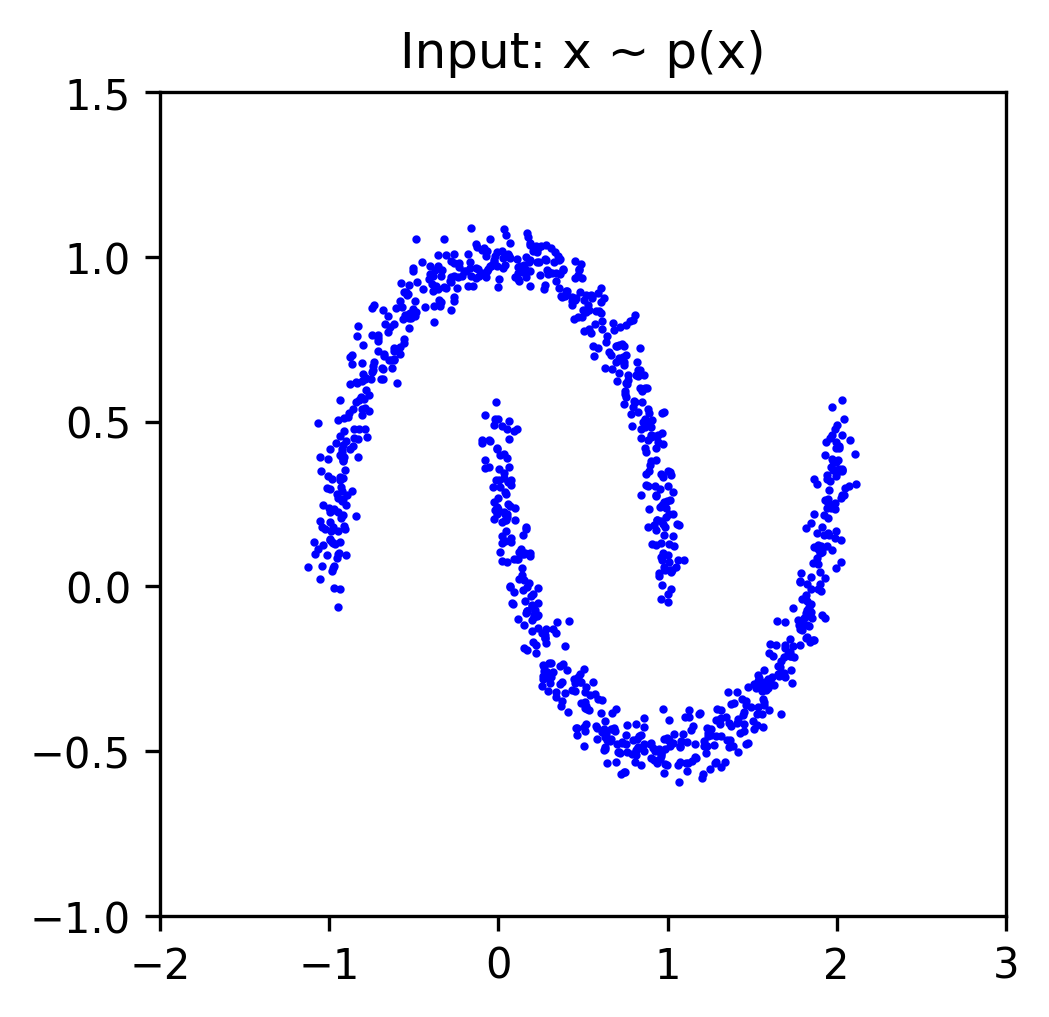

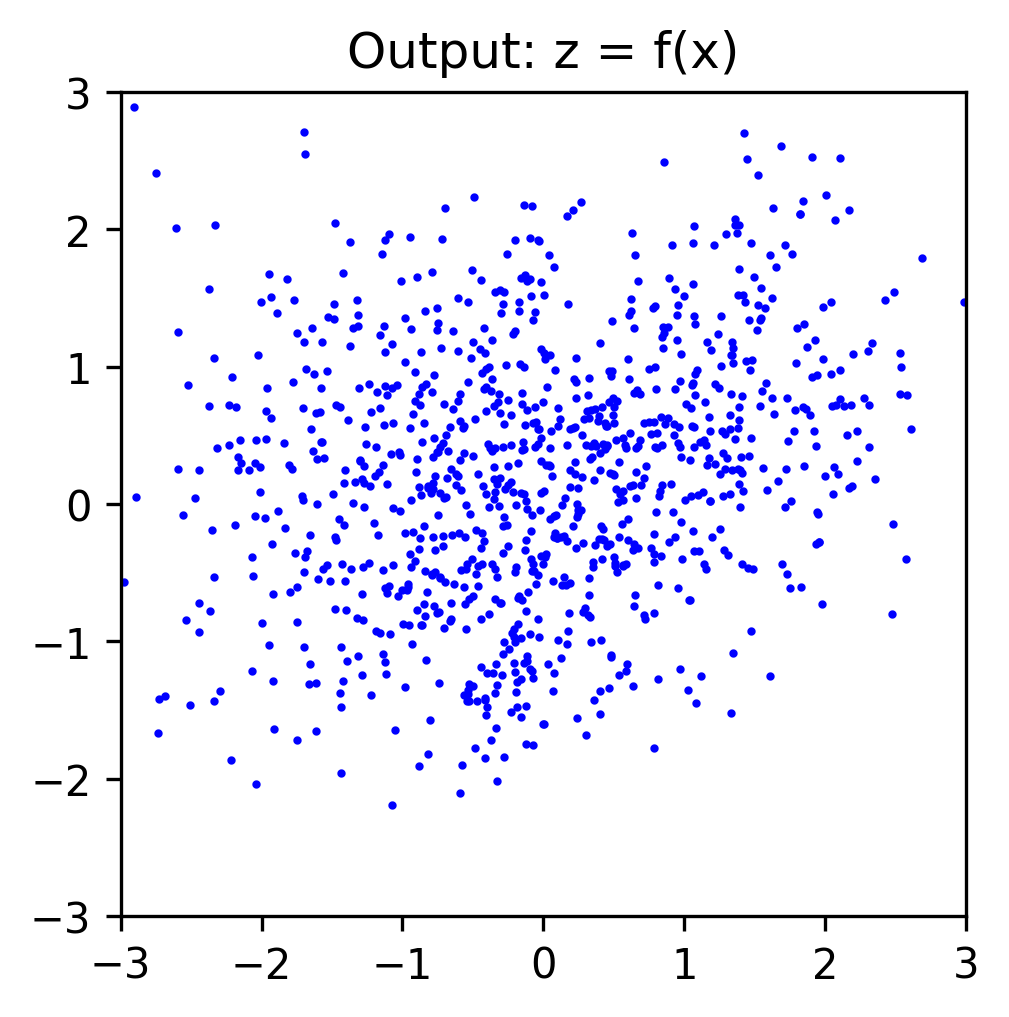

====> Test set loss: -0.0601


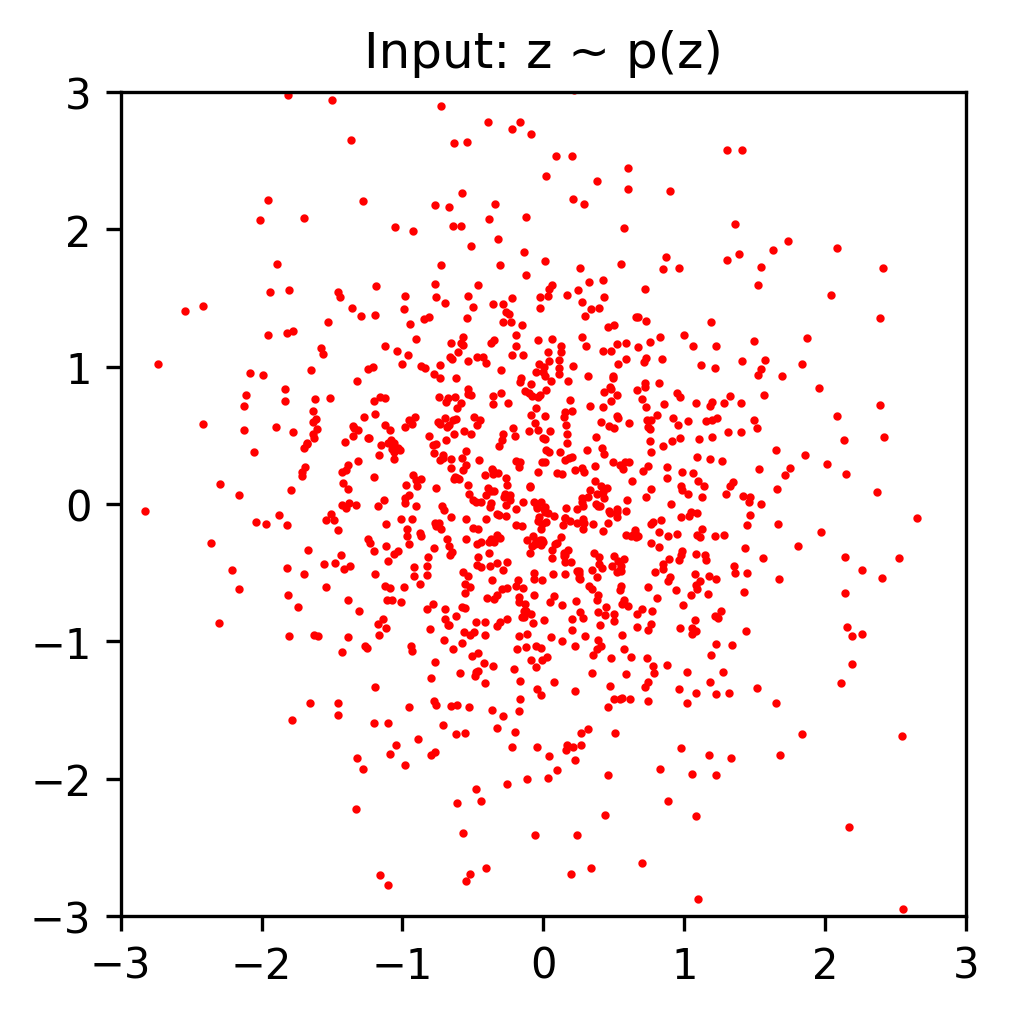

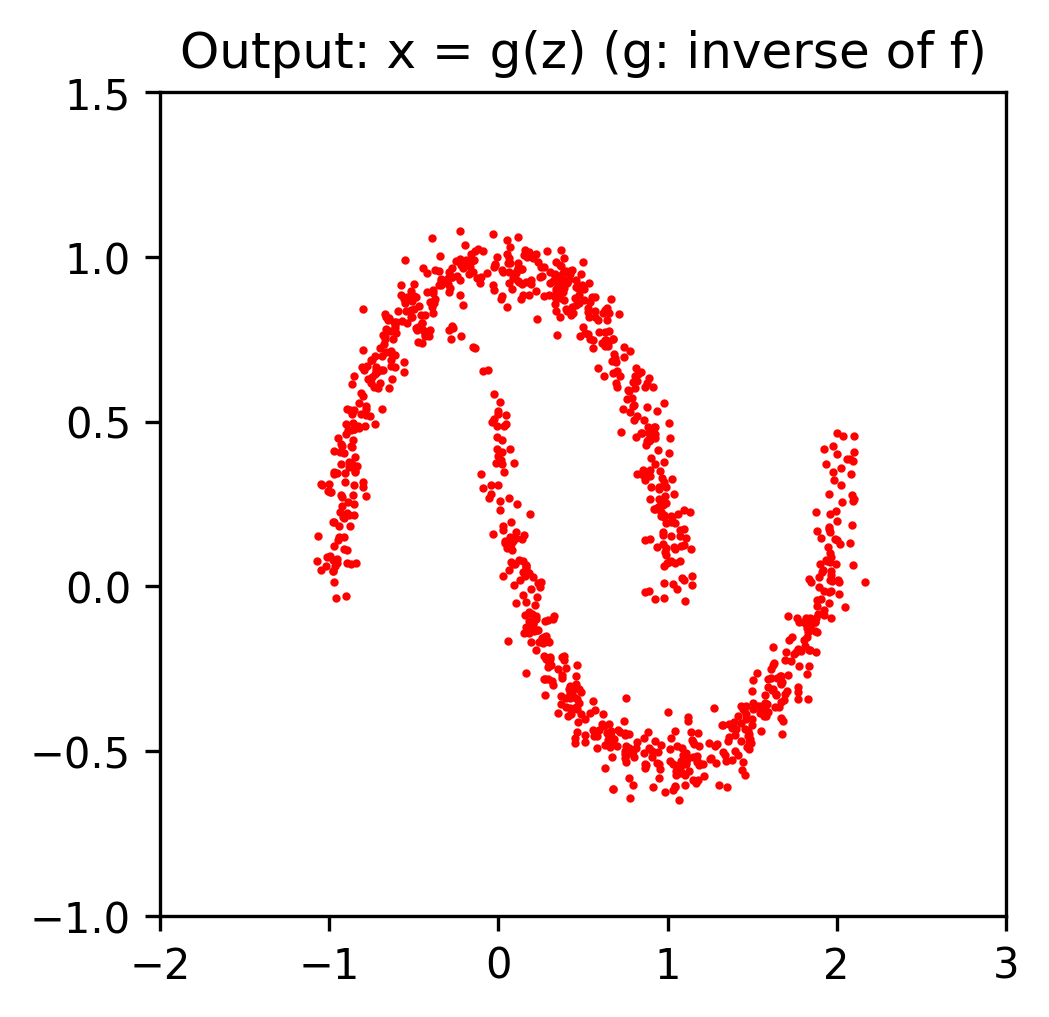

Train Epoch: 15 [0/50000 (0%)]	Loss: -0.058749
Train Epoch: 15 [6400/50000 (13%)]	Loss: -0.059407
Train Epoch: 15 [12800/50000 (26%)]	Loss: -0.059437
Train Epoch: 15 [19200/50000 (38%)]	Loss: -0.059509
Train Epoch: 15 [25600/50000 (51%)]	Loss: -0.059129
Train Epoch: 15 [32000/50000 (64%)]	Loss: -0.059280
Train Epoch: 15 [38400/50000 (77%)]	Loss: -0.059004
Train Epoch: 15 [44800/50000 (90%)]	Loss: -0.059337
====> Epoch: 15 Average loss: -0.0598


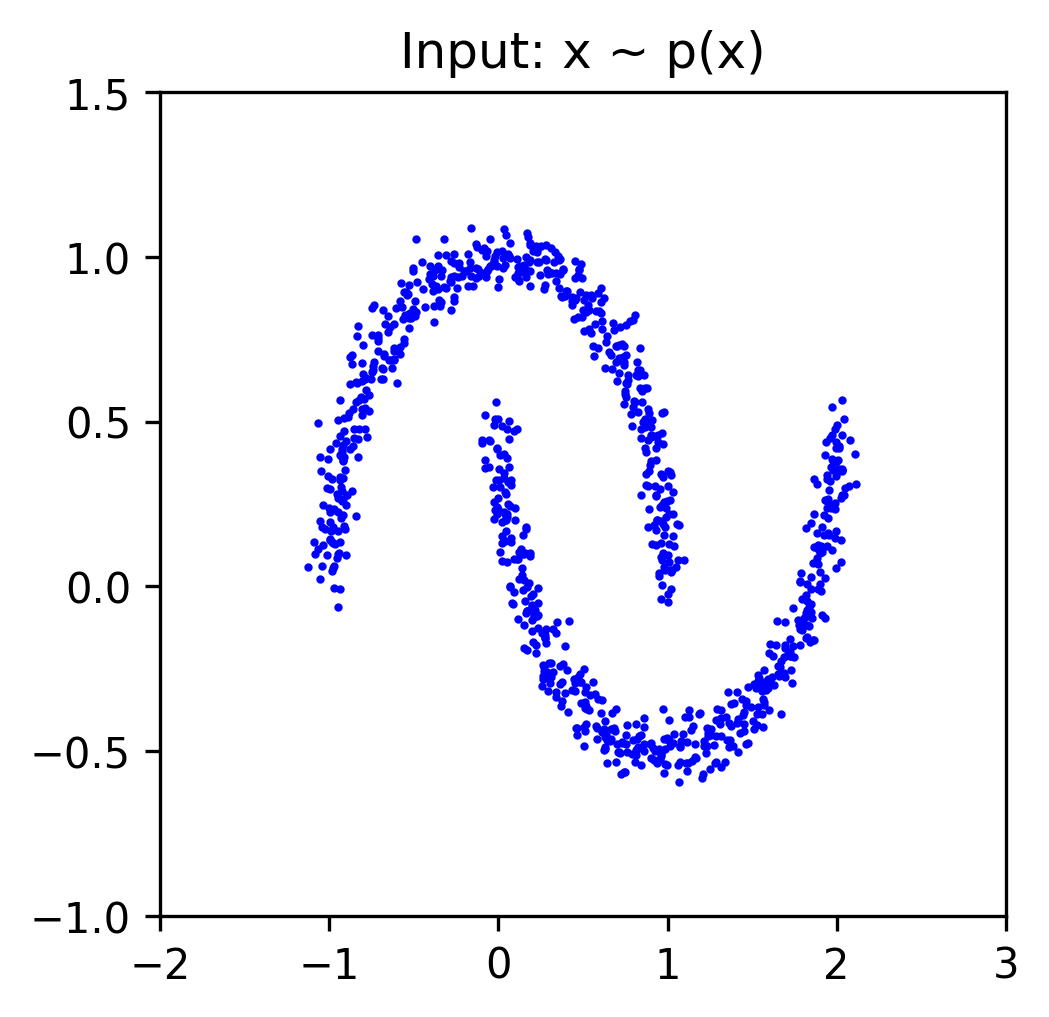

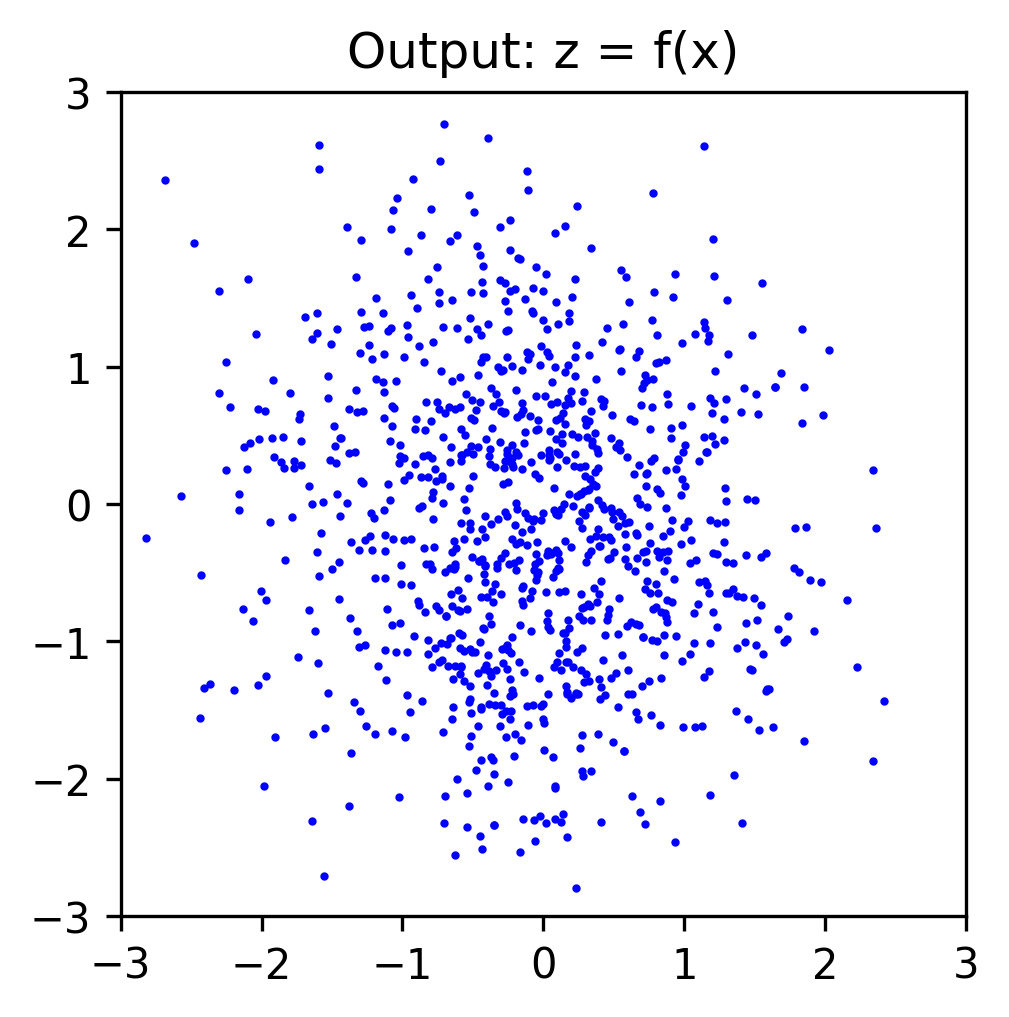

====> Test set loss: -0.0609


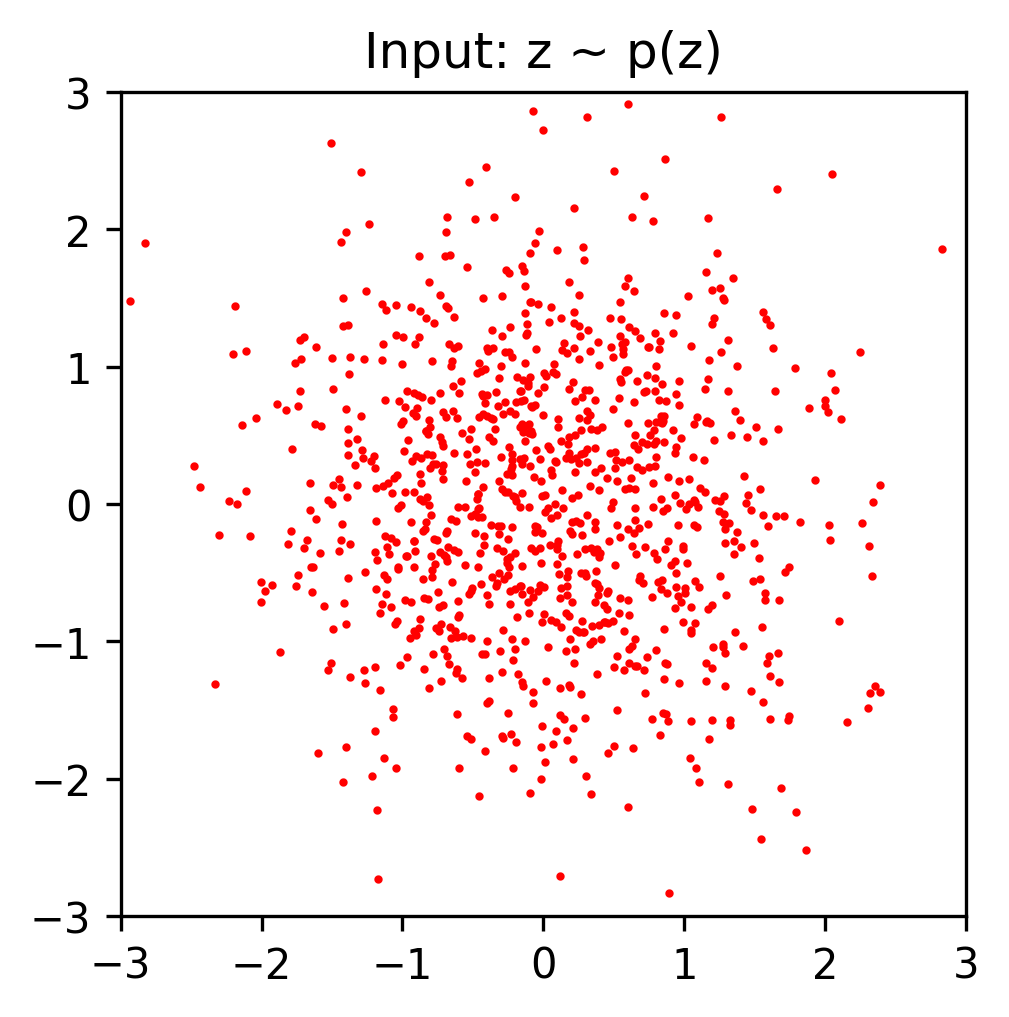

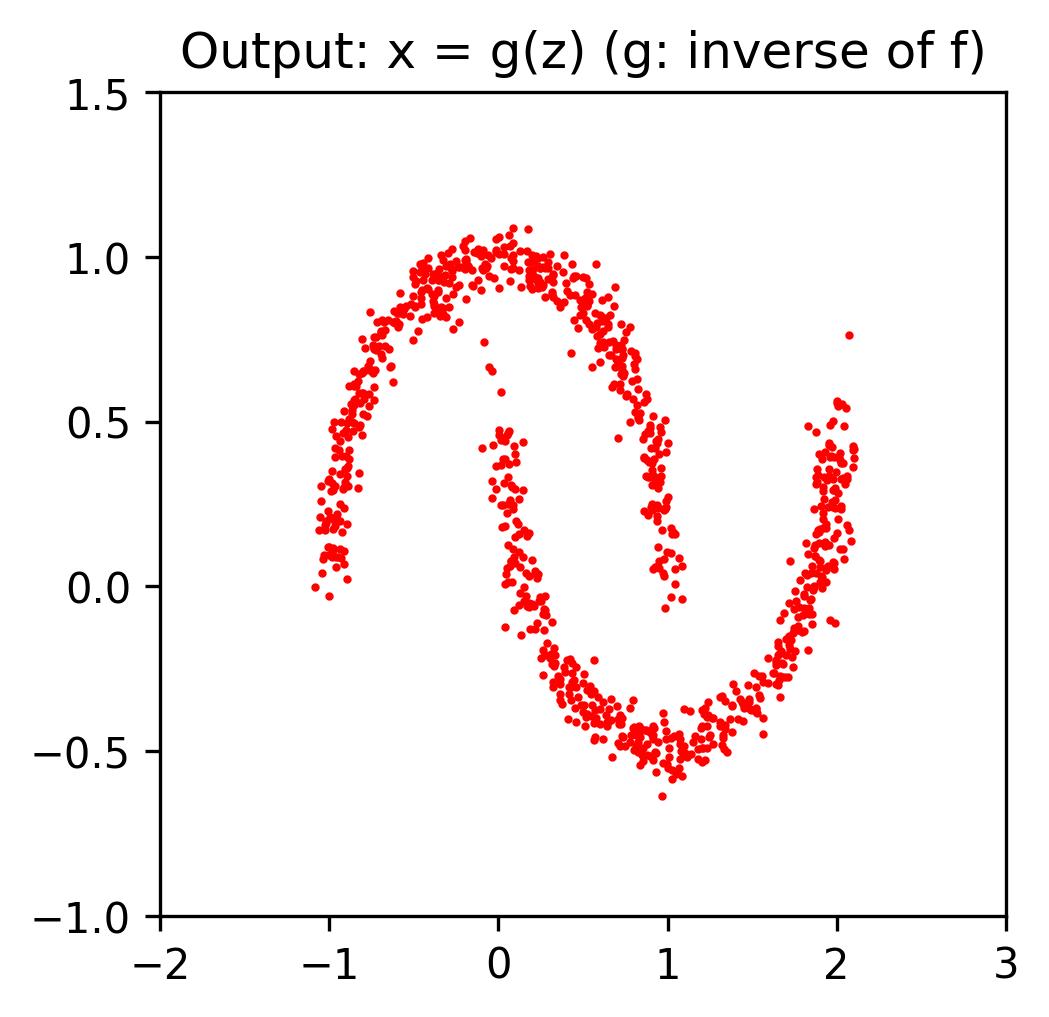

Train Epoch: 16 [0/50000 (0%)]	Loss: -0.059574
Train Epoch: 16 [6400/50000 (13%)]	Loss: -0.060056
Train Epoch: 16 [12800/50000 (26%)]	Loss: -0.059500
Train Epoch: 16 [19200/50000 (38%)]	Loss: -0.060260
Train Epoch: 16 [25600/50000 (51%)]	Loss: -0.059218
Train Epoch: 16 [32000/50000 (64%)]	Loss: -0.059465
Train Epoch: 16 [38400/50000 (77%)]	Loss: -0.059770
Train Epoch: 16 [44800/50000 (90%)]	Loss: -0.059410
====> Epoch: 16 Average loss: -0.0598


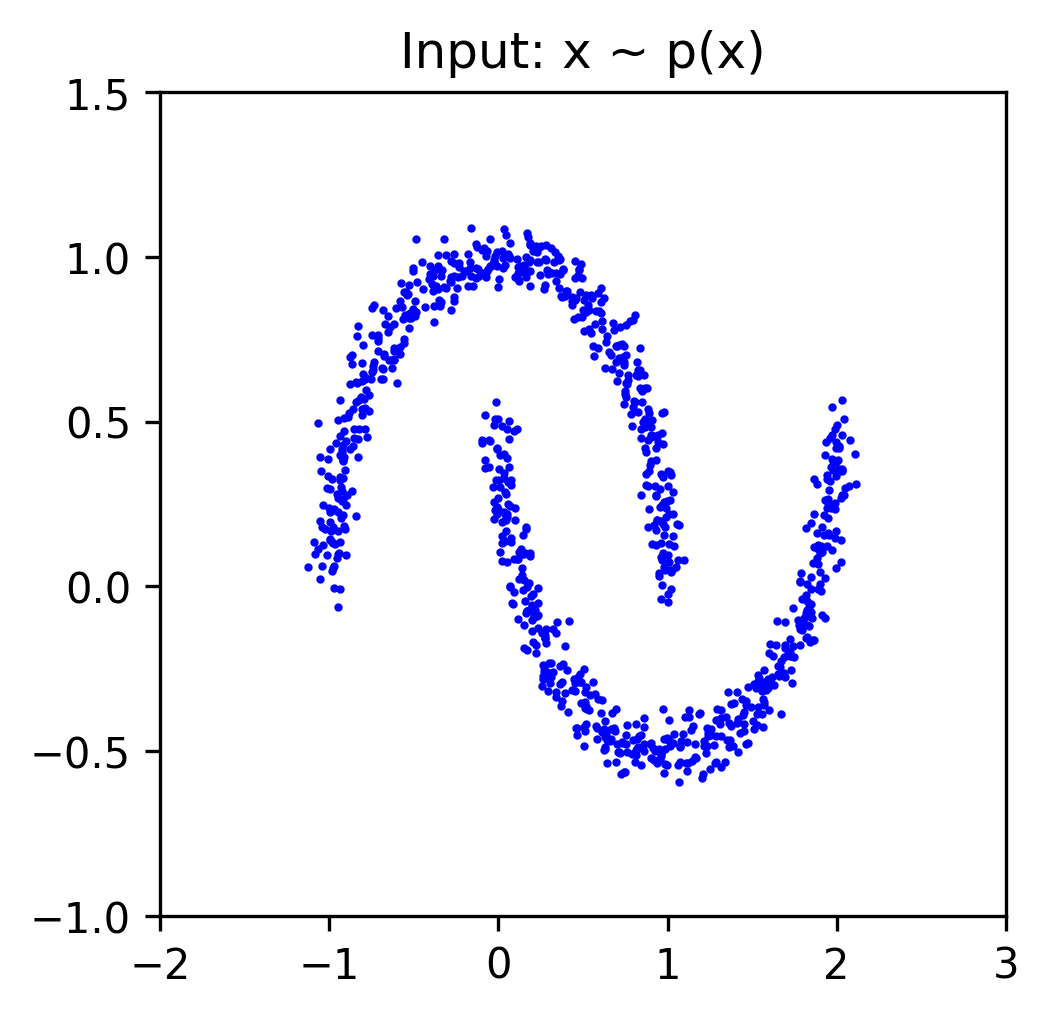

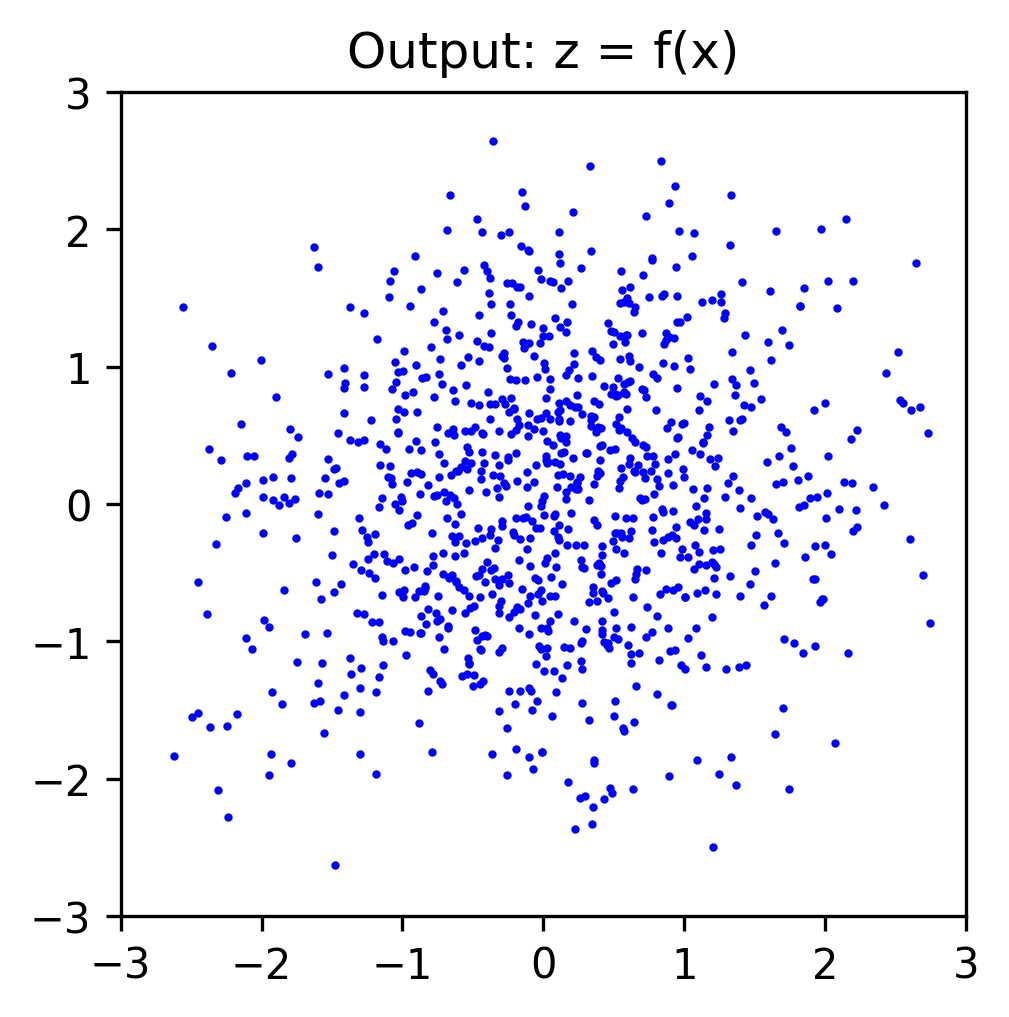

====> Test set loss: -0.0609


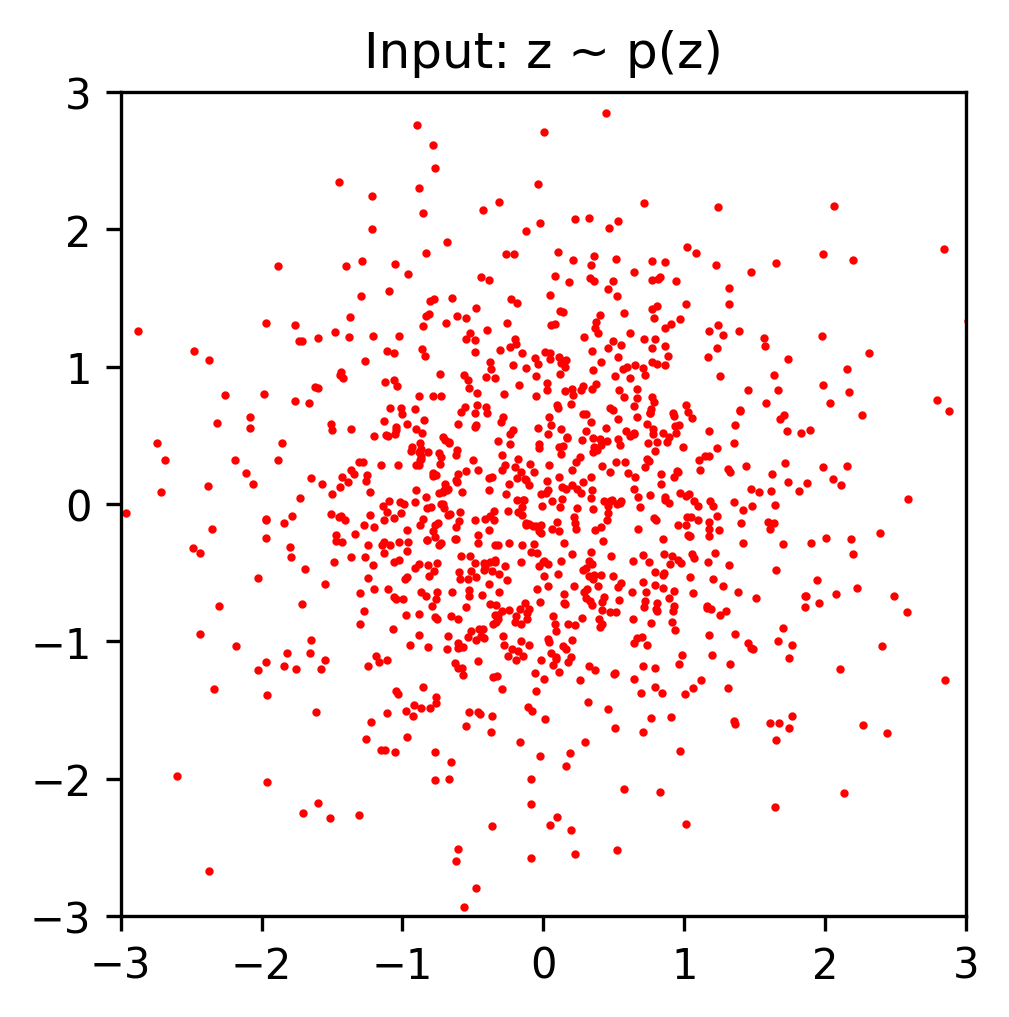

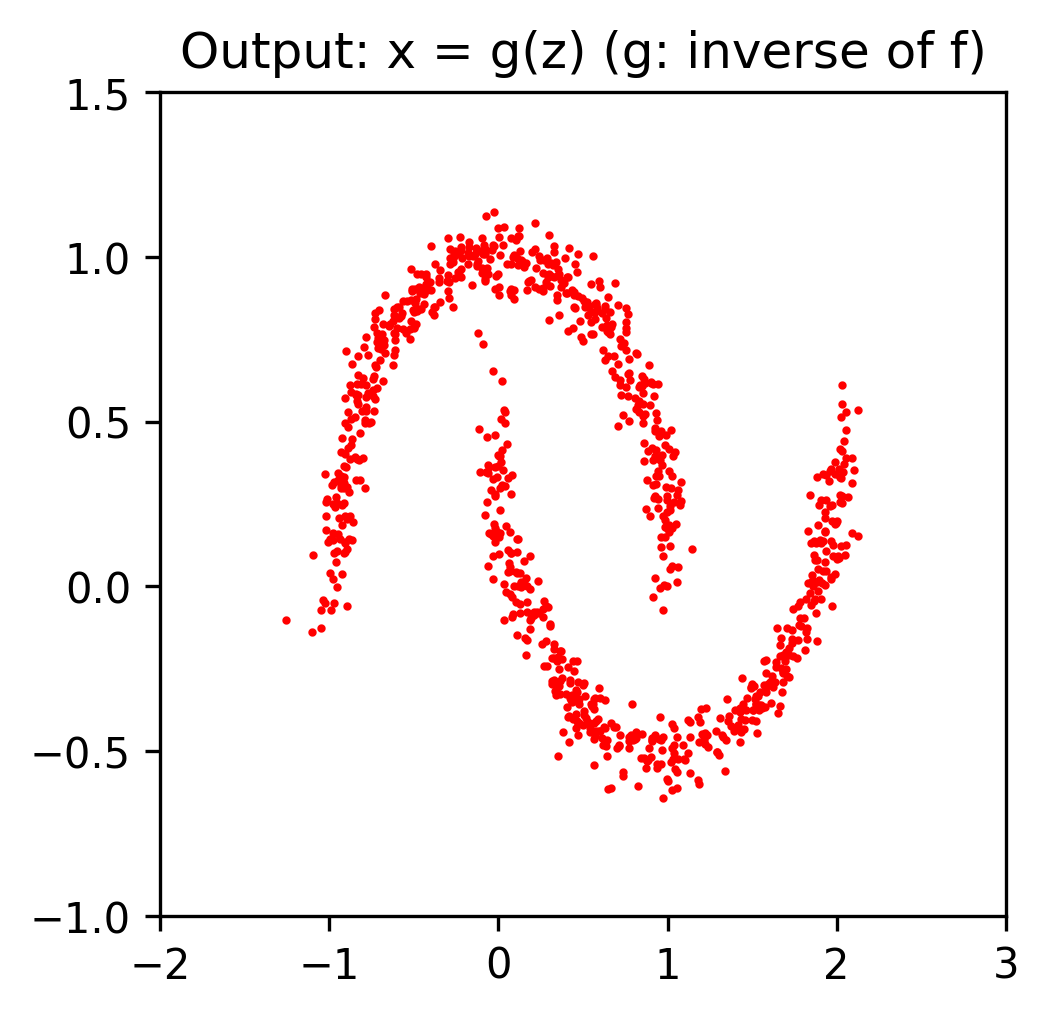

Train Epoch: 17 [0/50000 (0%)]	Loss: -0.059442
Train Epoch: 17 [6400/50000 (13%)]	Loss: -0.060020
Train Epoch: 17 [12800/50000 (26%)]	Loss: -0.060624
Train Epoch: 17 [19200/50000 (38%)]	Loss: -0.059306
Train Epoch: 17 [25600/50000 (51%)]	Loss: -0.059645
Train Epoch: 17 [32000/50000 (64%)]	Loss: -0.060529
Train Epoch: 17 [38400/50000 (77%)]	Loss: -0.059384
Train Epoch: 17 [44800/50000 (90%)]	Loss: -0.060785
====> Epoch: 17 Average loss: -0.0598


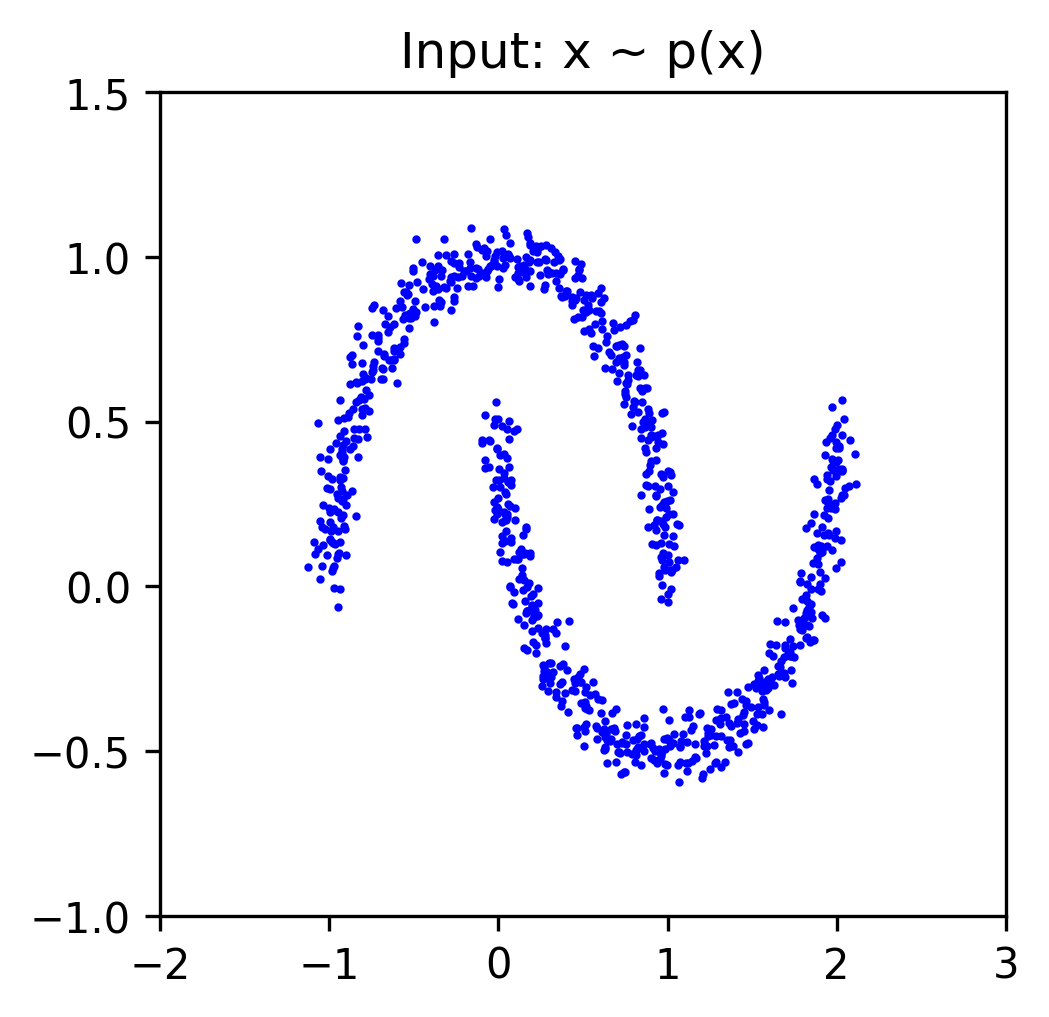

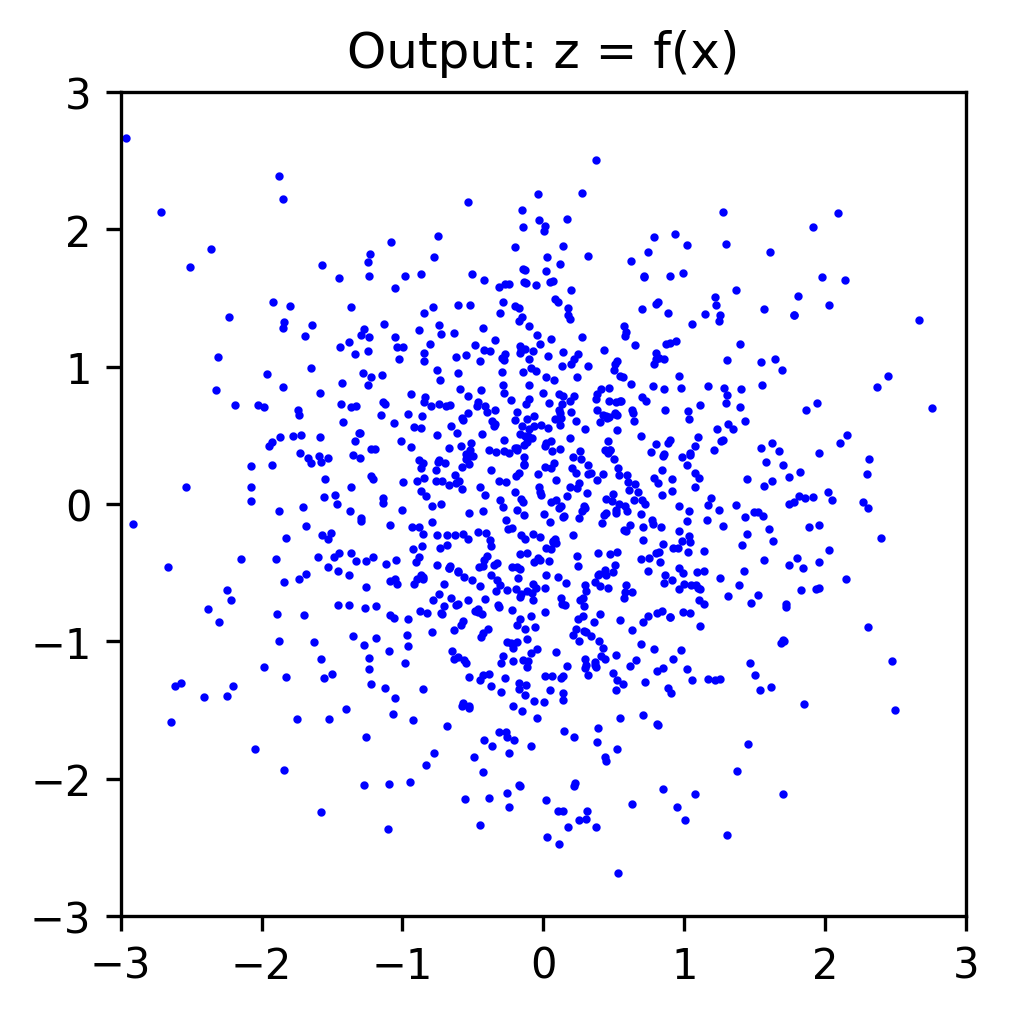

====> Test set loss: -0.0610


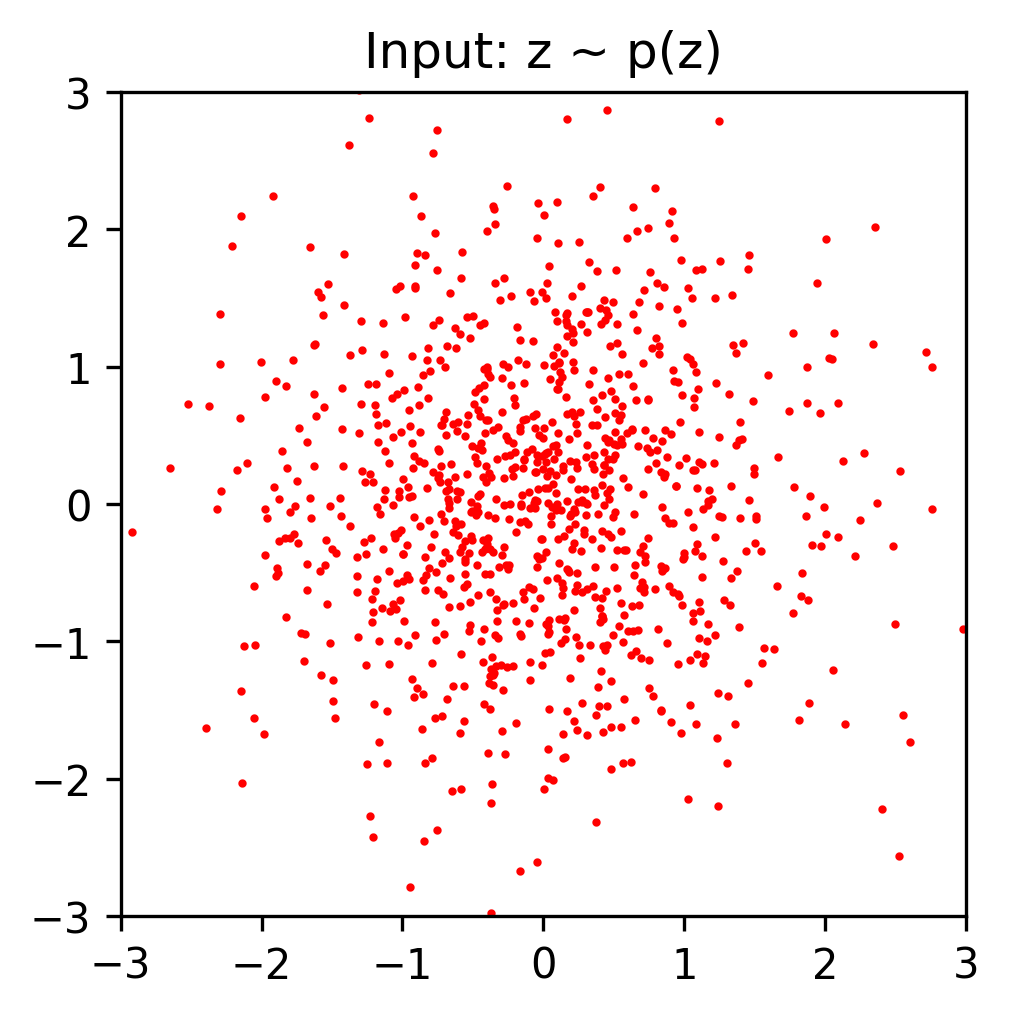

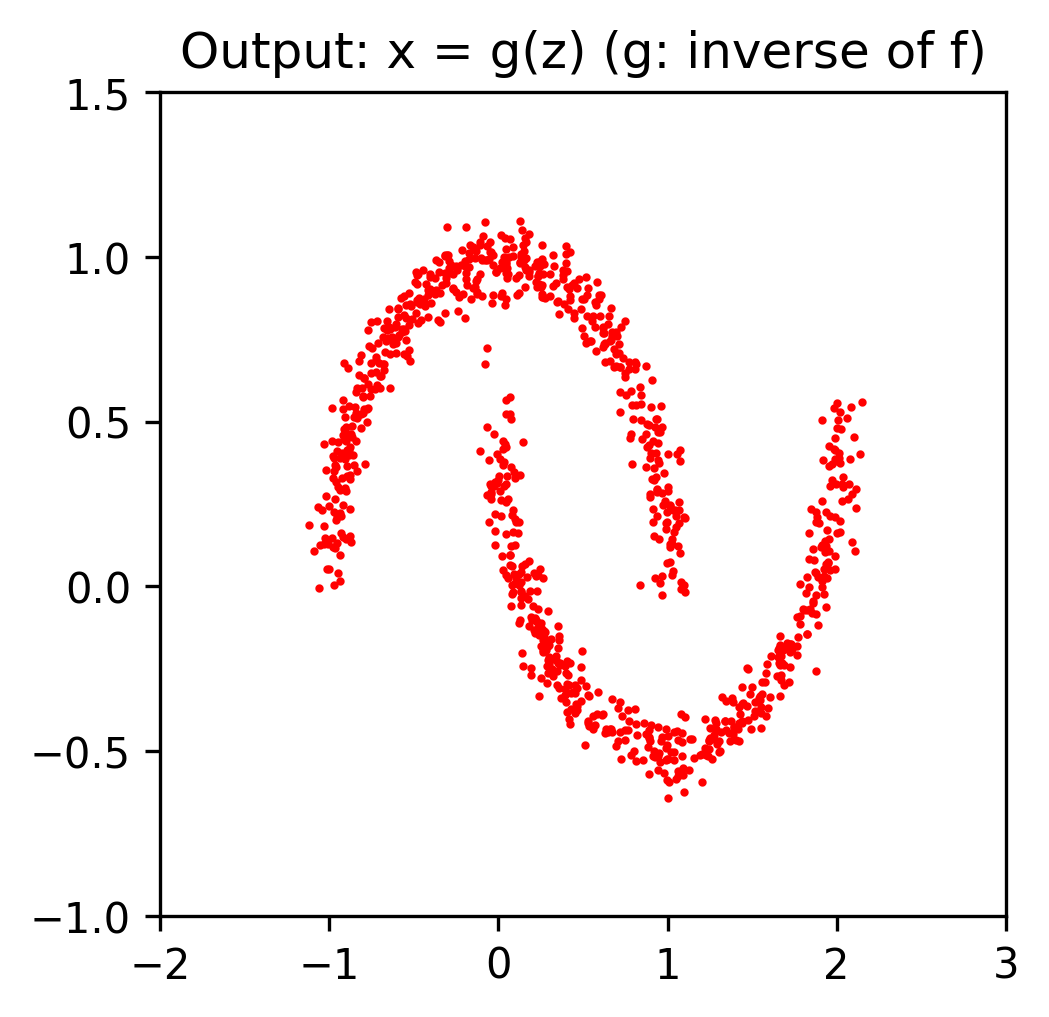

Train Epoch: 18 [0/50000 (0%)]	Loss: -0.059818
Train Epoch: 18 [6400/50000 (13%)]	Loss: -0.060756
Train Epoch: 18 [12800/50000 (26%)]	Loss: -0.060599
Train Epoch: 18 [19200/50000 (38%)]	Loss: -0.060223
Train Epoch: 18 [25600/50000 (51%)]	Loss: -0.058954
Train Epoch: 18 [32000/50000 (64%)]	Loss: -0.059024
Train Epoch: 18 [38400/50000 (77%)]	Loss: -0.060717
Train Epoch: 18 [44800/50000 (90%)]	Loss: -0.060272
====> Epoch: 18 Average loss: -0.0599


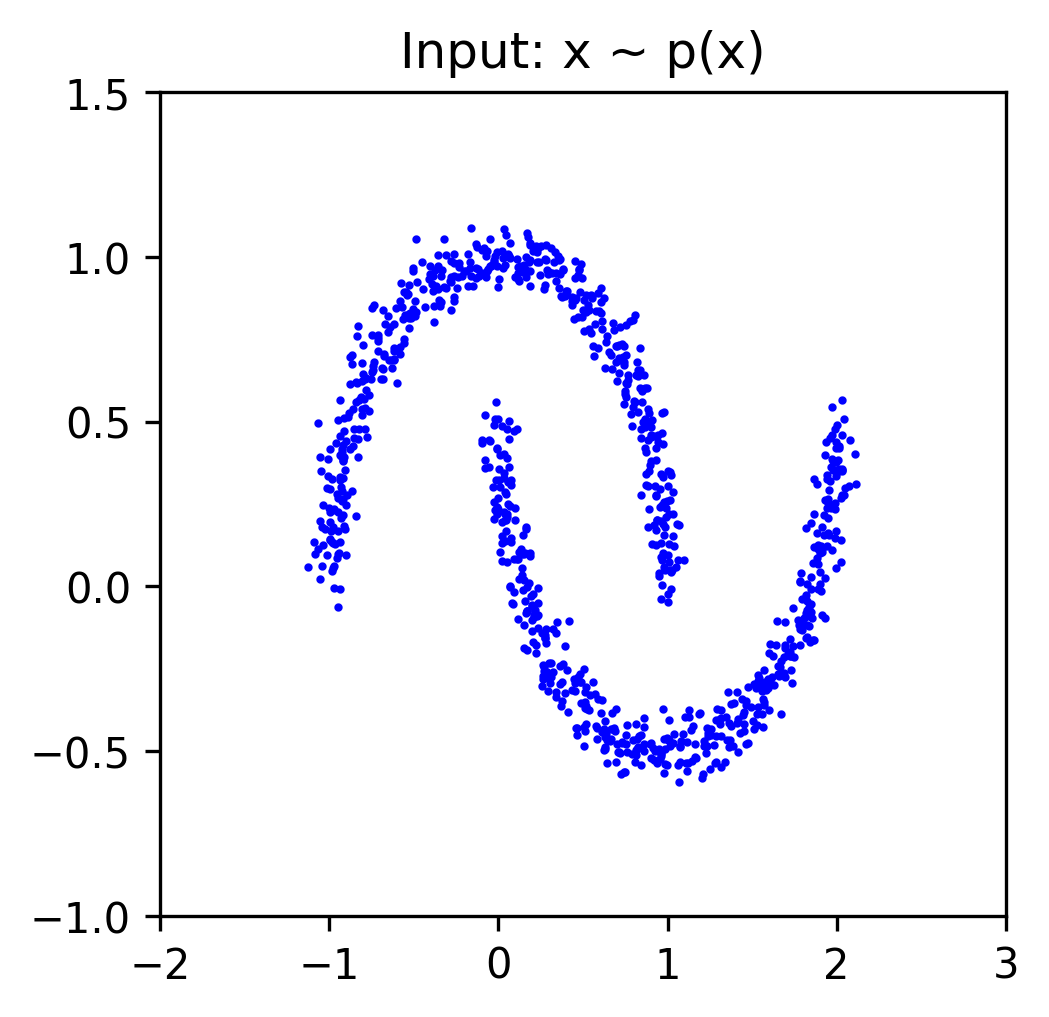

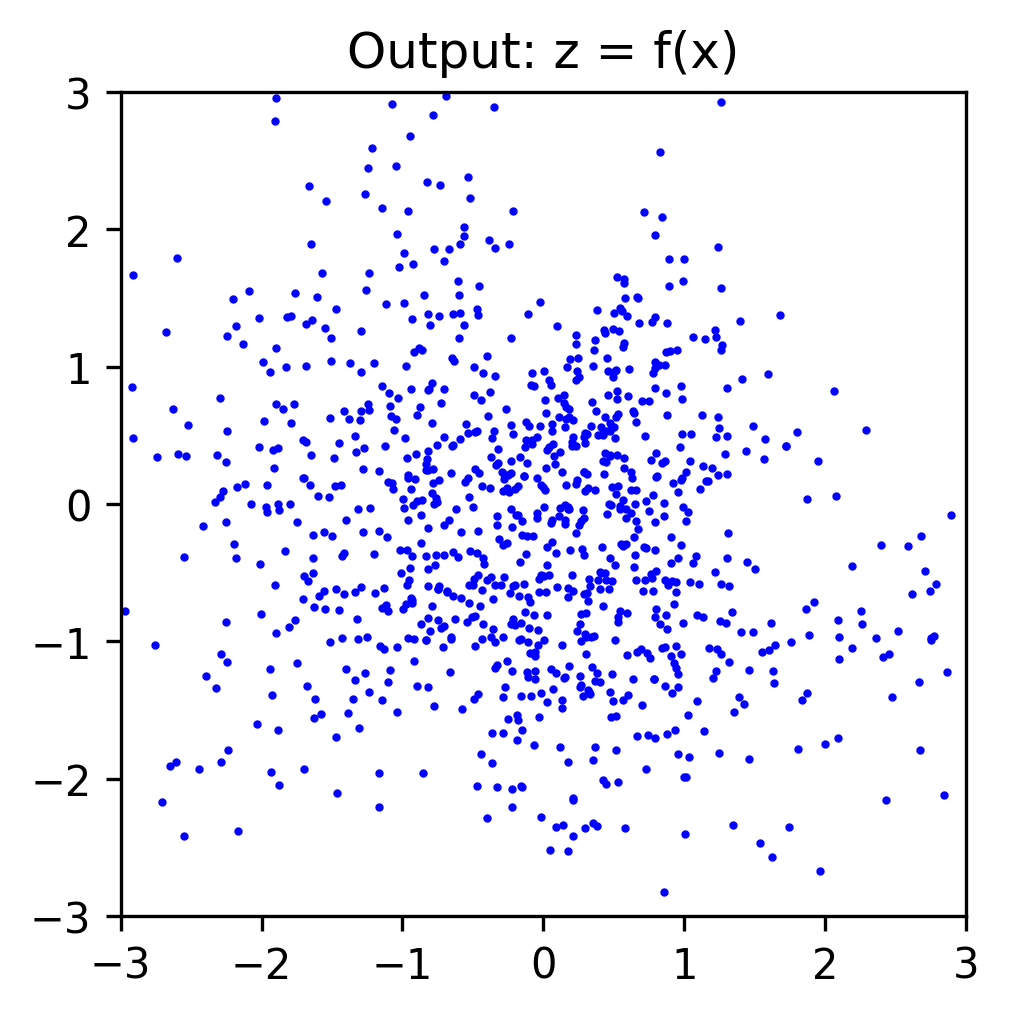

====> Test set loss: -0.0602


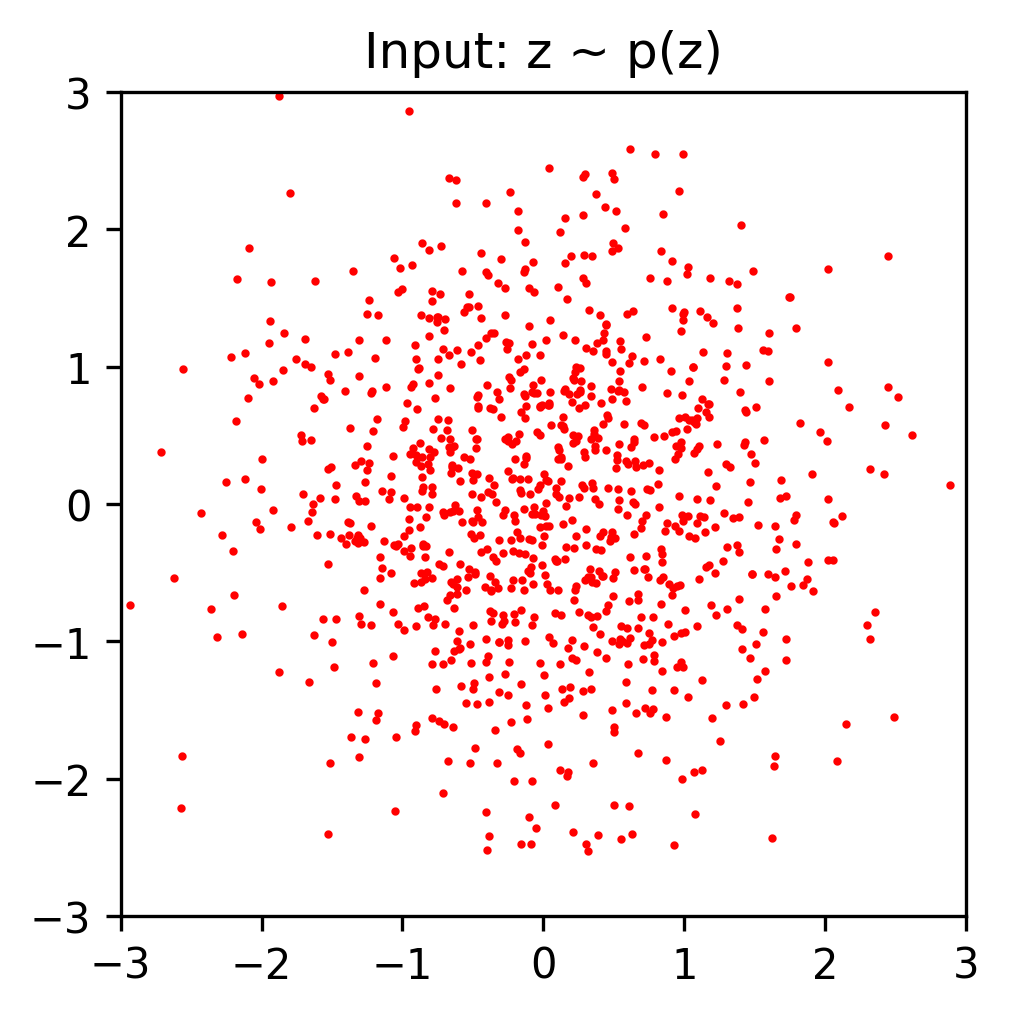

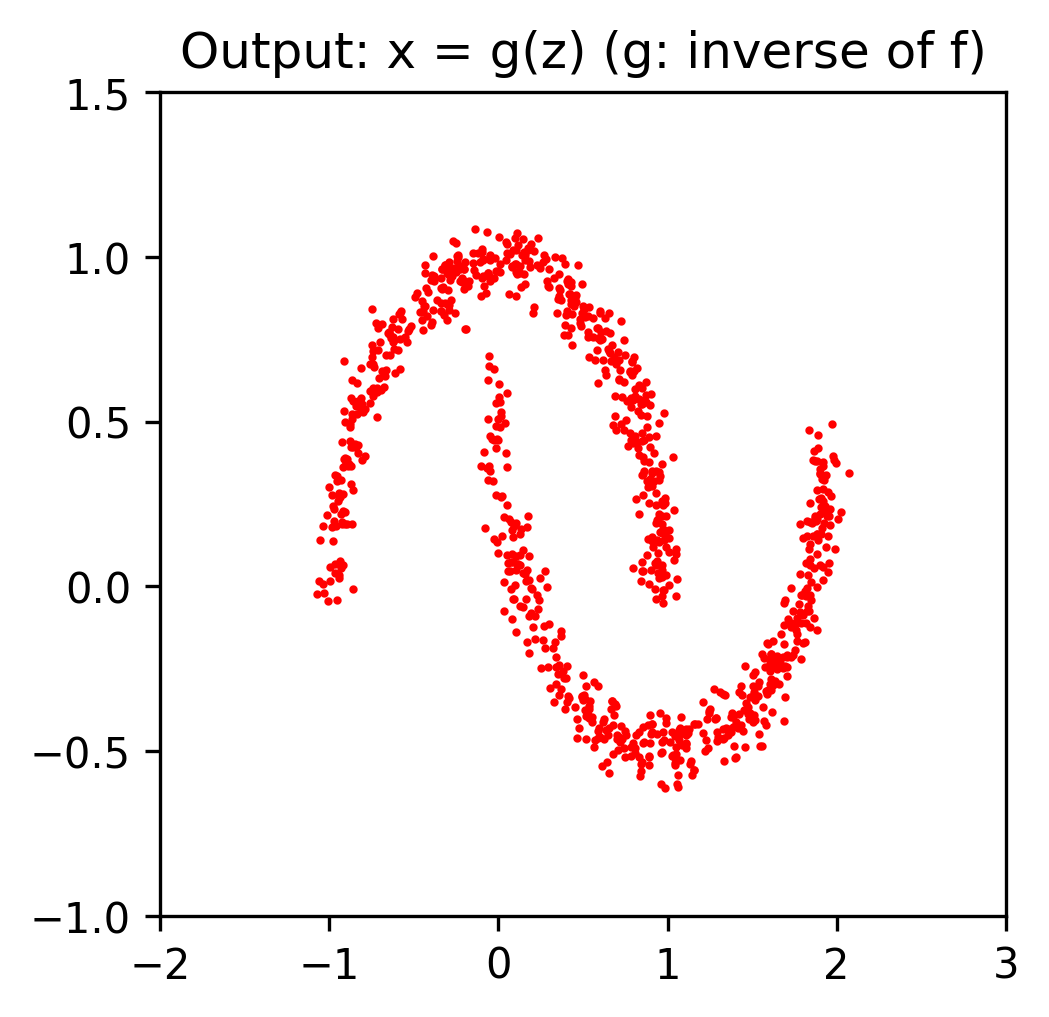

Train Epoch: 19 [0/50000 (0%)]	Loss: -0.058518
Train Epoch: 19 [6400/50000 (13%)]	Loss: -0.059427
Train Epoch: 19 [12800/50000 (26%)]	Loss: -0.058943
Train Epoch: 19 [19200/50000 (38%)]	Loss: -0.059410
Train Epoch: 19 [25600/50000 (51%)]	Loss: -0.058990
Train Epoch: 19 [32000/50000 (64%)]	Loss: -0.059753
Train Epoch: 19 [38400/50000 (77%)]	Loss: -0.059013
Train Epoch: 19 [44800/50000 (90%)]	Loss: -0.059091
====> Epoch: 19 Average loss: -0.0598


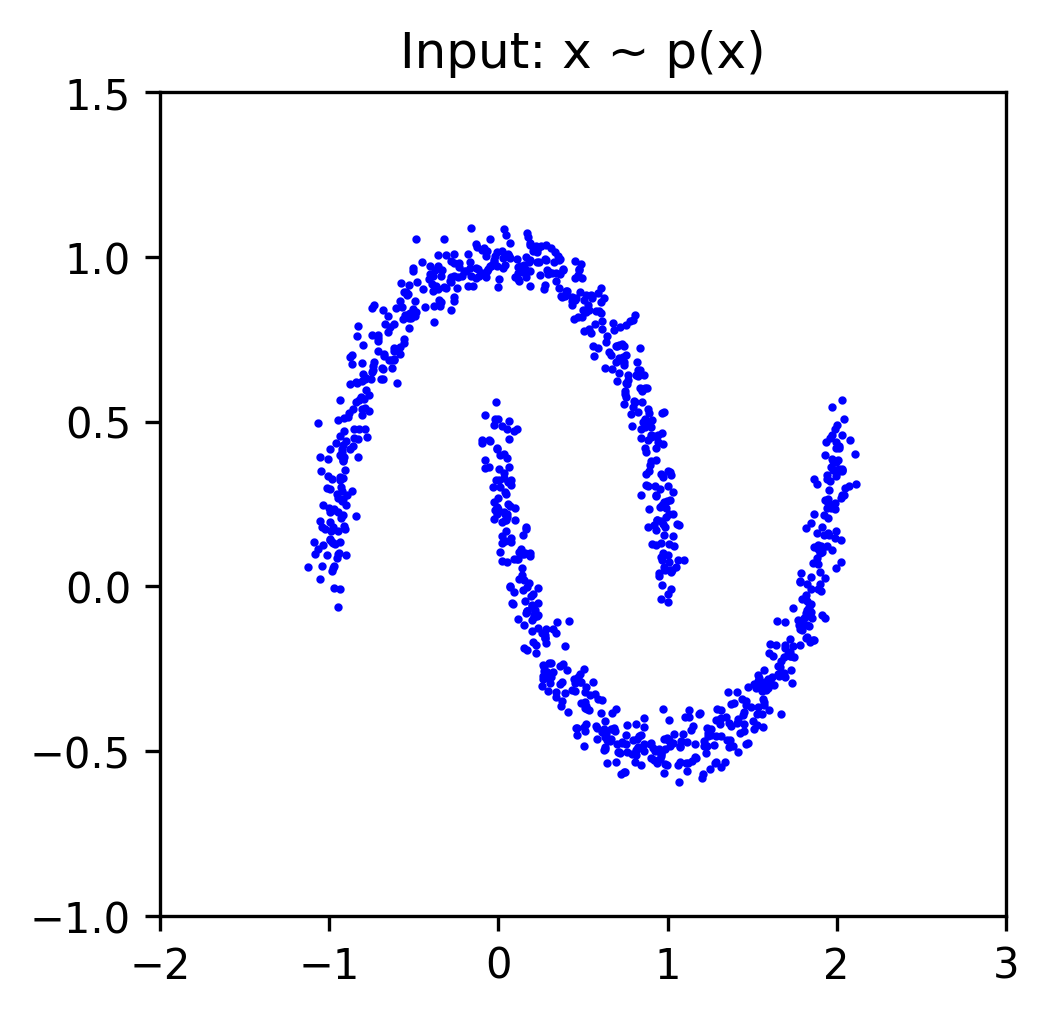

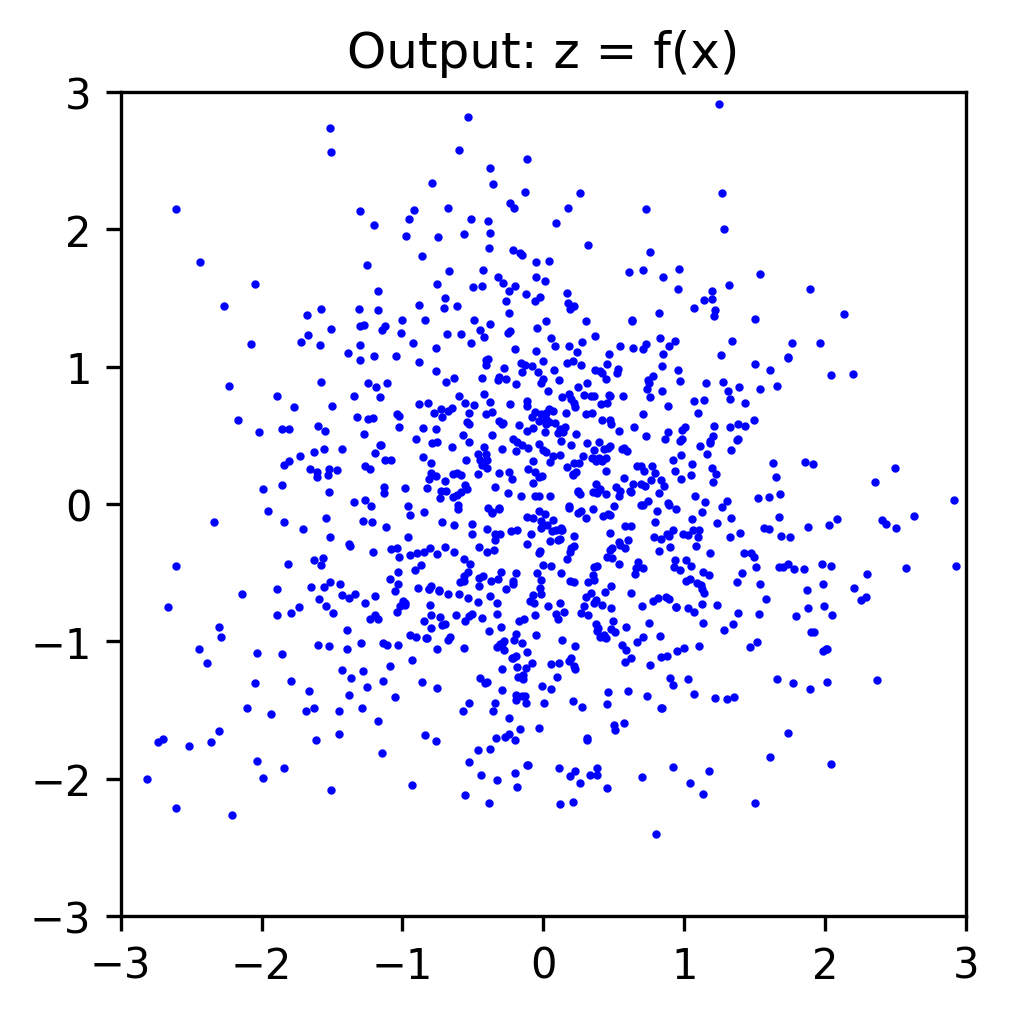

====> Test set loss: -0.0610


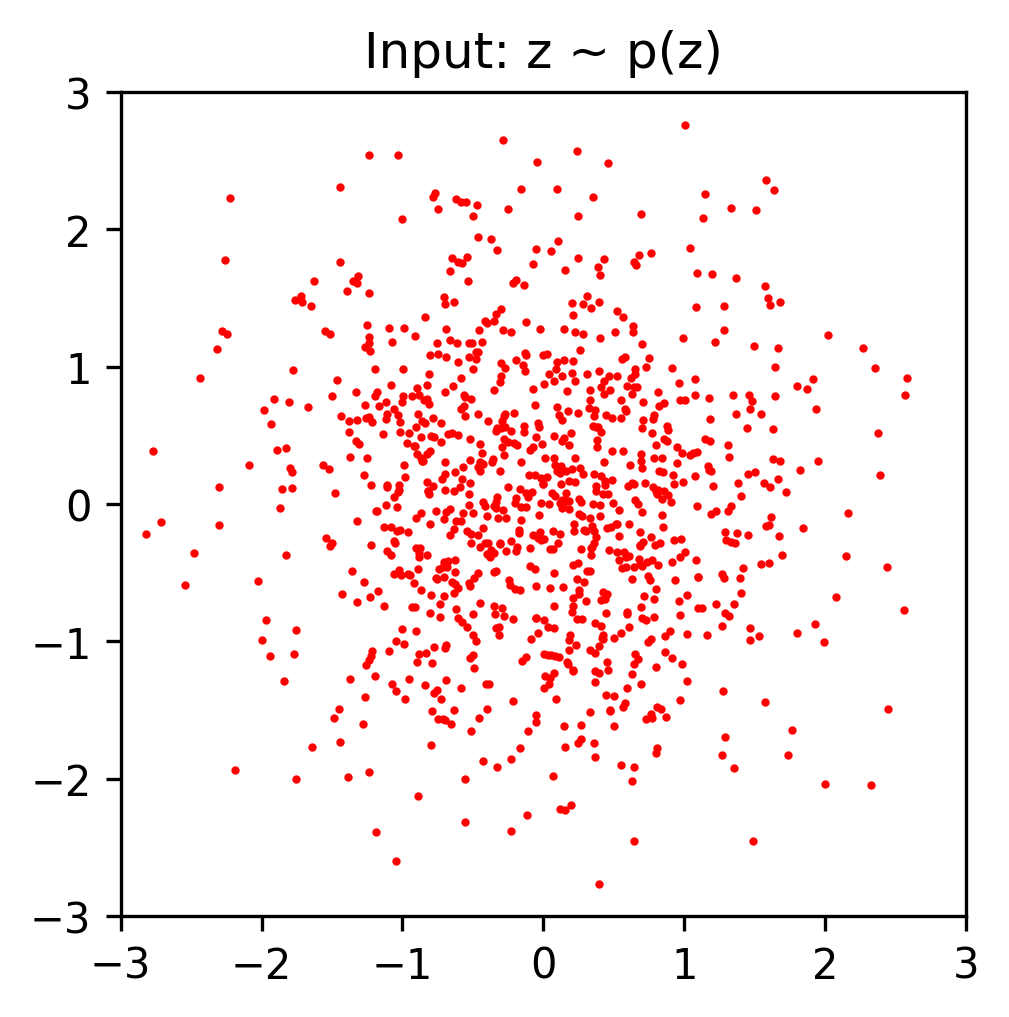

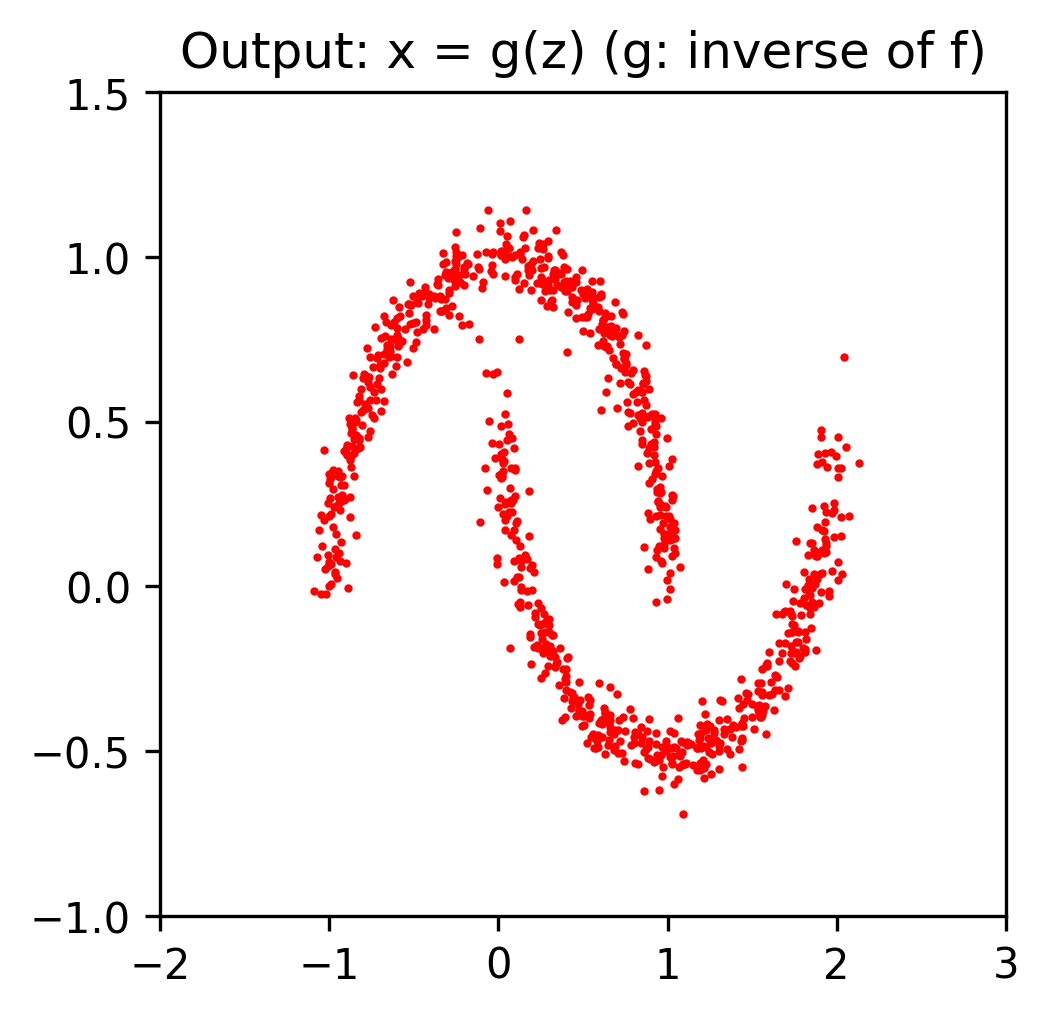

Train Epoch: 20 [0/50000 (0%)]	Loss: -0.059777
Train Epoch: 20 [6400/50000 (13%)]	Loss: -0.059208
Train Epoch: 20 [12800/50000 (26%)]	Loss: -0.060667
Train Epoch: 20 [19200/50000 (38%)]	Loss: -0.060513
Train Epoch: 20 [25600/50000 (51%)]	Loss: -0.059275
Train Epoch: 20 [32000/50000 (64%)]	Loss: -0.060122
Train Epoch: 20 [38400/50000 (77%)]	Loss: -0.059882
Train Epoch: 20 [44800/50000 (90%)]	Loss: -0.059469
====> Epoch: 20 Average loss: -0.0599


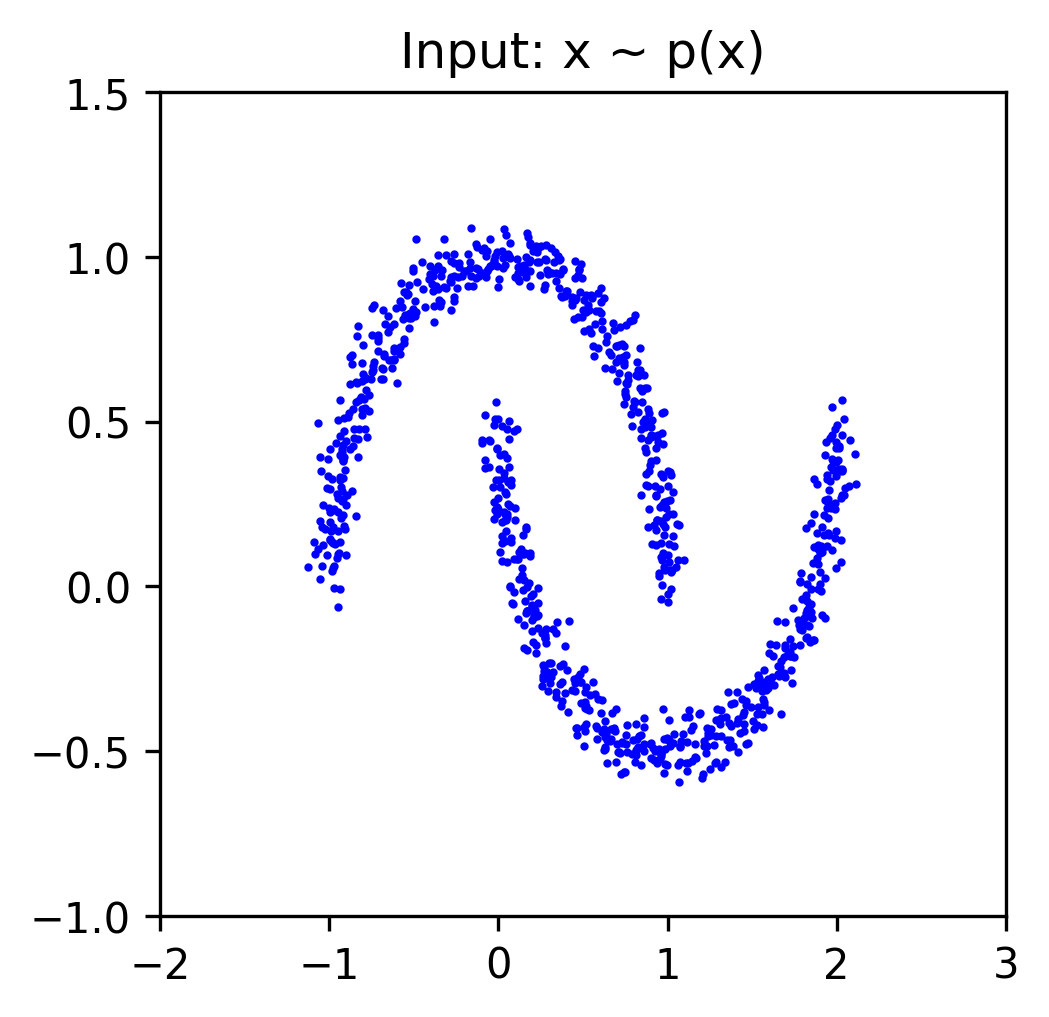

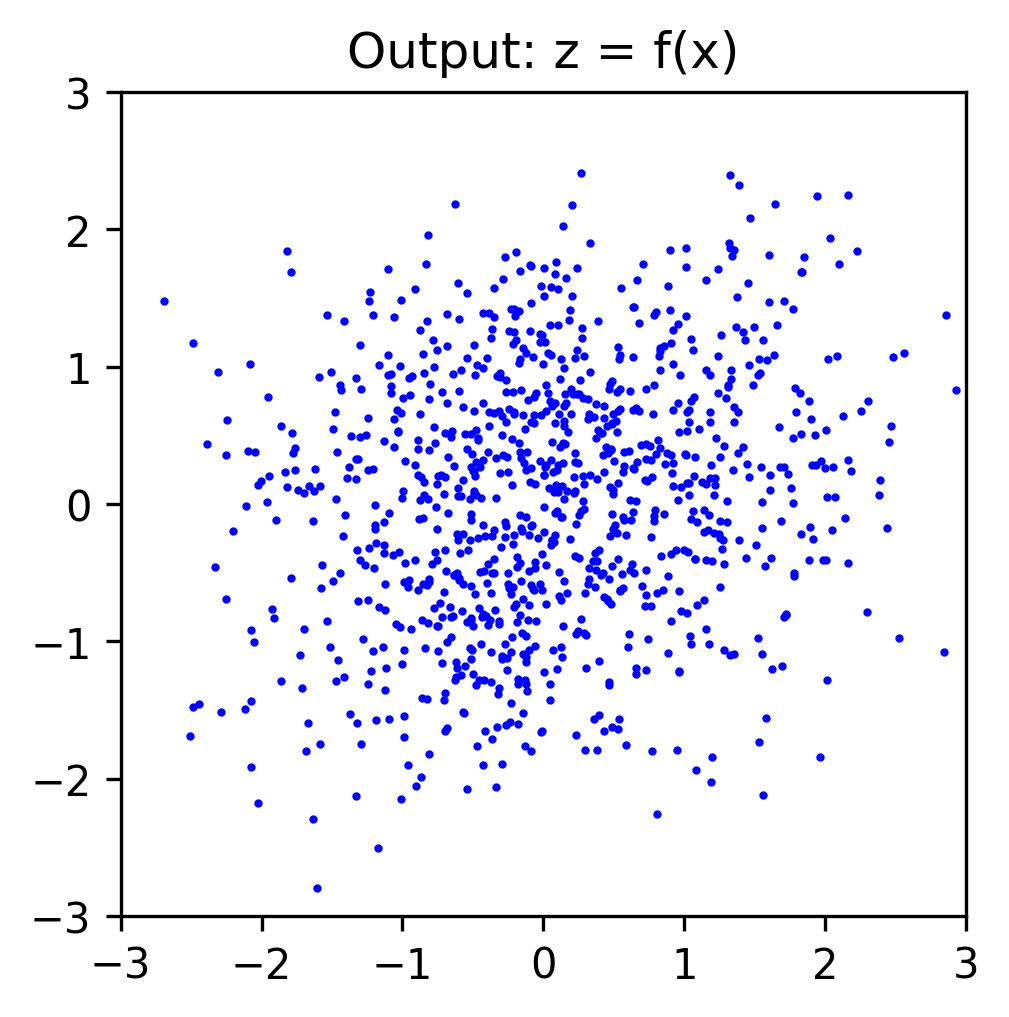

====> Test set loss: -0.0608


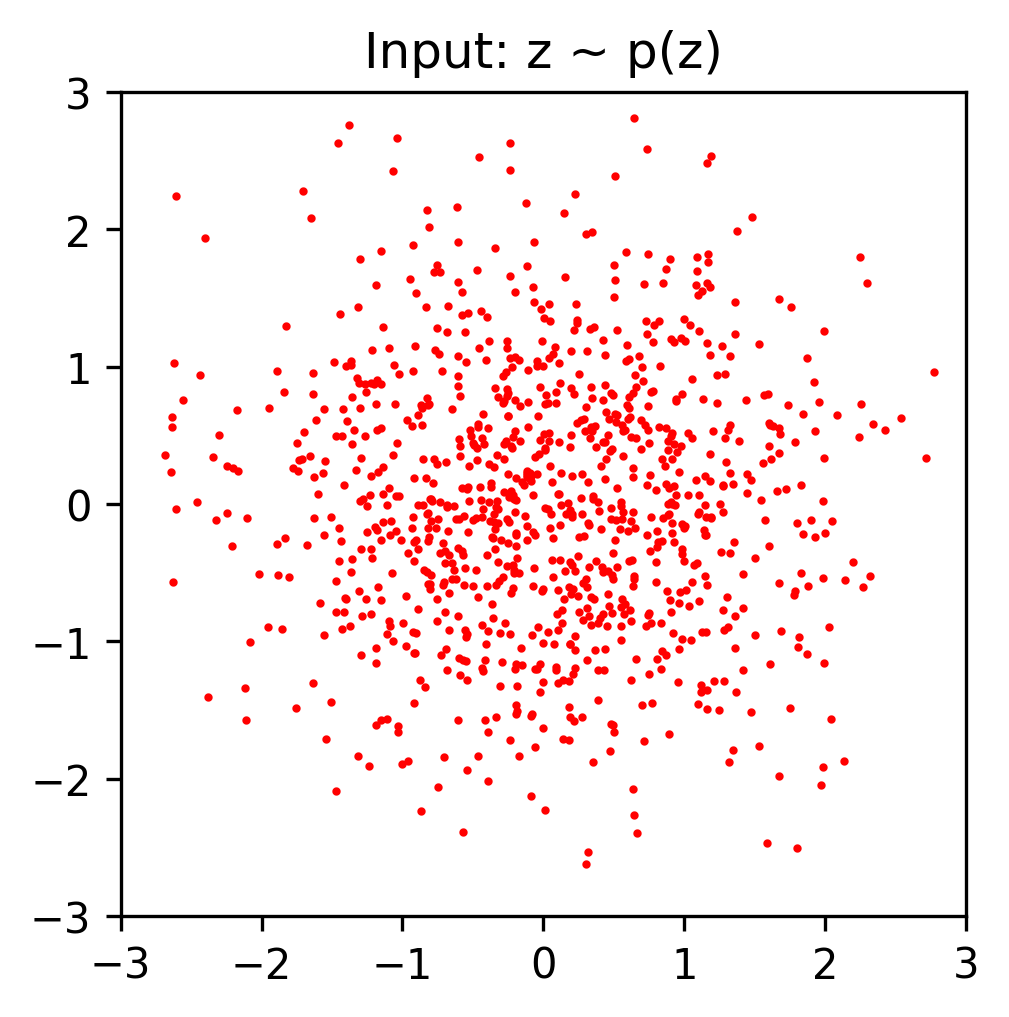

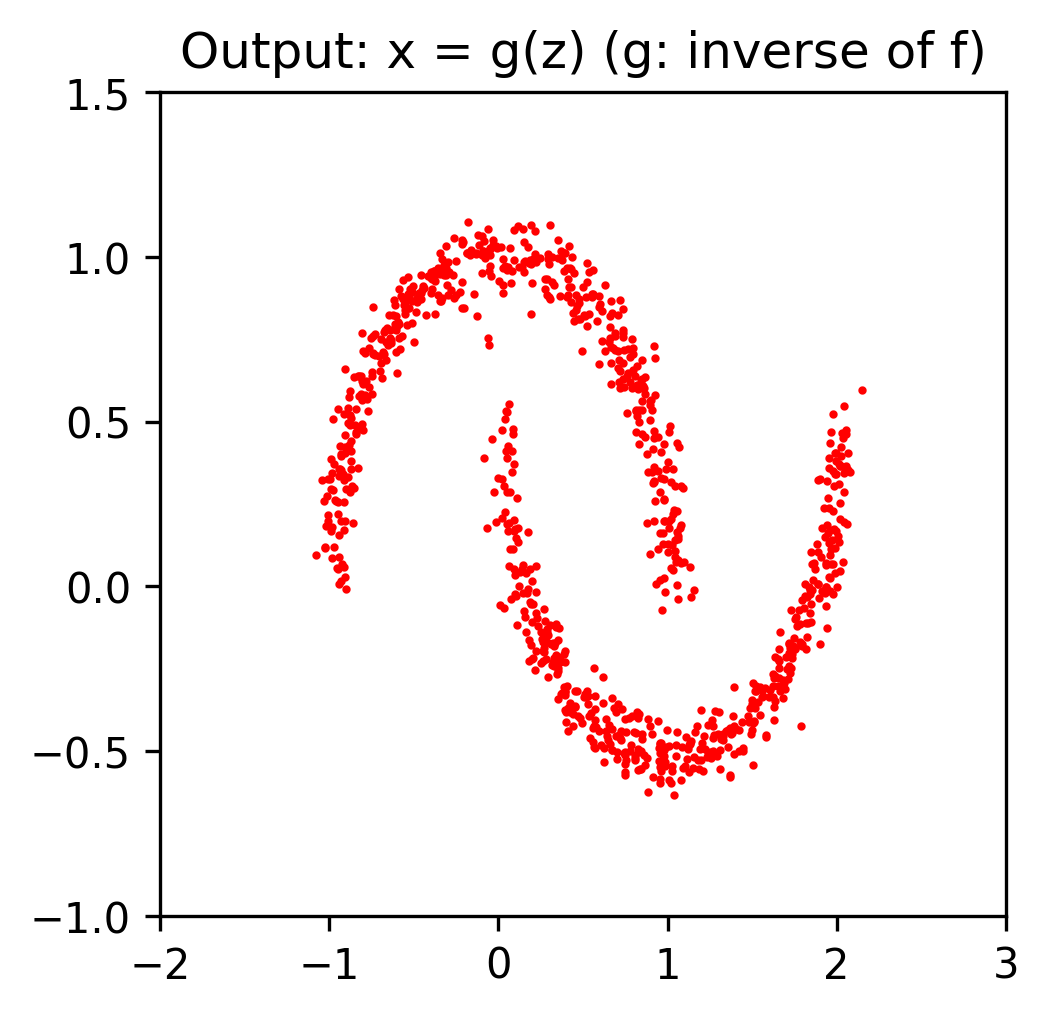

<Figure size 2400x2400 with 0 Axes>

In [8]:


# --- configuration --- #
BATCH_SIZE = 128
LOG_INTERVAL = 50
EPOCHS = 20
INPUT_DIM = 2
OUTPUT_DIM = 2
HIDDEN_DIM = 256
SAVE_PLT_INTERVAL = 5
N_COUPLE_LAYERS = 8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rcParams['figure.figsize'] = 8, 8
plt.ion()


# --- data loading --- #
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)

# pin memory provides improved transfer speed
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **kwargs)


# --- defines the model and the optimizer ---- #
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, mask):
        super().__init__()
        self.s_fc1 = nn.Linear(input_dim, hid_dim)
        self.s_fc2 = nn.Linear(hid_dim, hid_dim)
        self.s_fc3 = nn.Linear(hid_dim, output_dim)
        self.t_fc1 = nn.Linear(input_dim, hid_dim)
        self.t_fc2 = nn.Linear(hid_dim, hid_dim)
        self.t_fc3 = nn.Linear(hid_dim, output_dim)
        self.mask = mask

    def forward(self, x):
        x_m = x * self.mask
        s_out = torch.tanh(self.s_fc3(F.relu(self.s_fc2(F.relu(self.s_fc1(x_m))))))
        t_out = self.t_fc3(F.relu(self.t_fc2(F.relu(self.t_fc1(x_m)))))
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)
        return y, log_det_jacobian

    def backward(self, y):
        y_m = y * self.mask
        s_out = torch.tanh(self.s_fc3(F.relu(self.s_fc2(F.relu(self.s_fc1(y_m))))))
        t_out = self.t_fc3(F.relu(self.t_fc2(F.relu(self.t_fc1(y_m)))))
        x = y_m + (1-self.mask)*(y-t_out)*torch.exp(-s_out)
        return x


class RealNVP(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, mask, n_layers = 6):
        super().__init__()
        assert n_layers >= 2, 'num of coupling layers should be greater or equal to 2'

        self.modules = []
        self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, mask))
        self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)
        
    def forward(self, x):
        ldj_sum = 0 # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj= module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def backward(self, z):
        for module in reversed(self.module_list):
            z = module.backward(z)
        return z


mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIM, mask, N_COUPLE_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))


# --- train and test --- #
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        z, log_det_j_sum = model(data)
        loss = -(prior_z.log_prob(z)+log_det_j_sum).mean()
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100.*batch_idx / len(train_loader),
                cur_loss/len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)
    ))


def test(epoch):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0,2)
    z_all = np.array([[]]).reshape(0,2)
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            z, log_det_j_sum = model(data)
            cur_loss = -(prior_z.log_prob(z)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all,data.numpy()))
            z_all = np.concatenate((z_all,z.numpy()))
        
        subfig_plot(1, x_all, -2, 3, -1, 1.5,'Input: x ~ p(x)', 'b')
        subfig_plot(2, z_all, -3, 3, -3,3,'Output: z = f(x)', 'b')

        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))


# --- etc. functions --- #
def sample(epoch):
    model.eval()
    with torch.no_grad():
        z = prior_z.sample((1000,))
        x = model.backward(z)
        z = z.numpy()
        x = x.numpy()

        subfig_plot(3, z, -3, 3, -3, 3, 'Input: z ~ p(z)', 'r')
        subfig_plot(4, x, -2, 3, -1, 1.5,'Output: x = g(z) (g: inverse of f)', 'r')


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
        if location == 1:
            plt.clf()
        plt.subplot(2,2,location)
        plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
        plt.xlim(x_start,x_end)
        plt.ylim(y_start,y_end)
        plt.title(title)
        plt.pause(1e-2)


# --- main function --- #
if __name__ == '__main__':
    for epoch in range(1, EPOCHS + 1):
        train(epoch)
        test(epoch)
        sample(epoch)